# Detecting Neanderthal Introgression with Deep Learning

#### Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)

<h3><center>Abstract</center></h3>
In this notebook, I will demonstrate how we can use Deep Learning for calling regions of Neanderthal introgression in modern humans.

### Table of Contents:
* [Extract Regions of Neanderthal Introgression](#Extract-regions-of-Neanderthal-Introgression)
* [Extract Regions of Reduced Neanderthal Ancestry](#Extract-Regions-of-Reduced-Neanderthal-Ancestry)
* [Clean Fasta-Files from N-Containing Entries](#Clean-Fasta-Files-from-N-Containing-Entries)
* [Prepare Data for Convolutional Neural Network](#Prepare-Data-for-Convolutional-Neural-Network) 
* [Run Shallow Convolutional Neural Network](#Run-Shallow-Convolutional-Neural-Network) 
* [Gene vs. Non-Gene Sequence Classification](#Gene-vs.-Non-Gene-Sequence-Classification)
* [Better Annotation of Neanderthal Introgressed Haplotypes](#Better-Annotation-of-Neanderthal-Introgressed-Haplotypes)
* [Use NLP and Word Embeddings](#Use-NLP-and-Word-Embeddings)
* [Word Embeddings + Multichannel Convolutional Neural Network (CNN)](#Word-Embeddings-+-Multichannel-Convolutional-Neural-Network-(CNN))

### Extract Regions of Neanderthal Introgression  <a class="anchor" id="Extract-regions-of-Neanderthal-Introgression"></a>

Since the revolutionary draft of Neanderthal genome https://science.sciencemag.org/content/328/5979/710 paper, a few studies had been carried out to systematically establish the maps of regions of Neanderthal introgression into modern humans. Those regions had were hypothesized to have multiple functional effects related to skin color, male fertility etc.

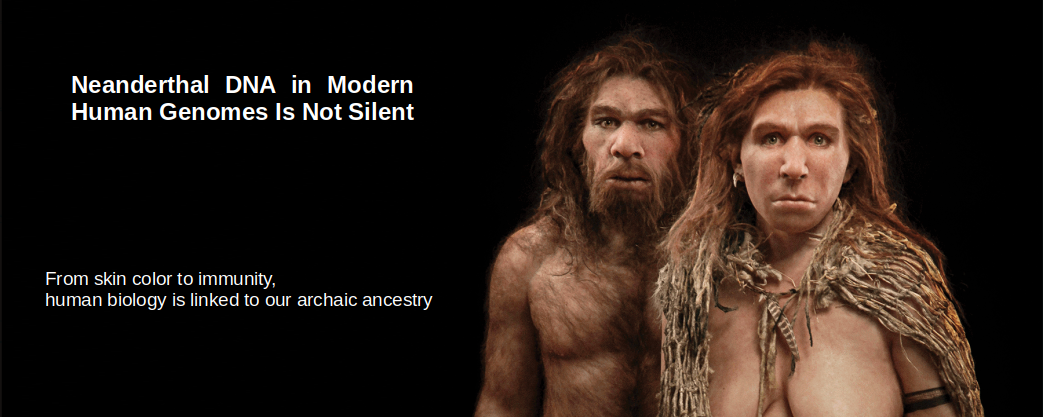

In [3]:
from IPython.display import Image
Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/'
Image(Path + 'neanderthal_dna.png', width=2000)

Since both Reich and Akey did the 1000G Neanderthal Introgression calls using hg19 version of human reference genome, we downloaded the hg19 from http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/ and prepared it for fast sequence extraction with samtools faidx. Let us test it and print the sequence of the SLC16A11 gene which is a gene inherited from Neandertals and known to have strong association with Type 2 Diabetes (T2D).

In [5]:
%%bash
cd /home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/
samtools faidx hg19.fa.gz chr17:6944941-6947411 | sed '1d' | tr -d '\n'

TTCAGGAAAACCCGATAAAAATTCTTTATTGGGGGAGGGGCTCAAACAAGAAAATAATCAACAAGTGGTGTCCAGAGTGGAGCCAGGGCCTCCTGGGGACAGCAAGACTGCCTGGGGAGCGGGAAGCAGCTCCCCCGTCTCTGGGGGAGGCGTGGCTGGAGGGGAGGCTGGACCACAGGAGGGCAGCGCCCTGGGCAACCCTATGTAGATGAAGCTGCCGGAGAGGATCAAAGAACCAGACAGGAGGAAAGAGGCGGTGAAGTCTCCTGTCTCATCCCTTAGGAAGCCTGAGGAGATGGGTAAGGGCATTTAGAAGCCTCGAACCCCAGGGGCAGAGGATAGTTGTAGGCAGATCTGTGAGCTCAGGTCCTTACCTGACAGGGGAGGGCCCAGGAGCCCCCCGAGGCTCATCAGCATCATCACCAGCCCTGTGGCCTGCACCACACCTCCGACGCCCACCAGCCCGGGGAGTACACCGAAAACCAGCGGGGCGTAACTCCCCGCGCTCAGCCCATAGGCCACAGCCGCGGCCAGCAGGGGACCCCCCCAGCTCTCTTCGCCGCCCACCACGGGCACCAGCCCCACCACCCACAGCCCCAGCCCAGTCAGAGCCCCGAATACGGCCAGCAGCCGCGGGAGGGGCACCCAGCCTTGGTCTGCCAGCCACCCGCAGACCAGCCGGGCGCCCGCATCCCCCATCGCAGCCACGGCCACCACCAGCGCTGCTCCGTATCCCCCCAGGCCCCGGTCTAAAGCGTGGGGAGCCAAGTGCACGTAAGGAACGAAGTACCCGCCCCCAACCAGGGCTGTGCCTAGAGCAAAGATTGAGAAGGCCCGGCGTGTGAACAGACTCAGGCCGAGGGCAGCTAGGGGACTACGCGGTGGGGCTGGGGGGTCTCCAGGAAGGACCAGGGGTAGCAGCAGGGCGCCACAGGGGGTGAGGTGGAGGGTGATCGCGCCGAGGAGGAGCAGAGCGCCCCGCCAGCCGAAAGTATCGAGA

We can also write a simple Python script that extracts sequences from the fasta-file from certain regions. Again, we extract the SLC16A11 sequance and compare it with the sequence extracted with samtools:

In [3]:
import gzip
def getfasta(chr, start, end):
    Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/'
    start_reading = 0
    line_to_print = []
    with gzip.open(Path + 'hg19.fa.gz', 'rb') as fin:
        for line in fin:
            line = line.decode('utf-8').rstrip()
            if start_reading == 1 and line[0] != '>':
                line_to_print.append(line)
            if line == '>chr' + str(chr):
                start_reading = 1
    print('\x1b[31m' + str(''.join(line_to_print)[start-1:end]) + '\x1b[0m')
getfasta(17, 6944941, 6947411)

TTCAGGAAAACCCGATAAAAATTCTTTATTGGGGGAGGGGCTCAAACAAGAAAATAATCAACAAGTGGTGTCCAGAGTGGAGCCAGGGCCTCCTGGGGACAGCAAGACTGCCTGGGGAGCGGGAAGCAGCTCCCCCGTCTCTGGGGGAGGCGTGGCTGGAGGGGAGGCTGGACCACAGGAGGGCAGCGCCCTGGGCAACCCTATGTAGATGAAGCTGCCGGAGAGGATCAAAGAACCAGACAGGAGGAAAGAGGCGGTGAAGTCTCCTGTCTCATCCCTTAGGAAGCCTGAGGAGATGGGTAAGGGCATTTAGAAGCCTCGAACCCCAGGGGCAGAGGATAGTTGTAGGCAGATCTGTGAGCTCAGGTCCTTACCTGACAGGGGAGGGCCCAGGAGCCCCCCGAGGCTCATCAGCATCATCACCAGCCCTGTGGCCTGCACCACACCTCCGACGCCCACCAGCCCGGGGAGTACACCGAAAACCAGCGGGGCGTAACTCCCCGCGCTCAGCCCATAGGCCACAGCCGCGGCCAGCAGGGGACCCCCCCAGCTCTCTTCGCCGCCCACCACGGGCACCAGCCCCACCACCCACAGCCCCAGCCCAGTCAGAGCCCCGAATACGGCCAGCAGCCGCGGGAGGGGCACCCAGCCTTGGTCTGCCAGCCACCCGCAGACCAGCCGGGCGCCCGCATCCCCCATCGCAGCCACGGCCACCACCAGCGCTGCTCCGTATCCCCCCAGGCCCCGGTCTAAAGCGTGGGGAGCCAAGTGCACGTAAGGAACGAAGTACCCGCCCCCAACCAGGGCTGTGCCTAGAGCAAAGATTGAGAAGGCCCGGCGTGTGAACAGACTCAGGCCGAGGGCAGCTAGGGGACTACGCGGTGGGGCTGGGGGGTCTCCAGGAAGGACCAGGGGTAGCAGCAGGGCGCCACAGGGGGTGAGGTGGAGGGTGATCGCGCCGAGGAGGAGCAGAGCGCCCCGCCAGCCGAAAGTATCGAGA

In [101]:
import gzip
def getfasta(chr, start, end):
    Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/'
    start_reading = 0
    line_to_print = []
    with gzip.open(Path + 'hg19.fa.gz', 'rb') as fin:
        for line in fin:
            line = line.decode('utf-8').rstrip()
            if start_reading == 1 and line[0] != '>':
                line_to_print.append(line)
            if line == '>chr' + str(chr):
                start_reading = 1
    print('\x1b[31m' + str(''.join(line_to_print)[start-1:end]) + '\x1b[0m')
getfasta(17, 6946902, 6946904)

CAT


The sequences look identical, still it is much, much faster with samtools (optimized C++ code) than with my Python implementation, so in the future for creating a fasta-file containing the Neandertal introgressed regions, we will do it via samtools faidx. Now let us turn to the Neandertal introgressed regions.

We downloaded the merged maps of Neandertal introgression for European + Asian 1000G populations published in Vernot and Akey, Science, 2014 from here https://akeylab.princeton.edu/downloads.html. Now let us read the coordinates of the introgressed regions and extract their sequences from the hg19 human genome and write the sequences in a new "introgression" fasta-file:

In [7]:
import pandas as pd
Path = '/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression/'
intr_coords = pd.read_csv(Path + '1000G_Akey_NeandIntrogression/all_haplotypes_populations.bed.all', 
                          header = None, sep = "\t")
intr_coords.head()

0        1        2
0  chr1   834360   867552
1  chr1  1505425  1557644
2  chr1  1880284  1928481
3  chr1  1960388  2064958
4  chr1  2206041  2249092

In [8]:
intr_coords.shape

(6721, 3)

Let us check the distribution of the lengths of the introgressed regions, this information will be important later when we select the **k** paremeter for the k-mer analysis when we split the sequences ("biological text") into k-mers ("biological words"):

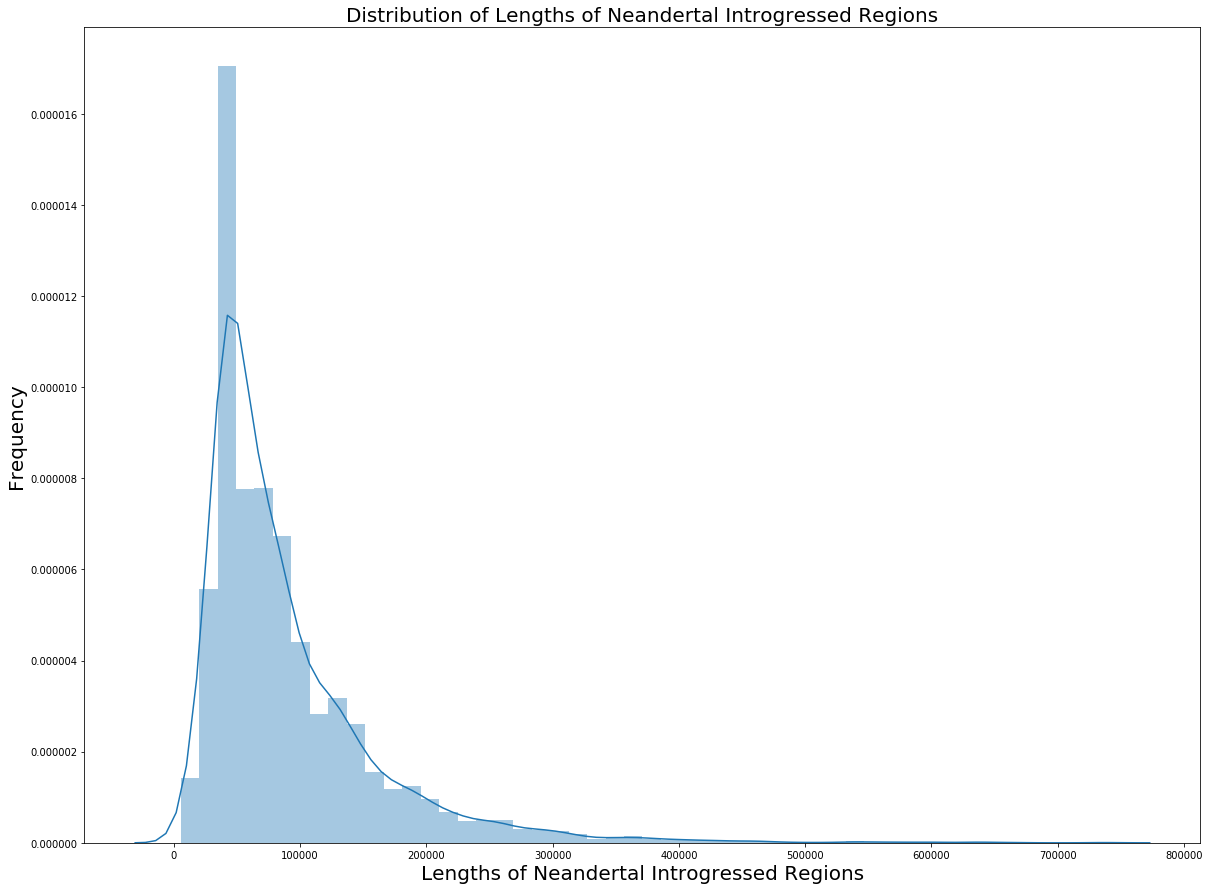

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
intr_lengths = intr_coords.iloc[:, 2]-intr_coords.iloc[:, 1]
sns.distplot(intr_lengths)
plt.title("Distribution of Lengths of Neandertal Introgressed Regions", fontsize = 20)
plt.xlabel("Lengths of Neandertal Introgressed Regions", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

In [10]:
from scipy import stats
print(stats.describe(intr_lengths))

DescribeResult(nobs=6721, minmax=(5251, 737082), mean=89296.93021871745, variance=4886040758.3506365, skewness=2.551246218418572, kurtosis=10.205693287318592)


We can see that the minimal DNA stretch of Neanderthal introgression is around 5 kbp and the maximal is close to 1 Mbp. Nevertheless, taking into account that the inbreeding occured approximately 50 000 years ago which is equaivalent to approximately 2000 human generations ago, this would be equivalent to less than 100 kbp regions survived from Neanderthals according to the estimates of David Reich https://www.nature.com/articles/nature12961. Therefore, the DNA regions from the right tail of the distribution are highly unlikely to trully come from Neanderthals but are most likely false positives, and the DNA sequences close to the mode of the distribution should be prioritized for further analysis.

In [11]:
import os
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')
a = 0
with open('hg19_introgr_regions.fa', 'a') as fp:
    for i in range(intr_coords.shape[0]):
        coord = str(str(intr_coords.iloc[i, 0]) + ':' 
                    + str(intr_coords.iloc[i, 1]) + '-' + str(intr_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)
        a = a + 1
        if a%1000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')

Finished 1000 Neanderthal introgressed haplotypes
Finished 2000 Neanderthal introgressed haplotypes
Finished 3000 Neanderthal introgressed haplotypes
Finished 4000 Neanderthal introgressed haplotypes
Finished 5000 Neanderthal introgressed haplotypes
Finished 6000 Neanderthal introgressed haplotypes


It is interesting to try to make a simple k-mer analysis with **kat**, we downloaded and installed **kat** from here https://kat.readthedocs.io/en/latest/index.html and run it using the following command line:

In [48]:
# kat hist hg19_introgr_regions.fa
# kat plot spectra-hist -x 500 kat.hist
'''
Kmer Analysis Toolkit (KAT) V2.4.2

Running KAT in HIST mode
------------------------

Input 1 is a sequence file.  Counting kmers for input 1 (hg19_introgr_regions.fa) ...
Warning: Specified hash size insufficent - attempting to double hash size... success!

Warning: Specified hash size insufficent - attempting to double hash size... success!

Warning: Specified hash size insufficent - attempting to double hash size... success!
 done.  Time taken: 517.0s

Bining kmers ... done.  Time taken: 51.8s

Merging counts ... done.  Time taken: 0.0s

Saving results to disk ... done.  Time taken: 0.0s

Creating plot ... done.  Time taken: 1.4s

Analysing peaks
---------------

Analysing distributions for: kat.hist ... done.  Time taken:  3.7s

K-mer frequency spectra statistics
----------------------------------
K-value used: 27
Peaks in analysis: 3
Global minima @ Frequency=77x (1054)
Global maxima @ Frequency=79x (1085)
Overall mean k-mer frequency: 163x

  Index    Left    Mean    Right    StdDev    Max    Volume  Description
-------  ------  ------  -------  --------  -----  --------  -------------
      1   14.41      79   143.59     32.3     306     24648  1X
      2   17.66     156   294.34     69.17    234     40154  2X
      3   30.04     395   759.96    182.48     31     10257  5X

Calculating genome statistics
-----------------------------
Assuming that homozygous peak is the largest in the spectra with frequency of: 79x
Homozygous peak index: 1
CAUTION: the following estimates are based on having a clean spectra and having identified 
the correct homozygous peak!
Estimated genome size: 0.14 Mbp

Creating plots
--------------

Plotting K-mer frequency distributions ... done.  Saved to: None


KAT HIST completed.
Total runtime: 574.5s
'''

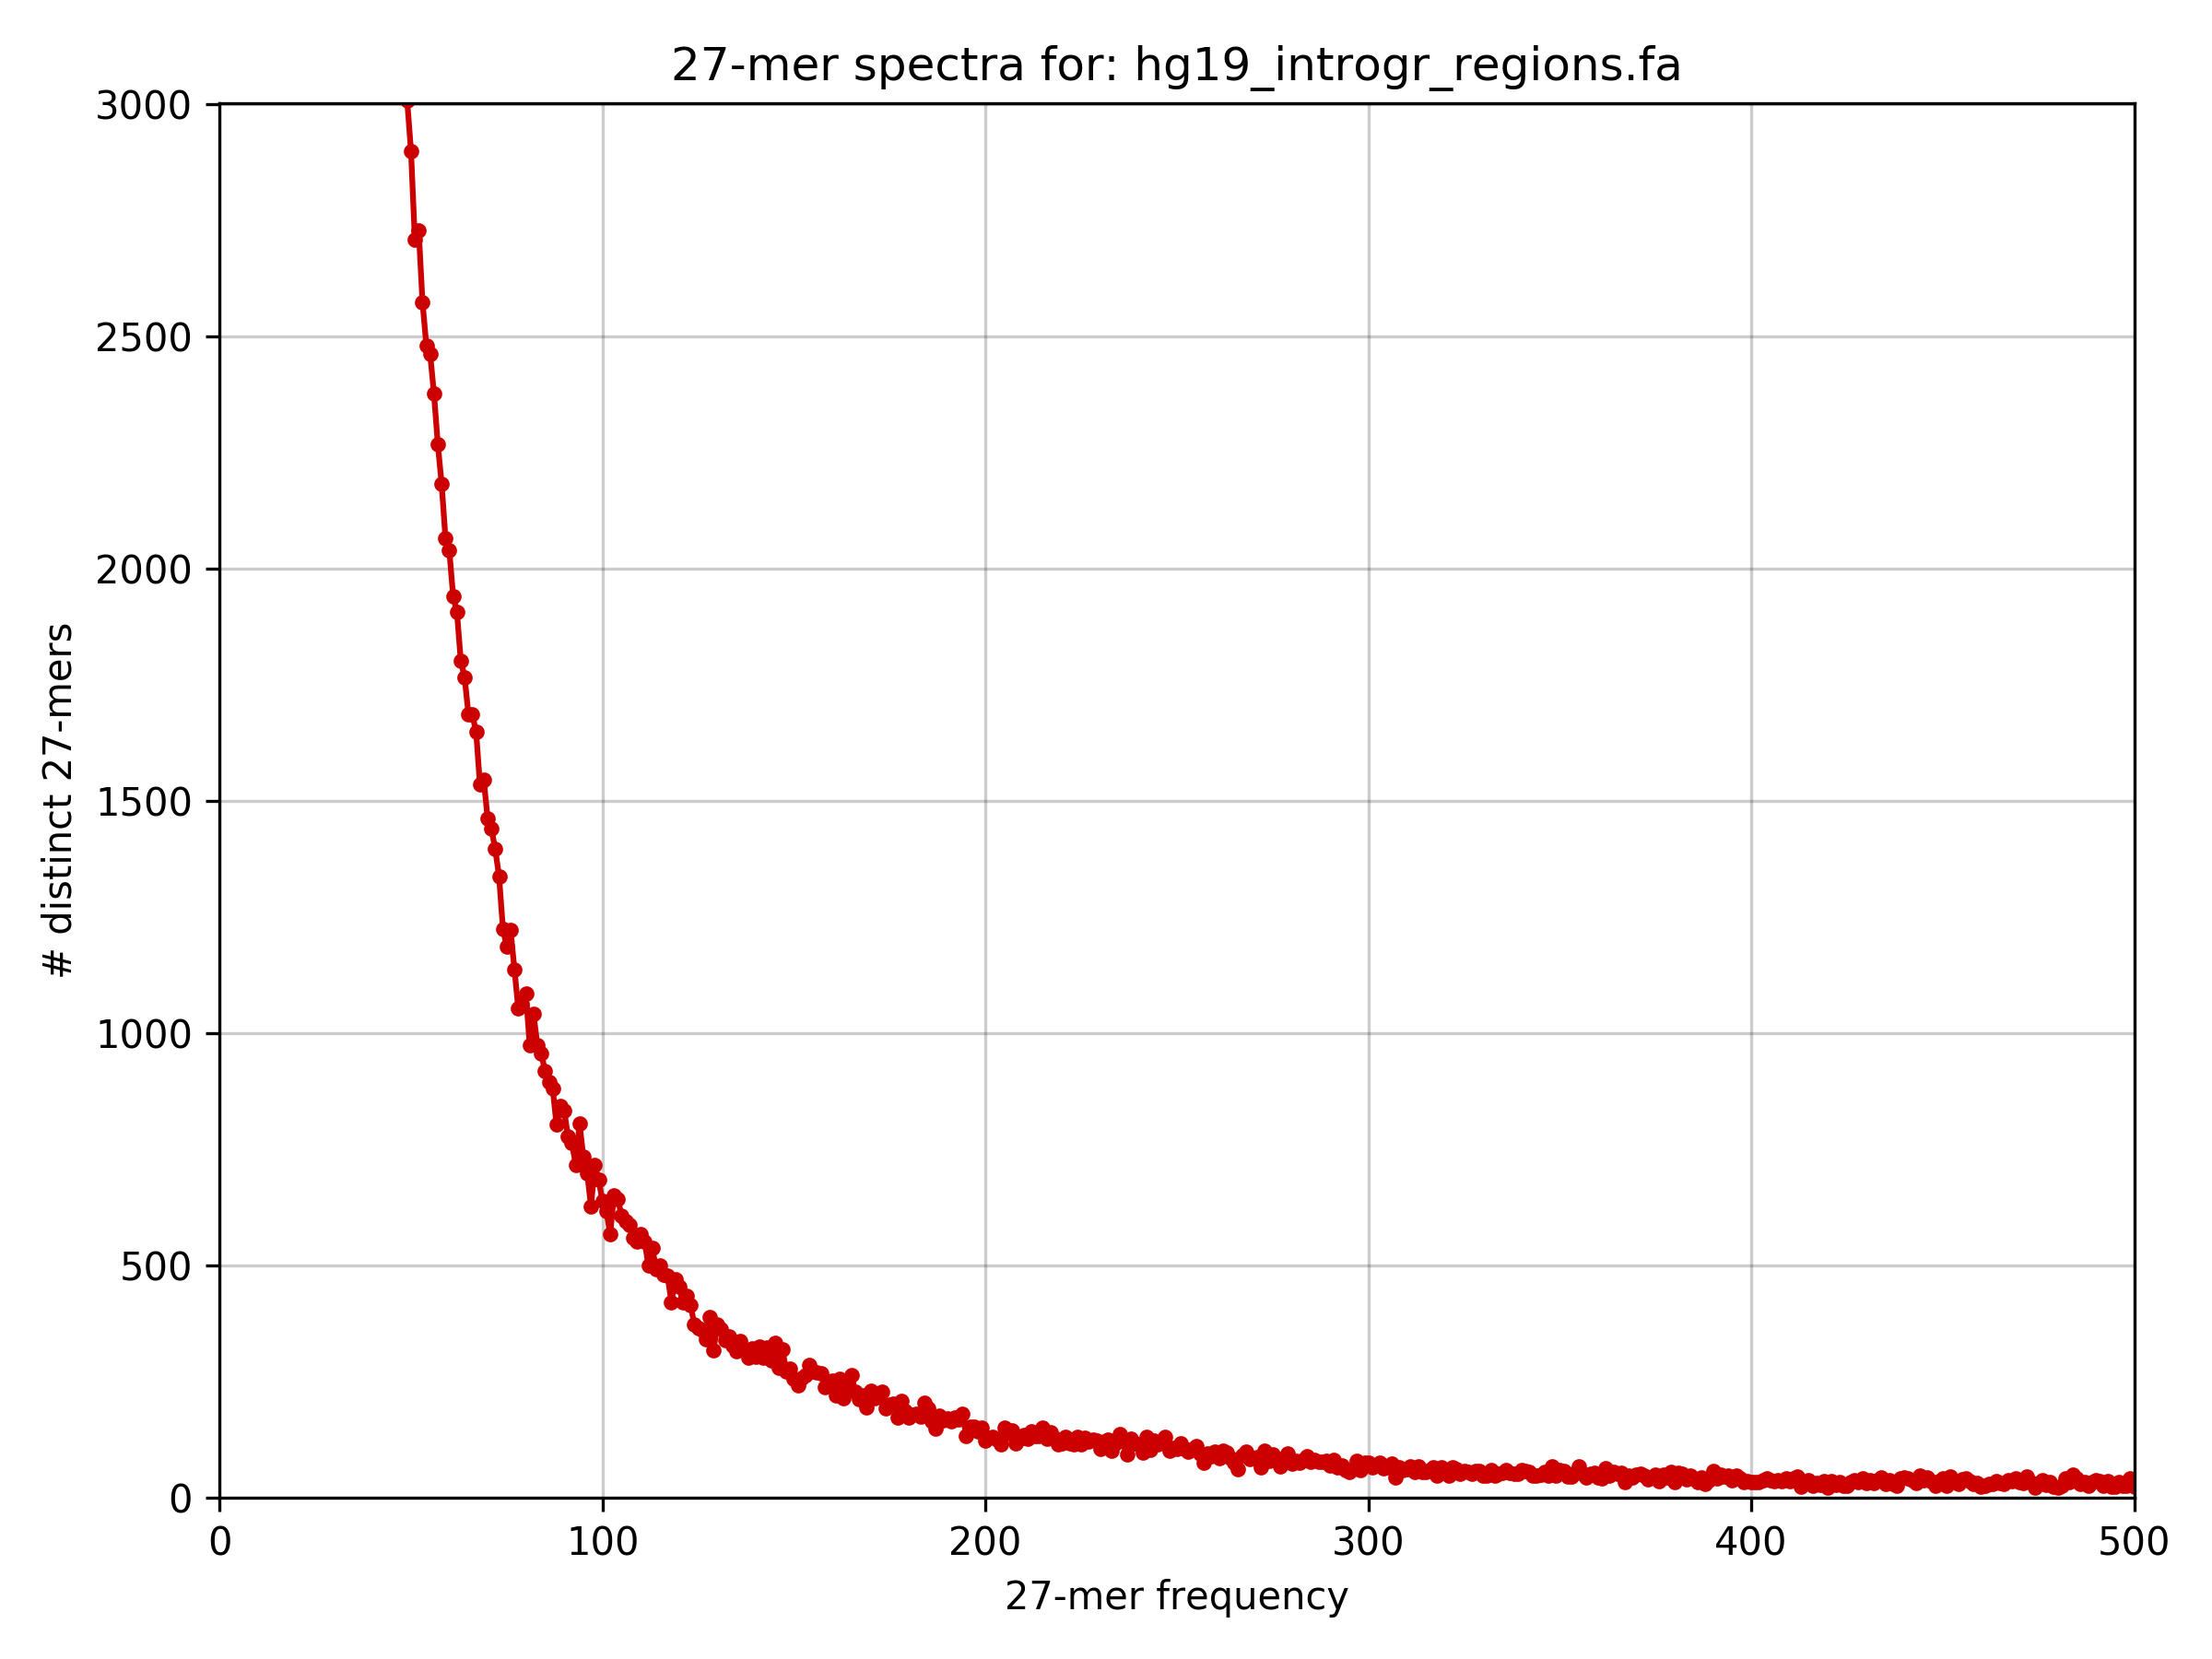

In [263]:
from IPython.display import Image
Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/'
Image(Path + 'kat_intr-spectra-hist.png', width=2000)

### Extract Regions of Reduced Neanderthal Ancestry  <a class="anchor" id="Extract-Regions-of-Reduced-Neanderthal-Ancestry"></a>

Now we need a set of control sequences, i.e. a set of identical length regions extracted from the regions of depleted Neanderthal ancestry.

In [57]:
intr_coords.head()

0        1        2
0  chr1   834360   867552
1  chr1  1505425  1557644
2  chr1  1880284  1928481
3  chr1  1960388  2064958
4  chr1  2206041  2249092

In [233]:
list(intr_lengths)[0:10]

[33192, 52219, 48197, 104570, 43051, 83170, 58798, 121590, 115844, 161767]

In [139]:
chr_sizes = pd.read_csv("hg19.fa.gz.fai", header=None, sep="\t")
chr_sizes.head()

0          1          2   3   4
0  chr1  249250621          6  50  51
1  chr2  243199373  254235646  50  51
2  chr3  198022430  502299013  50  51
3  chr4  191154276  704281898  50  51
4  chr5  180915260  899259266  50  51

In [241]:
i = 0

chr_df = intr_coords[intr_coords[0] == intr_coords[0][i]]
overlap = True
while overlap == True:
    reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords[0][i]].iloc[:,1]))
    reg_end = reg_start + intr_lengths[i]
    print(reg_start)
    for j in range(chr_df.shape[0]):
        b1 = chr_df[1][j]
        b2 = chr_df[2][j]
        if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2):
            print(reg_start, reg_end, chr_df[1][j], chr_df[2][j])
            overlap = True
            break
        else:
            overlap = False
print(intr_coords[0][i], reg_start, reg_end)

230513872
230513872 230547064 230521064 230558720
121412471
chr1 121412471 121445663


In [256]:
chr_list = []
start_list = []
end_list = []
for i in range(intr_coords.shape[0]):
    #print(i)
    chr_df = intr_coords[intr_coords[0] == intr_coords[0][i]]
    b1 = chr_df[1][i]
    b2 = chr_df[2][i]
    overlap = True
    while overlap == True:
        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords[0][i]].iloc[:,1]))
        reg_end = reg_start + intr_lengths[i]
        #print(reg_start)
        for j in range(chr_df.shape[0]):
            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2):
                #print(reg_start, reg_end, chr_df[1][j], chr_df[2][j])
                overlap = True
                break
            else:
                overlap = False
    #print(intr_coords[0][i], reg_start, reg_end)
    chr_list.append(intr_coords[0][i])
    start_list.append(reg_start)
    end_list.append(reg_end)
depl_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
depl_coords.head()

0          1          2
0  chr1   27739522   27772714
1  chr1   61614008   61666227
2  chr1   16466982   16515179
3  chr1  145434652  145539222
4  chr1   45933725   45976776

In [257]:
depl_coords.shape

(6721, 3)

In [259]:
intr_coords.head()

0        1        2
0  chr1   834360   867552
1  chr1  1505425  1557644
2  chr1  1880284  1928481
3  chr1  1960388  2064958
4  chr1  2206041  2249092

In [258]:
depl_lengths = depl_coords.iloc[:, 2] - depl_coords.iloc[:, 1]

In [260]:
list(intr_lengths)[0:10]

[33192, 52219, 48197, 104570, 43051, 83170, 58798, 121590, 115844, 161767]

In [261]:
list(depl_lengths)[0:10]

[33192, 52219, 48197, 104570, 43051, 83170, 58798, 121590, 115844, 161767]

In [262]:
import os
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')
with open('hg19_depl_regions.fa', 'a') as fp:
    for i in range(depl_coords.shape[0]):
        coord = str(str(depl_coords.iloc[i, 0]) + ':' 
                    + str(depl_coords.iloc[i, 1]) + '-' + str(depl_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)

In [ ]:
# kat hist hg19_depl_regions.fa
'''
Kmer Analysis Toolkit (KAT) V2.4.2

Running KAT in HIST mode
------------------------

Input 1 is a sequence file.  Counting kmers for input 1 (hg19_depl_regions.fa) ...
Warning: Specified hash size insufficent - attempting to double hash size... success!

Warning: Specified hash size insufficent - attempting to double hash size... success!
 done.  Time taken: 303.3s

Bining kmers ... done.  Time taken: 61.1s

Merging counts ... done.  Time taken: 0.0s

Saving results to disk ... done.  Time taken: 0.0s

Creating plot ... done.  Time taken: 1.3s

Analysing peaks
---------------

Analysing distributions for: kat.hist ... done.  Time taken:  3.9s

K-mer frequency spectra statistics
----------------------------------
K-value used: 27
Peaks in analysis: 3
Global minima @ Frequency=68x (1358)
Global maxima @ Frequency=70x (1372)
Overall mean k-mer frequency: 146x

  Index    Left    Mean    Right    StdDev    Max    Volume  Description
-------  ------  ------  -------  --------  -----  --------  -------------
      1   13.66      70   126.34     28.17    406     28539  1X
      2   16.61     138   259.39     60.69    294     44290  2X
      3   28.38     350   671.62    160.81     38     12552  5X

Calculating genome statistics
-----------------------------
Assuming that homozygous peak is the largest in the spectra with frequency of: 70x
Homozygous peak index: 1
CAUTION: the following estimates are based on having a clean spectra and having identified the correct homozygous peak!
Estimated genome size: 0.15 Mbp

Creating plots
--------------

Plotting K-mer frequency distributions ... done.  Saved to: None


KAT HIST completed.
Total runtime: 370.1s
'''

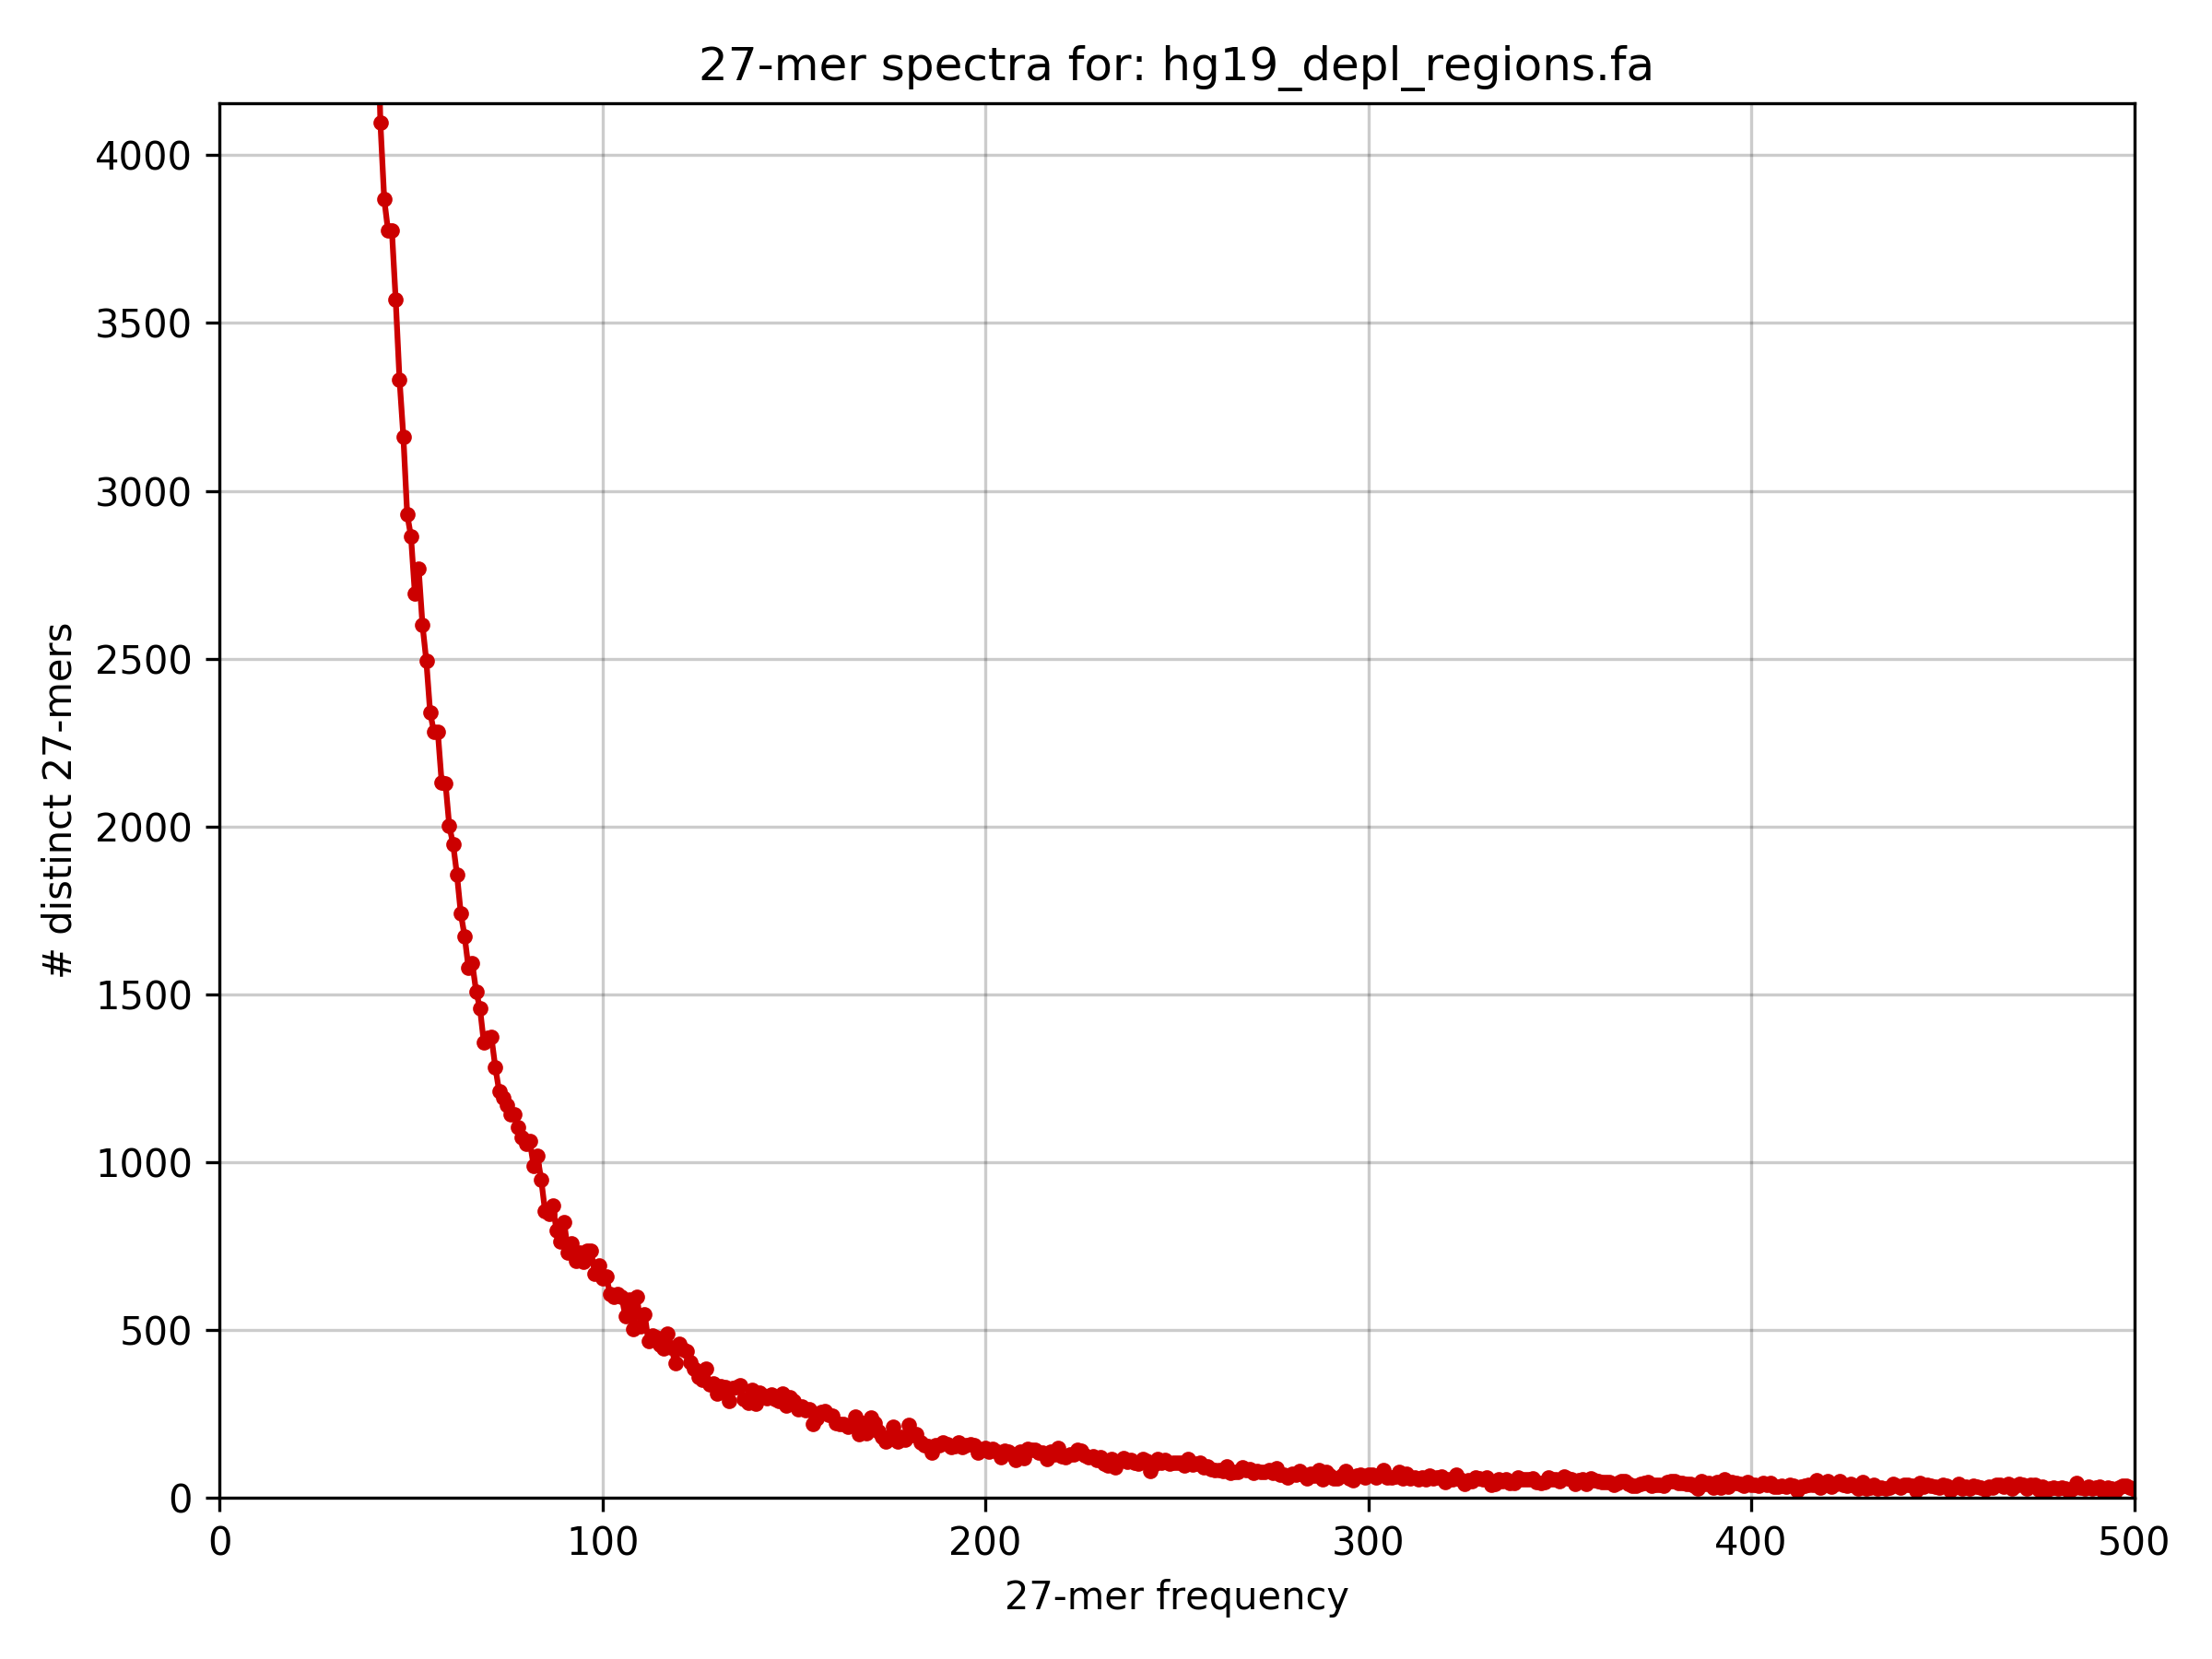

In [264]:
from IPython.display import Image
Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/'
Image(Path + 'kat_depl-spectra-hist.png', width=2000)

We do not see any different functional behavior in the k-mer spectra between Neanderthal introgressed and depleted regions. Let us plot the two spectra against each other in order to see if there are any differences:

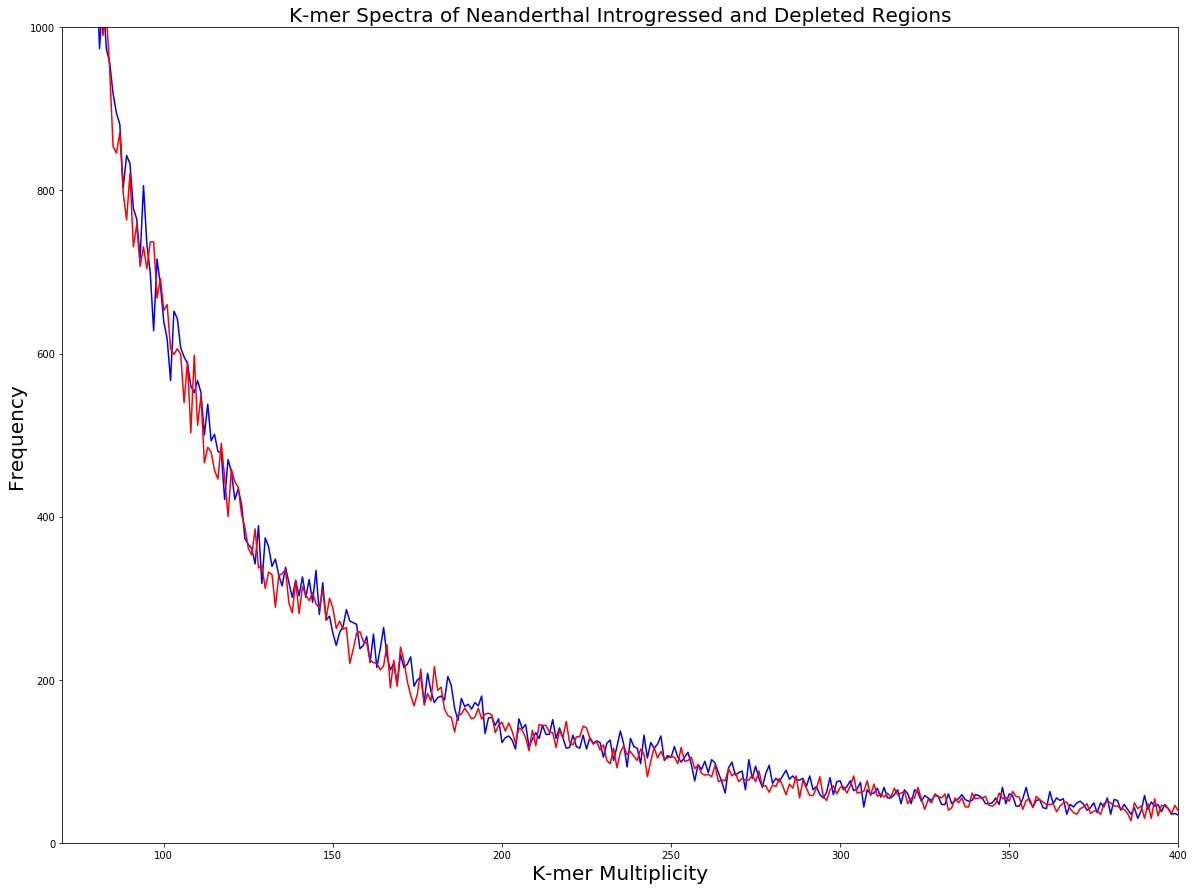

In [280]:
import numpy as np
import matplotlib.pyplot as plt
intr_spectr = pd.read_csv('kat_intr.hist', header = None, comment = "#", sep = " ")
depl_spectr = pd.read_csv('kat_depl.hist', header = None, comment = "#", sep = " ")
plt.figure(figsize=(20,15))
plt.plot(intr_spectr[0], intr_spectr[1], c = 'blue')
plt.plot(depl_spectr[0], depl_spectr[1], c = 'red')
plt.xlim(70, 400)
plt.ylim(0, 1000)
plt.title('K-mer Spectra of Neanderthal Introgressed and Depleted Regions', fontsize = 20)
plt.xlabel('K-mer Multiplicity', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.show()

So no obvious difference between the Neanderthal introgressed and depleted regions. However, one problem we had here is high proportion of regions containing long stretches of **N** nucleotides, meaning sequencing or genome assembly failed for these regions, might be repetative regions. Here we count how much **N**-containing lines we have in the fasta-files.

In [282]:
!grep -c N hg19_introgr_regions.fa

397


In [283]:
!grep -c N hg19_depl_regions.fa

651867


### Clean Fasta-Files from N-Containing Entries  <a class="anchor" id="Clean-Fasta-Files-from-N-Containing-Entries"></a>

Now we are going to clean the two fasta-files, i.e. Neanderthal introgressed and depleted regions, from entries containing N nucleotides. We could have selected from the very beginning only N-free regions, but since the damage is already done, for simplicity now we just remove the corresponding entries in both fasta-files if at least one of them contains N-nucleotides. In other words, if e.g. the introgressed fasta file contains a 5 kbp stretch of nucleotides where at least one of them is N, then we delete the whole stretch in the introgressed fasta-file and the corresponding 5 kbp stretch in the depeleted fasta-file.

In [314]:
from Bio import SeqIO
i = 0
for record in SeqIO.parse('hg19_introgr_regions.fa', 'fasta'):
    upper_record = record.seq.upper()
    if 'N' in upper_record:
        i = i + 1
print(i)

i = 0
for record in SeqIO.parse('hg19_depl_regions.fa', 'fasta'):
    upper_record = record.seq.upper()
    if 'N' in upper_record:
        i = i + 1
print(i)

11
505


It looks like the introgressed fasta-file has 11 entries containing N-nucleotide while the depleted fasta-file has 505 entries containing N-nucleotide. If those entries do not overlap, we will remove 516 entries from both fasta-files and convert the nucleoties into upper case in parallel, then will write the clean fasta-files into new files. We are going to convert the rest of the 6721 - 516 = 6205 entries into k-mers, which means we are going to have plenty of training daya for running Convolutional and Recurrent Neural Networks (CNN / RNN).

In [317]:
from Bio import SeqIO
for record in SeqIO.parse('hg19_introgr_regions.fa', 'fasta'):
    upper_record = record.seq.upper()
    if 'N' in upper_record:
        print(record.id)

chr10:64300331-64407831
chr2:31608174-31709440
chr2:31803557-31906844
chr2:33021841-33109648
chr2:33120746-33165152
chr21:33082494-33158443
chr21:43243448-43329377
chr22:19004802-19283682
chr3:60165205-60298045
chr4:8790165-8819778
chr4:40187108-40307705


In [326]:
from Bio import SeqIO

intr_file = 'hg19_introgr_regions.fa'
depl_file = 'hg19_depl_regions.fa'
a = 0
i = 0
with open('hg19_introgr_clean.fa', 'a') as intr_out, open('hg19_depl_clean.fa', 'a') as depl_out:
    for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
        upper_intr = intr.seq.upper()
        upper_depl = depl.seq.upper()
        a = a + 1
        if a%1000 == 0:
            print('Finished ' + str(a) + ' entries')
        if 'N' not in str(upper_intr) and 'N' not in str(upper_depl):
            intr.seq = upper_intr
            SeqIO.write(intr, intr_out, 'fasta')
            depl.seq = upper_depl
            SeqIO.write(depl, depl_out, 'fasta')
            i = i + 1
        else:
            continue
print('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to two fasta-files')

Finished 1000 entries
Finished 2000 entries
Finished 3000 entries
Finished 4000 entries
Finished 5000 entries
Finished 6000 entries
We have processed 6721 entries and written 6207 entries to two fasta-files


Let us make sure that there are no N-nucleotides present in the clean fasta-files:

In [327]:
!grep -c N hg19_introgr_clean.fa

0


In [328]:
!grep -c N hg19_depl_clean.fa

0


### Prepare Data for Convolutional Neural Network  <a class="anchor" id="Prepare-Data-for-Convolutional-Neural-Network"></a>

Now it is time to build Neanderthal intogressed vs. depleted sequences for further inputing them to the Convolutional Neural Network (CNN). For simplicity we will select all sequences of the same length equal to 5251 bp meaning the minimal length of the introgressed stretch of DNA. For this purpose we are going to cut all the sequences longer than 5251. 

In [56]:
import os
from Bio import SeqIO

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')

intr_file = 'hg19_introgr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

a = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    #intr_seqs.append(str(intr.seq)[0:np.min(depl_lengths)])
    #depl_seqs.append(str(depl.seq)[0:np.min(depl_lengths)])
    s_intr = str(intr.seq)[0:32]
    s_depl = str(depl.seq)[0:32]
    if s_intr.count('A')>0 and s_intr.count('C')>0 and s_intr.count('G')>0 and s_intr.count('T')>0 and \
    s_depl.count('A')>0 and s_depl.count('C')>0 and s_depl.count('G')>0 and s_depl.count('T')>0:
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
    a = a + 1
    if a%1000 == 0:
        print('Finished ' + str(a) + ' entries')

Finished 1000 entries
Finished 2000 entries
Finished 3000 entries
Finished 4000 entries
Finished 5000 entries
Finished 6000 entries


In [57]:
sequences = intr_seqs + depl_seqs
len(sequences)

11998

In [58]:
import numpy as np
labels = list(np.ones(len(intr_seqs))) + list(np.zeros(len(depl_seqs)))
len(labels)

11998

The next step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, tensors). To get each DNA sequence in the form of a matrix, we use one-hot encoding, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix.

In [59]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

# The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature, i.e. only 01 and 1 are present in the matrix
one_hot_encoder = OneHotEncoder()   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold = 40)
#print(input_features.shape)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CTCATTTCAG ... TCCTGGGAGT
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]]


In [60]:
one_hot_encoder = OneHotEncoder()
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[1. 1. 1. ... 0. 0. 0.]]
One-hot encoded labels:
 [[0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


Now we are going to split the data set into train and test data sets:

In [61]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size = 0.2, random_state = 42)

In [62]:
train_features.shape

(9598, 32, 4)

In [63]:
train_labels.shape

(9598, 2)

In [64]:
test_features.shape

(2400, 32, 4)

In [65]:
test_labels.shape

(2400, 2)

Now everything is ready for the classification with Convolutional Neural Network (CNN). Here we choose a simple 1D convolutional neural network (CNN), which is commonly used in deep learning for functional genomics applications.

### Run Shallow Convolutional Neural Network  <a class="anchor" id="Run-Shallow-Convolutional-Neural-Network"></a>
A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In our dataset, the filters will be motifs within the DNA sequences. The CNN may then learn to combine these filters to recognize a larger structure (e.g. the presence or absence of the Neanderthal introgression site on a sequence). We will start with defining Convolutional Neural Network (CNN) model and summarize the fitting parameters of the model.

In [83]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, Activation
from keras.models import Sequential
from keras.regularizers import l1

import warnings
warnings.filterwarnings('ignore')

model = Sequential()

model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                 input_shape = (train_features.shape[1], 4)))
model.add(Activation("relu"))
model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(8, kernel_initializer = 'he_uniform'))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))

epochs = 100
lrate = 0.01
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 32, 16)            336       
_________________________________________________________________
activation_22 (Activation)   (None, 32, 16)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 32, 16)            1296      
_________________________________________________________________
activation_23 (Activation)   (None, 32, 16)            0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 16, 16)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 256)               0         
__________

Now, we are ready to go ahead and train the neural network. We will further divide the training set into a training and validation set. We will train only on the reduced training set, but plot the loss curve on both the training and validation sets. Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.

In [84]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(train_features, train_labels, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True)

Train on 7678 samples, validate on 1920 samples
Epoch 1/100
7678/7678 [==============================] - 1s 152us/step - loss: 0.6998 - binary_accuracy: 0.5035 - val_loss: 0.6932 - val_binary_accuracy: 0.4995
Epoch 2/100
7678/7678 [==============================] - 1s 88us/step - loss: 0.6936 - binary_accuracy: 0.4964 - val_loss: 0.6933 - val_binary_accuracy: 0.4995
Epoch 3/100
7678/7678 [==============================] - 1s 90us/step - loss: 0.6933 - binary_accuracy: 0.5016 - val_loss: 0.6933 - val_binary_accuracy: 0.4995
Epoch 4/100
7678/7678 [==============================] - 1s 88us/step - loss: 0.6932 - binary_accuracy: 0.5061 - val_loss: 0.6931 - val_binary_accuracy: 0.4990
Epoch 5/100
7678/7678 [==============================] - 1s 89us/step - loss: 0.6931 - binary_accuracy: 0.5035 - val_loss: 0.6934 - val_binary_accuracy: 0.4995
Epoch 6/100
7678/7678 [==============================] - 1s 93us/step - loss: 0.6939 - binary_accuracy: 0.4919 - val_loss: 0.6931 - val_binary_accuracy

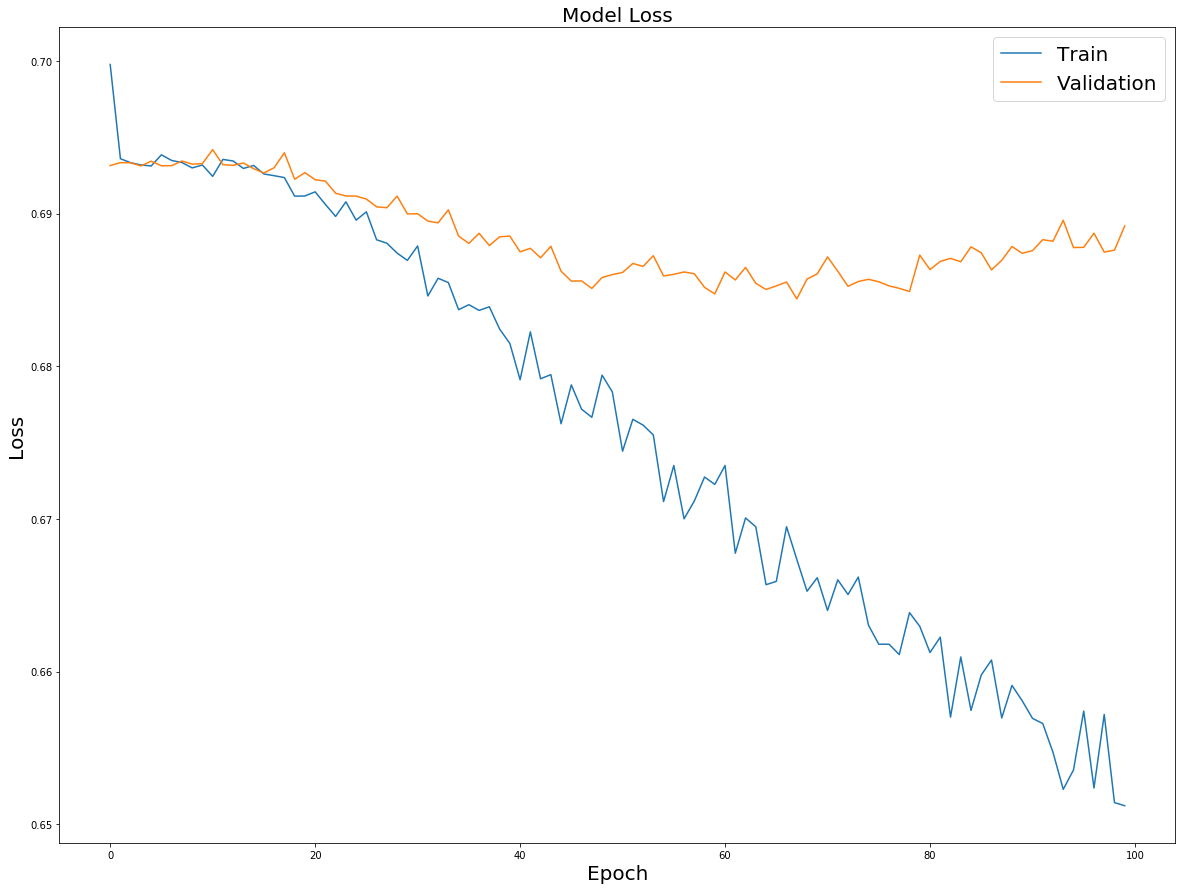

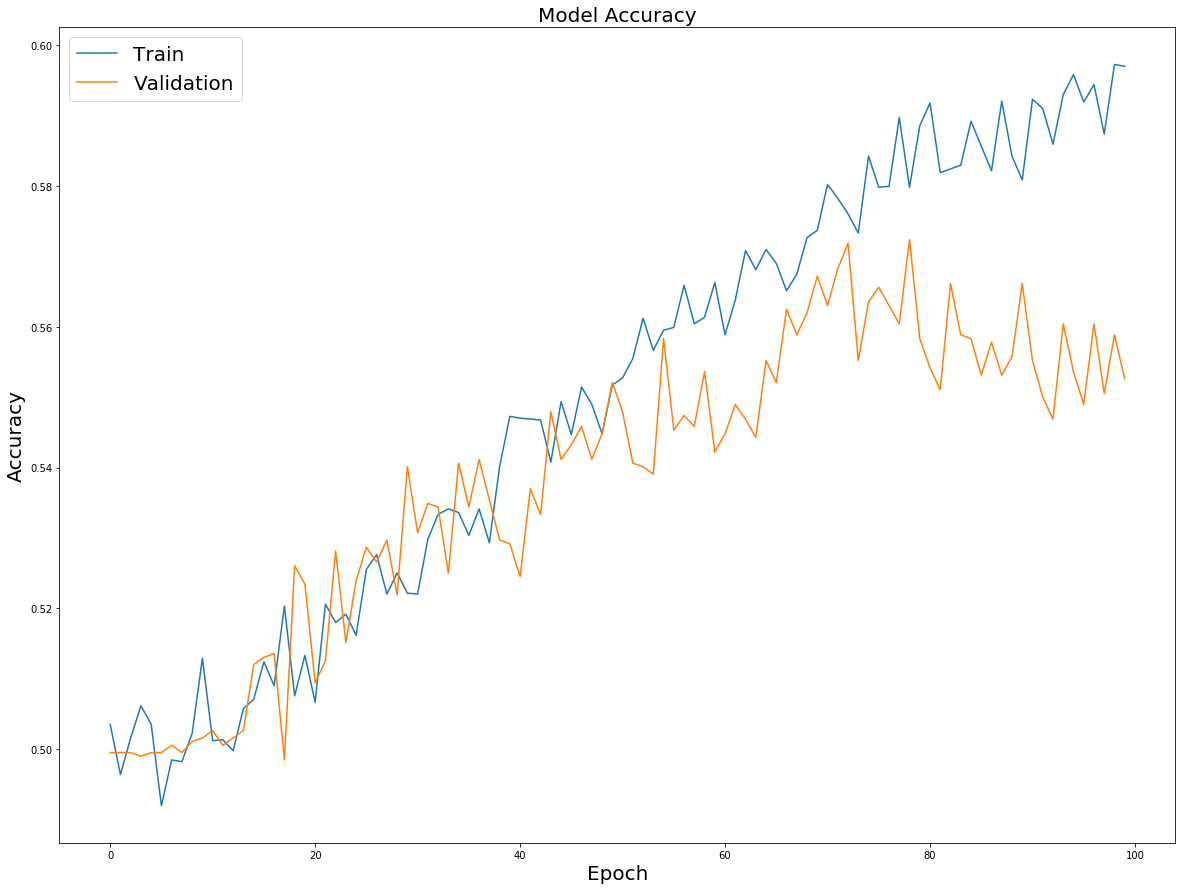

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, we evaluate the model on the test set and plot the results as a confusion matrix.

Confusion matrix:
 [[395 769]
 [351 885]]


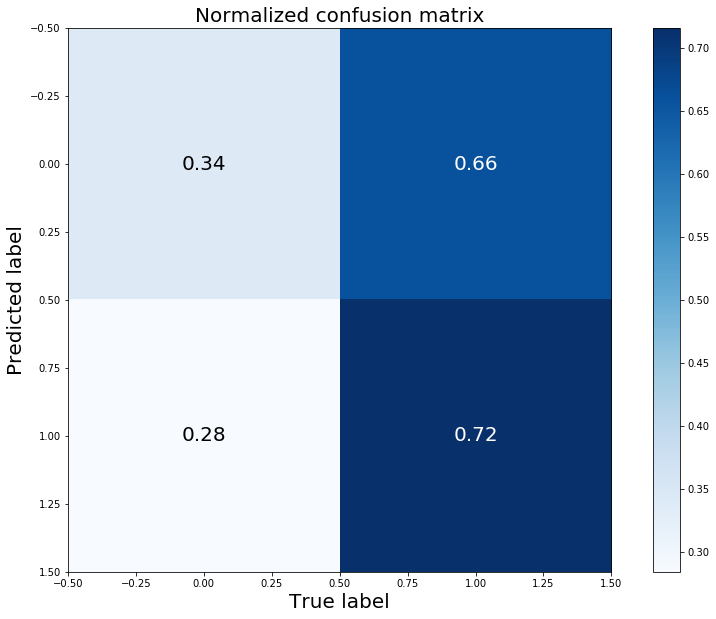

In [100]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(15,10))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
#plt.xticks([0, 1]); plt.yticks([0, 1])
#plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [87]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 53.33%


The accuracy is not fantastic, apparently there is not enough signal in the data, i.e. Neanderthal introgressed regions look very similarly in sense of their sequence to the regions with reduced Neanderthal ancestry. This can have many reasons both biological and technical. One technical artifact can be bad annotation of the Nenanderthal introgressed regions byt Vernot and Akey, we could use David Reich's annotation as an alternative.

Let us now take a step back and simplify the problem. Let us address something simple which should be solvable within the current framework. For example we can try to classify sequences to belong either to gene or intergenic regions.

### Gene vs. Non-Gene Sequence Classification  <a class="anchor" id="Gene-vs.-Non-Gene-Sequence-Classification"></a>

Here we will follow roughy the same line as for Neanderthal introgressed vs. depleted sequence classification and perform a simple "sentiment analysis", i.e. a simple gene vs. non-gene sequence classification. This should be a simple task as genes have start and stop codon regions which should be recognized and learnt by CNN quite easily. We will start with building an annotation file for protein-coding genes. We downloaded RefSeq annotation file from http://genome.ucsc.edu/cgi-bin/hgTables as a text-file and used "genePredToGtf" tool to build the refGene_hg19.gtf gtf-annotation file.

In [107]:
!cut -f9 refGene_hg19.gtf | cut -d ';' -f1 | cut -d ' ' -f2 | uniq | tr -d '\"' > refseq_gene_list_hg19.txt

In [104]:
%load_ext rpy2.ipython

In [108]:
%%R
library("biomaRt")
ensembl <- useMart("ensembl",host="grch37.ensembl.org")
ensembl <- useDataset("hsapiens_gene_ensembl",mart=ensembl)
refseq_genes <- scan("refseq_gene_list_hg19.txt", what = "character")
output <- getBM(attributes=c('hgnc_symbol', 'chromosome_name', 'start_position', 'end_position', 'strand'), 
                filters = c('hgnc_symbol'),values = refseq_genes,mart = ensembl)
head(output)

W1027 11:40:41.391831 139658277726016 callbacks.py:119] R[write to console]: Read 49762 items

W1027 11:40:41.982521 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:40:41.983824 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [>------------------------------]   2% eta: 25s
W1027 11:40:43.002393 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:40:43.003472 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [>------------------------------]   3% eta: 50s
W1027 11:40:43.212183 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:40:43.213459 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [>------------------------------]   4% eta: 42s
W1027 11:40:44.193898 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:40:44.194903 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [=>-----------------------------]   5% eta:  1m
W

W1027 11:40:52.994334 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:40:52.995352 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [===========>-------------------]  38% eta: 19s
W1027 11:40:53.237683 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:40:53.239075 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [===========>-------------------]  39% eta: 18s
W1027 11:40:53.448115 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:40:53.449355 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [===========>-------------------]  40% eta: 18s
W1027 11:40:53.666050 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:40:53.667215 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [============>------------------]  41% eta: 18s
W1027 11:40:53.886385 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:40:53.887

W1027 11:41:03.957709 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [======================>--------]  74% eta:  8s
W1027 11:41:04.355638 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:41:04.356685 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [======================>--------]  75% eta:  8s
W1027 11:41:04.582739 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:41:04.583774 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [=======================>-------]  76% eta:  7s
W1027 11:41:04.798639 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:41:04.799671 139658277726016 callbacks.py:119] R[write to console]: Batch submitting query [=======================>-------]  77% eta:  7s
W1027 11:41:05.022374 139658277726016 callbacks.py:119] R[write to console]: 
W1027 11:41:05.023411 139658277726016 callbacks.py:119] R[write to console]: Batch submitting qu

  hgnc_symbol   chromosome_name start_position end_position strand
1     ABCA11P                 4         419224       467918     -1
2     ABCA11P HG174_HG254_PATCH         425435       474129     -1
3       ACYP2                 2       54197975     54532437      1
4        ADAR                 1      154554538    154600475     -1
5       ADCY1                 7       45613739     45762715      1
6        ADD3                10      111756126    111895323      1


In [110]:
%%R
output_clean <- output[as.character(output$chromosome_name)%in%c(as.character(seq(1:22)),"X","Y"),]
dim(output_clean)

[1] 40965     5


In [111]:
%%R
head(output_clean)

  hgnc_symbol chromosome_name start_position end_position strand
1     ABCA11P               4         419224       467918     -1
3       ACYP2               2       54197975     54532437      1
4        ADAR               1      154554538    154600475     -1
5       ADCY1               7       45613739     45762715      1
6        ADD3              10      111756126    111895323      1
7      ADIPOQ               3      186560463    186576252      1


In [113]:
%%R
output_to_write <- output_clean
output_to_write$hgnc_symbol <- NULL
output_to_write$strand <- NULL
output_to_write$chromosome_name <- paste0("chr",output_to_write$chromosome_name)
write.table(output_to_write, file="gene_coords.txt",col.names=FALSE,row.names=FALSE,quote=FALSE,sep="\t")
gene <- output_to_write
write.table(gene[!duplicated(paste0(gene$V1,":",gene$V2,"-",gene$V3)),],
            file="gene_coords_sorted_unique.txt",col.names = FALSE,row.names = FALSE,
            quote = FALSE,sep = "\t")

We have now removed duplicate genes and end up with 22571 RefSeq hg19 genes, let us have a look at the:

In [32]:
import pandas as pd
Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/SentimentAnalysis/genes/'
gene_coords = pd.read_csv(Path + 'gene_coords.txt', 
                          header=None, sep="\t")
gene_coords.head()

0          1          2
0   chr4     419224     467918
1   chr2   54197975   54532437
2   chr1  154554538  154600475
3   chr7   45613739   45762715
4  chr10  111756126  111895323

In [33]:
gene_coords.shape

(40965, 3)

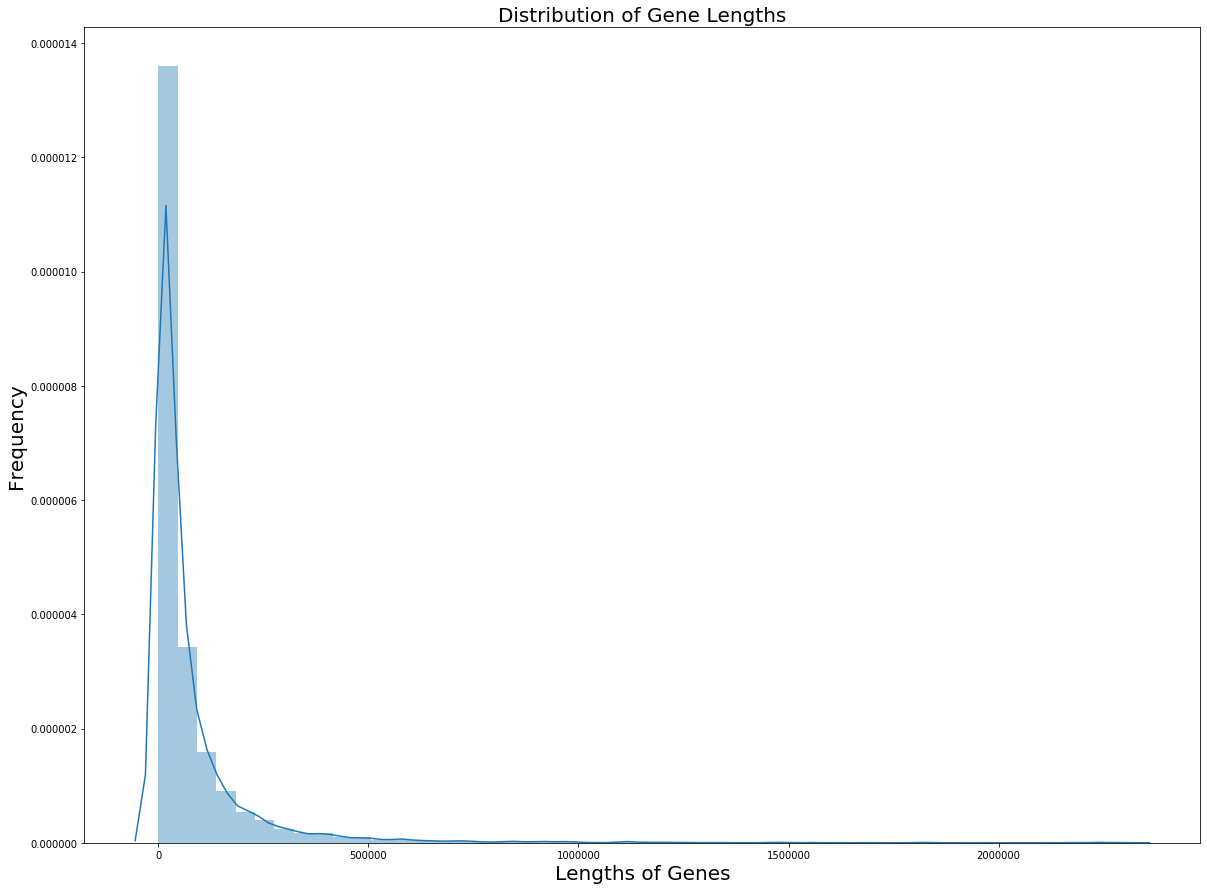

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
gene_lengths = gene_coords.iloc[:, 2]-gene_coords.iloc[:, 1]
sns.distplot(gene_lengths)
plt.title("Distribution of Gene Lengths", fontsize = 20)
plt.xlabel("Lengths of Genes", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

In [35]:
from scipy import stats
print(stats.describe(gene_lengths))

DescribeResult(nobs=40965, minmax=(40, 2304637), mean=76316.16152813377, variance=23479516110.360516, skewness=6.084410282367497, kurtosis=55.65833251525486)


In [7]:
import os
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')
with open('hg19_gene_regions.fa', 'a') as fp:
    for i in range(gene_coords.shape[0]):
        coord = str(str(gene_coords.iloc[i, 0]) + ':' 
                    + str(gene_coords.iloc[i, 1]) + '-' + str(gene_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)

In [8]:
chr_sizes = pd.read_csv("hg19.fa.gz.fai", header = None, sep = "\t")
chr_sizes.head()

0          1          2   3   4
0  chr1  249250621          6  50  51
1  chr2  243199373  254235646  50  51
2  chr3  198022430  502299013  50  51
3  chr4  191154276  704281898  50  51
4  chr5  180915260  899259266  50  51

In [11]:
import numpy as np
chr_list = []
start_list = []
end_list = []
for i in range(gene_coords.shape[0]):
    chr_df = gene_coords[gene_coords[0] == gene_coords[0][i]]
    b1 = chr_df[1][i]
    b2 = chr_df[2][i]
    overlap = True
    while overlap == True:
        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == gene_coords[0][i]].iloc[:,1]))
        reg_end = reg_start + gene_lengths[i]
        for j in range(chr_df.shape[0]):
            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2):
                overlap = True
                break
            else:
                overlap = False
    chr_list.append(gene_coords[0][i])
    start_list.append(reg_start)
    end_list.append(reg_end)
notgene_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
notgene_coords.to_csv("notgene_coords.txt", index = False, header = False, sep = "\t")
notgene_coords.head()

0          1          2
0  chr1  105637281  105639824
1  chr1  191285324  191300767
2  chr1   89567867   89569422
3  chr1   29335024   29336551
4  chr1  195585071  195585988

In [14]:
import os
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')
with open('hg19_notgene_regions.fa', 'a') as fp:
    for i in range(notgene_coords.shape[0]):
        coord = str(str(notgene_coords.iloc[i, 0]) + ':' 
                    + str(notgene_coords.iloc[i, 1]) + '-' + str(notgene_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)

In [15]:
!grep -c N hg19_gene_regions.fa

40243


In [16]:
!grep -c N hg19_notgene_regions.fa

1438514


In [17]:
from Bio import SeqIO
i = 0
for record in SeqIO.parse('hg19_gene_regions.fa', 'fasta'):
    upper_record = record.seq.upper()
    if 'N' in upper_record:
        i = i + 1
print(i)

i = 0
for record in SeqIO.parse('hg19_notgene_regions.fa', 'fasta'):
    upper_record = record.seq.upper()
    if 'N' in upper_record:
        i = i + 1
print(i)

49
1730


In [18]:
from Bio import SeqIO

gene_file = 'hg19_gene_regions.fa'
notgene_file = 'hg19_notgene_regions.fa'
a = 0
i = 0
with open('hg19_gene_clean.fa', 'a') as gene_out, open('hg19_notgene_clean.fa', 'a') as notgene_out:
    for gene, notgene in zip(SeqIO.parse(gene_file, 'fasta'), SeqIO.parse(notgene_file, 'fasta')):
        upper_gene = gene.seq.upper()
        upper_notgene = notgene.seq.upper()
        a = a + 1
        if a%1000 == 0:
            print('Finished ' + str(a) + ' entries')
        if 'N' not in str(upper_gene) and 'N' not in str(upper_notgene):
            gene.seq = upper_gene
            SeqIO.write(gene, gene_out, 'fasta')
            notgene.seq = upper_notgene
            SeqIO.write(notgene, notgene_out, 'fasta')
            i = i + 1
        else:
            continue
print('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to two fasta-files')

Finished 1000 entries
Finished 2000 entries
Finished 3000 entries
Finished 4000 entries
Finished 5000 entries
Finished 6000 entries
Finished 7000 entries
Finished 8000 entries
Finished 9000 entries
Finished 10000 entries
Finished 11000 entries
Finished 12000 entries
Finished 13000 entries
Finished 14000 entries
Finished 15000 entries
Finished 16000 entries
Finished 17000 entries
Finished 18000 entries
Finished 19000 entries
Finished 20000 entries
Finished 21000 entries
Finished 22000 entries
We have processed 22571 entries and written 20797 entries to two fasta-files


In [19]:
!grep -c N hg19_gene_clean.fa

0


In [20]:
!grep -c N hg19_notgene_clean.fa

0


In [6]:
import os
from Bio import SeqIO

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')

gene_file = 'hg19_gene_clean.fa'
notgene_file = 'hg19_notgene_clean.fa'

a = 0
gene_seqs = []
notgene_seqs = []
for gene, notgene in zip(SeqIO.parse(gene_file, 'fasta'), SeqIO.parse(notgene_file, 'fasta')):
    #gene_seqs.append(str(gene.seq)[0:np.min(gene_lengths)])
    #notgene_seqs.append(str(notgene.seq)[0:np.min(notgene_lengths)])
    cut = 100
    if len(str(gene.seq)) < cut or len(str(notgene.seq)) < cut:
        continue
    s_gene = str(gene.seq)[0:cut]
    s_notgene = str(notgene.seq)[0:cut]
    if s_gene.count('A')>0 and s_gene.count('C')>0 and s_gene.count('G')>0 and s_gene.count('T')>0 and \
    s_notgene.count('A')>0 and s_notgene.count('C')>0 and s_notgene.count('G')>0 and s_notgene.count('T')>0:
        gene_seqs.append(s_gene)
        notgene_seqs.append(s_notgene)
    a = a + 1
    if a%10000 == 0:
        print('Finished ' + str(a) + ' entries')

Finished 10000 entries


In [7]:
sequences = gene_seqs + notgene_seqs
len(sequences)

39070

In [8]:
import numpy as np
labels = list(np.ones(len(gene_seqs))) + list(np.zeros(len(notgene_seqs)))
len(labels)

39070

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

# The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature, i.e. only 01 and 1 are present in the matrix
one_hot_encoder = OneHotEncoder()   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold = 40)
#print(input_features.shape)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 GTTAACTTGC ... CCGGGCCTTT
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 1.]]


In [10]:
one_hot_encoder = OneHotEncoder()
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[1. 1. 1. ... 0. 0. 0.]]
One-hot encoded labels:
 [[0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


In [11]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size = 0.2, random_state = 42)

In [12]:
train_features.shape

(31256, 100, 4)

In [13]:
train_labels.shape

(31256, 2)

In [14]:
test_features.shape

(7814, 100, 4)

In [15]:
test_labels.shape

(7814, 2)

In [26]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, Activation
from keras.models import Sequential
from keras.regularizers import l1

import warnings
warnings.filterwarnings('ignore')

model = Sequential()

model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                 input_shape = (train_features.shape[1], 4)))
model.add(Activation("relu"))
model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(8, kernel_initializer = 'he_uniform'))
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Dense(2, activation = 'softmax'))

epochs = 100
lrate = 0.01
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 100, 16)           336       
_________________________________________________________________
activation_13 (Activation)   (None, 100, 16)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 100, 16)           1296      
_________________________________________________________________
activation_14 (Activation)   (None, 100, 16)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 50, 16)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 16)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 800)               0         
__________

In [27]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(train_features, train_labels, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True)

Train on 25004 samples, validate on 6252 samples
Epoch 1/100
25004/25004 [==============================] - 4s 158us/step - loss: 0.6492 - binary_accuracy: 0.5957 - val_loss: 0.5908 - val_binary_accuracy: 0.6483
Epoch 2/100
25004/25004 [==============================] - 3s 138us/step - loss: 0.5926 - binary_accuracy: 0.6835 - val_loss: 0.5460 - val_binary_accuracy: 0.7399
Epoch 3/100
25004/25004 [==============================] - 3s 139us/step - loss: 0.5537 - binary_accuracy: 0.7269 - val_loss: 0.5136 - val_binary_accuracy: 0.7711
Epoch 4/100
25004/25004 [==============================] - 3s 138us/step - loss: 0.5285 - binary_accuracy: 0.7466 - val_loss: 0.4743 - val_binary_accuracy: 0.7937
Epoch 5/100
25004/25004 [==============================] - 3s 139us/step - loss: 0.5140 - binary_accuracy: 0.7598 - val_loss: 0.4660 - val_binary_accuracy: 0.7970
Epoch 6/100
25004/25004 [==============================] - 3s 139us/step - loss: 0.5023 - binary_accuracy: 0.7675 - val_loss: 0.4567 - v

Epoch 51/100
25004/25004 [==============================] - 4s 143us/step - loss: 0.4474 - binary_accuracy: 0.7968 - val_loss: 0.4415 - val_binary_accuracy: 0.8066
Epoch 52/100
25004/25004 [==============================] - 4s 175us/step - loss: 0.4452 - binary_accuracy: 0.7969 - val_loss: 0.4355 - val_binary_accuracy: 0.8119
Epoch 53/100
25004/25004 [==============================] - 4s 142us/step - loss: 0.4436 - binary_accuracy: 0.8008 - val_loss: 0.4395 - val_binary_accuracy: 0.8076
Epoch 54/100
25004/25004 [==============================] - 4s 173us/step - loss: 0.4445 - binary_accuracy: 0.7986 - val_loss: 0.4342 - val_binary_accuracy: 0.8084
Epoch 55/100
25004/25004 [==============================] - 3s 138us/step - loss: 0.4437 - binary_accuracy: 0.7985 - val_loss: 0.4342 - val_binary_accuracy: 0.8068
Epoch 56/100
25004/25004 [==============================] - 4s 176us/step - loss: 0.4394 - binary_accuracy: 0.8001 - val_loss: 0.4376 - val_binary_accuracy: 0.8049
Epoch 57/100
250

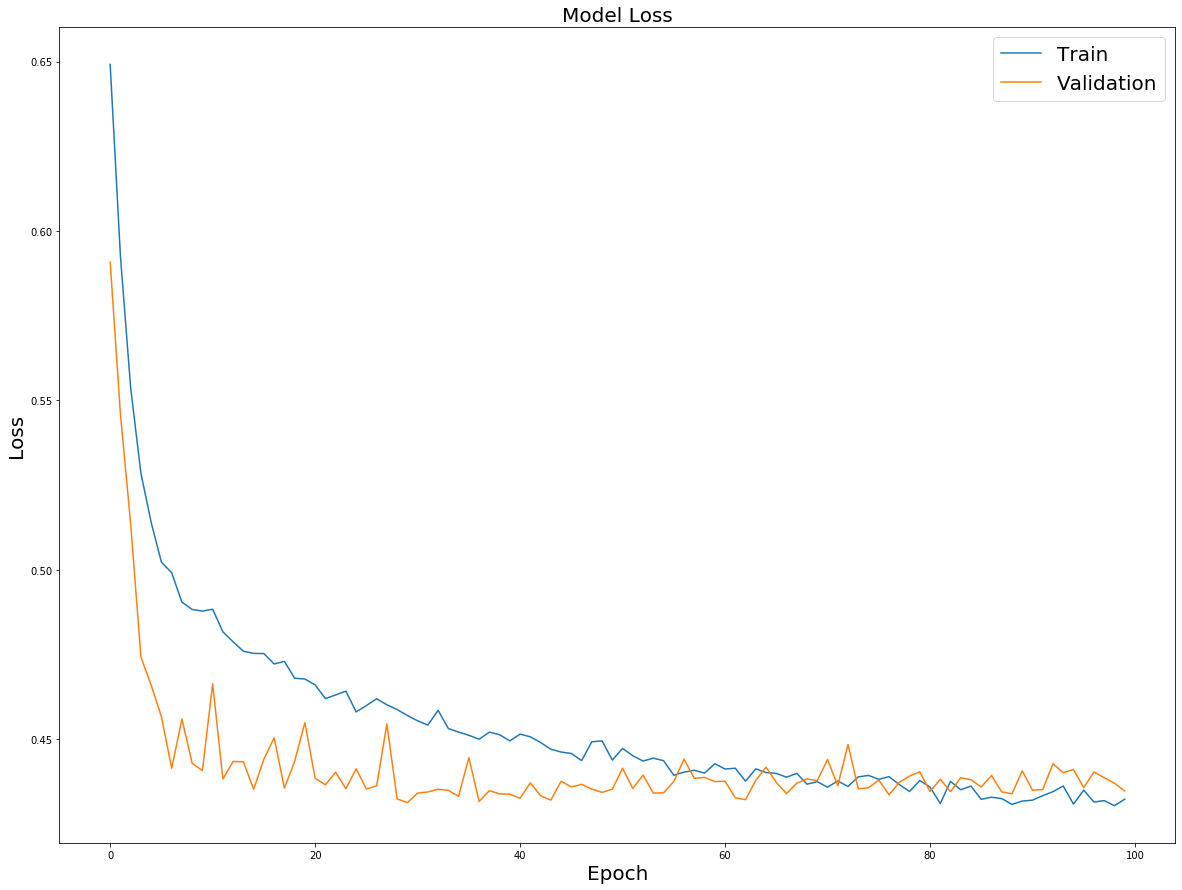

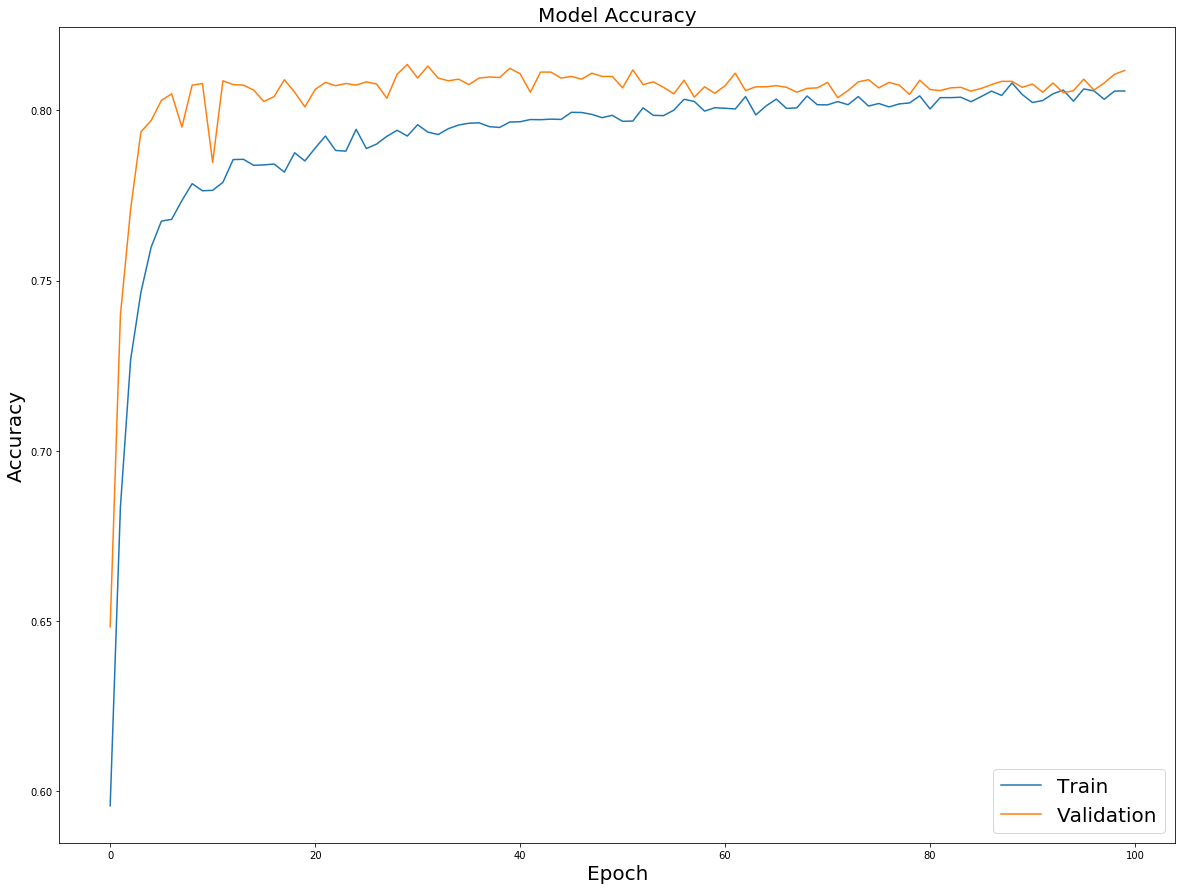

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

Confusion matrix:
 [[3437  479]
 [1099 2799]]


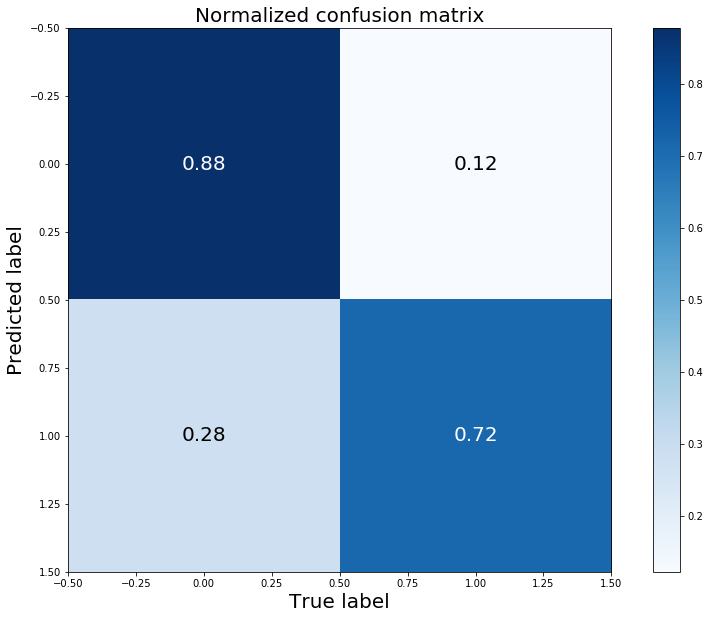

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(15,10))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
#plt.xticks([0, 1]); plt.yticks([0, 1])
#plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [30]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 79.81%


In [20]:
import keras.backend as K

def compute_salient_bases(model, x):
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
    compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
    
    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients([x_value])[0][0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal

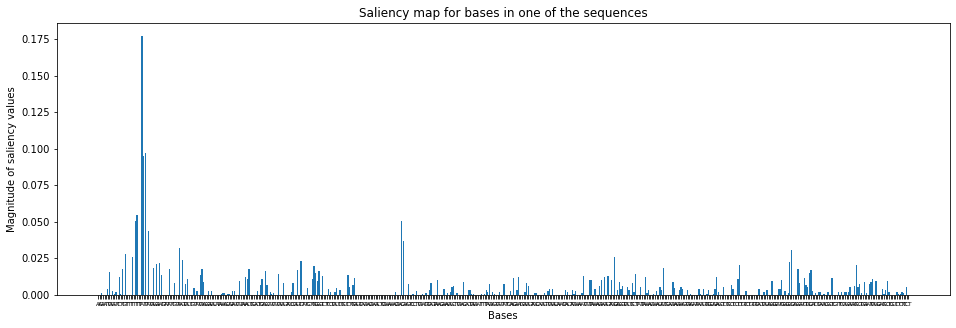

In [52]:
sequence_index = 2
K.set_learning_phase(1) #set learning phase
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
zoom = len(sal)
barlist = plt.bar(np.arange(len(sal[0:zoom])), sal[0:zoom])
#[barlist[i].set_color('C1') for i in range(0,6)]
#[barlist[j].set_color('C1') for j in range(26,32)]
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal[0:zoom])), list(sequences[sequence_index][0:zoom]), size = 6);
plt.title('Saliency map for bases in one of the sequences');
plt.show()

In [38]:
input_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

This looks much much better! The model can distinguish between segments coming from genes and not genes with close to 80% accuracy, which can be probably improved by considering longer stretches of DNA. So one reason this kind of classification did not work for Neanderthal introgressed vs. depleted sequences can be due to the poor callcing / annotation provided by Vernot and Akey in their Science 2014 paper. As a prove that there is something wrong with the introgressed sequence calling from Vernot and Akey 2014, we can calculate how many times their sequences overlap the refseq genes:

In [15]:
%%bash
Path=/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression/1000G_Akey_NeandIntrogression
bedtools intersect -a ./genes/gene_coords.txt -b $Path/all_haplotypes_populations.bed.all | wc -l

15590


and now let us compare this number with how many times their sequences overlap with intergenic regions:

In [16]:
%%bash
Path=/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression/1000G_Akey_NeandIntrogression
bedtools intersect -a ./genes/notgene_coords.txt -b $Path/all_haplotypes_populations.bed.all | wc -l

14958


Here we see that there is at least no enrichment of the sequences in either gene or intergenic regions. In contrast, it looks like the nNeanderthal introgressed sequences seem to be slightly enriched in the gene regions which contradicts one of the main conclusions of David Reich, Nature 2014, where they explicitly state that Neanderthal sequences seem to be depleted from the gene regions, which in evolutionary context can be viewed as Natural Selection did not prefer mixing with Neanderthals for the sake of fitness. Now we will try to use the better annotation from Vernot and Akey, Science 2016, and the annotation from David Reich, Nature 2016, and redo the Neanderthal introgressed vs. depeleted sequence classification.

### Better Annotation of Neanderthal Introgressed Haplotypes  <a class="anchor" id="Better-Annotation-of-Neanderthal-Introgressed-Haplotypes"></a>

We downloaded the merged maps of Neandertal introgression for European + Asian 1000G populations published in Vernot and Akey, Science, 2014 from here https://akeylab.princeton.edu/downloads.html. However, even though the data looked strange (the segments looked too different from the ones from Reich, Nature 2014) and we could not establish any good model distinguishing between Neanderthal introgressed and depleted regions. Next we downloaded the recall data from Vernot et al., Science 2016, from here https://drive.google.com/drive/folders/0B9Pc7_zItMCVWUp6bWtXc2xJVkk. Btw here we have an opposite results of intersecting the introgressed regions with gene and non-gene regions.

In [21]:
%%bash
Path=/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression
bedtools intersect -a ./genes/gene_coords.txt -b $Path/Akey_intr_coords.bed | wc -l

178302


In [22]:
%%bash
Path=/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression
bedtools intersect -a ./genes/notgene_coords.txt -b $Path/Akey_intr_coords.bed | wc -l

188770


Here it is clear that the Neanderthal introgression regions overlap more often with the intergenic regions, i.e. the genes are depleted for Neanderthal introgression showing evolutionary losses in fitness via inbreeding of modern humans with Neanderthals. The same effect we can see with the Neanderthal introgressed regions from David Reich, 2016, after we have selected the most confident regions, i.e. with probability >=90%. Btw, Recih and colleagues provide candidate regions with probability >=50%, but to be on a safe side we select only most confident intervals.

In [19]:
%%bash
Path=/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression
bedtools intersect -a ./genes/gene_coords.txt -b $Path/Reich_intr_coords_high_conf.bed | wc -l

72394


In [20]:
%%bash
Path=/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression
bedtools intersect -a ./genes/notgene_coords.txt -b $Path/Reich_intr_coords_high_conf.bed | wc -l

73045


We can also do something more intelligent and compute the empirical histogram of intersects with randomly constructed non-gene regions. In other words, we are going to create notgene_coords.txt file multiple times and run bedtools to count the number of intersects with the Neanderthal introgressed regions from Vernot and Akey, Science 2016, in this way we obtain an empirical histogram. The goal is to show that the observed number of intersects 178302 is extreme, i.e. located in the 5% tail of the histogram.

In [23]:
chr_sizes = pd.read_csv("hg19.fa.gz.fai", header = None, sep = "\t")
chr_sizes.head()

0          1          2   3   4
0  chr1  249250621          6  50  51
1  chr2  243199373  254235646  50  51
2  chr3  198022430  502299013  50  51
3  chr4  191154276  704281898  50  51
4  chr5  180915260  899259266  50  51

In [29]:
import pandas as pd
Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/genes/'
gene_coords = pd.read_csv(Path + 'gene_coords.txt', header=None, sep="\t")
gene_lengths = gene_coords.iloc[:, 2]-gene_coords.iloc[:, 1]
gene_coords.head()

0          1          2
0   chr4     419224     467918
1   chr2   54197975   54532437
2   chr1  154554538  154600475
3   chr7   45613739   45762715
4  chr10  111756126  111895323

In [116]:
import os
import numpy as np
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')

#perm_n = []
for k in range(100):
    chr_list = []
    start_list = []
    end_list = []
    for i in range(gene_coords.shape[0]):
        chr_df = gene_coords[gene_coords[0] == gene_coords[0][i]]
        b1 = chr_df[1][i]
        b2 = chr_df[2][i]
        overlap = True
        while overlap == True:
            reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == gene_coords[0][i]].iloc[:,1]))
            reg_end = reg_start + gene_lengths[i]
            for j in range(chr_df.shape[0]):
                if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2):
                    overlap = True
                    break
                else:
                    overlap = False
        chr_list.append(gene_coords[0][i])
        start_list.append(reg_start)
        end_list.append(reg_end)
    notgene_rand_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
    notgene_rand_coords.to_csv("temp.txt", index = False, header = False, sep = "\t")

    akey_path = '/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression/'
    with open('n.txt', 'w') as fp:
        subprocess.run(['bedtools', 'intersect', '-a', 'temp.txt', '-b', 
                        akey_path + 'Akey_intr_coords.bed'], stdout = fp)
    akey_n = pd.read_csv('n.txt', header=None, sep="\t")
    print(k, akey_n.shape[0])
    perm_n.append(akey_n.shape[0])

0 184647
1 183123
2 185392
3 181554
4 186290
5 187355
6 188643
7 189258
8 194065
9 186030
10 182065
11 187057
12 189810
13 187555
14 185527
15 187557
16 187103
17 184783
18 187159
19 181950
20 184191
21 186063
22 193518
23 184610
24 187984
25 188551
26 182710
27 188647
28 183398
29 186143
30 190844
31 190008
32 187022
33 190161
34 184268
35 188995
36 187889
37 187704
38 185325
39 184652
40 188878
41 182010
42 193107
43 185832
44 189179
45 186713
46 184271
47 185499
48 185950
49 188265
50 187779
51 185132
52 183413
53 180461
54 188399
55 191272
56 187562
57 186974
58 183863
59 187954
60 189880
61 188227
62 186209
63 191777
64 187242
65 190216
66 188676
67 188573
68 186853
69 187892
70 184691
71 185731
72 185364
73 187485
74 183887
75 185852
76 190875
77 189783
78 186476
79 186308
80 183679
81 185974
82 186142
83 190332
84 185819
85 189634
86 189852
87 184452
88 187546
89 183656
90 190531
91 188758
92 191035
93 188377
94 188030
95 190966
96 187595
97 187195
98 190276
99 186758


In [117]:
%%bash
Path=/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression
bedtools intersect -a temp.txt -b $Path/Akey_intr_coords.bed | wc -l

186758


In [118]:
len(perm_n)

300

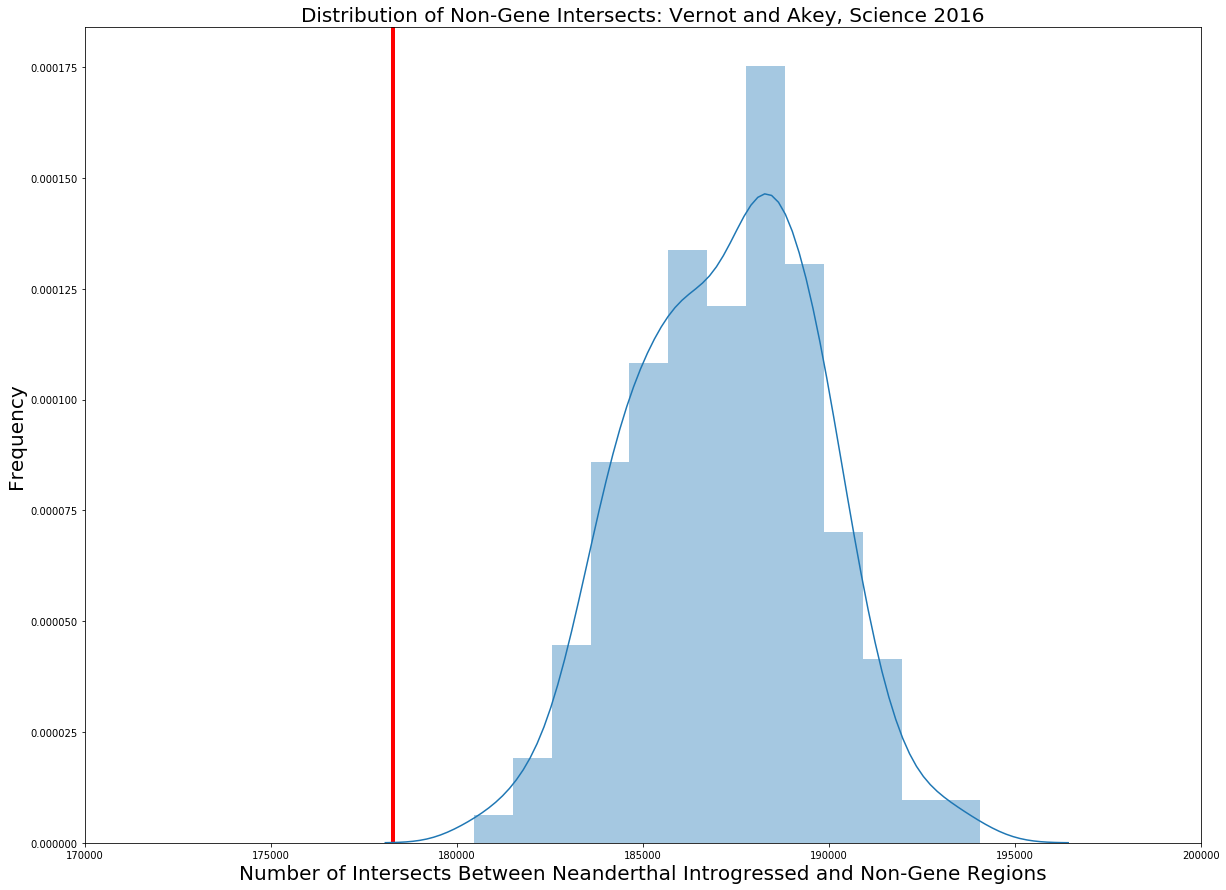

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.xlim([170000,200000])
plt.axvline(x=178302,linewidth=4, color='r')
sns.distplot(perm_n)
plt.title("Distribution of Non-Gene Intersects: Vernot and Akey, Science 2016", fontsize = 20)
plt.xlabel("Number of Intersects Between Neanderthal Introgressed and Non-Gene Regions", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

The right vertical line here is the number of intersects between the Neanderthal introgressed and gene regions. The blue histogram represents the number of intersects between the Neanderthal introgressed and intergenic regions. The intergenic regions have exactly the same length as the Neanderthal introgressed regions and we drew multiple times exactly the same number of intergenic regions as the number of Neandrthal introgressed regions. What we see from this figure is that Neanderthal introgressed regions are significantly enriched in the intergenic regions rather than gene regions. Therefore, for some reason Evolution did not want to keep Neanderthal sequences within genes due to some unknown loss in fitness, but instead Evolution tried to get rid of the Neanderthal sequences from the genes of modern humans.

This was the Neanderthal introgression coordinates from Vernot and Akey, Science 2016. Let us now use the Neanderthal introgression coordinates from David Reich and colleagues from Nature 2016, and check whether we observe the same type of enrichment. Again, the hypothesis is that the number 72394 of intersects between Reich's Neanderthal introgression regions and gene regions is significantly lower than the corresponding typical number of intersects from the intergenic segments.

In [145]:
import os
import numpy as np
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')

#perm_n_reich = []
for k in range(160):
    chr_list = []
    start_list = []
    end_list = []
    for i in range(gene_coords.shape[0]):
        chr_df = gene_coords[gene_coords[0] == gene_coords[0][i]]
        b1 = chr_df[1][i]
        b2 = chr_df[2][i]
        overlap = True
        while overlap == True:
            reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == gene_coords[0][i]].iloc[:,1]))
            reg_end = reg_start + gene_lengths[i]
            for j in range(chr_df.shape[0]):
                if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2):
                    overlap = True
                    break
                else:
                    overlap = False
        chr_list.append(gene_coords[0][i])
        start_list.append(reg_start)
        end_list.append(reg_end)
    notgene_rand_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
    notgene_rand_coords.to_csv("temp.txt", index = False, header = False, sep = "\t")

    reich_path = '/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression/'
    with open('n.txt', 'w') as fp:
        subprocess.run(['bedtools', 'intersect', '-a', 'temp.txt', '-b', 
                        reich_path + 'Reich_intr_coords_high_conf.bed'], stdout = fp)
    reich_n = pd.read_csv('n.txt', header=None, sep="\t")
    print(k, reich_n.shape[0])
    perm_n_reich.append(reich_n.shape[0])

0 72912
1 71643
2 73139
3 73243
4 74231
5 73126
6 74026
7 74136
8 73842
9 72383
10 73263
11 74197
12 73475
13 73098
14 73855
15 73651
16 72424
17 74749
18 74040
19 74835
20 73226
21 72868
22 73243
23 73276
24 73343
25 71596
26 73828
27 74699
28 74428
29 72917
30 73574
31 74503
32 73750
33 74373
34 73723
35 73857
36 73883
37 74381
38 72799
39 71887
40 72141
41 73893
42 72108
43 73711
44 74055
45 72951
46 74067
47 73795
48 73848
49 73471
50 73069
51 73274
52 73440
53 74667
54 74054
55 74523
56 74110
57 72477
58 75500
59 72169
60 73074
61 72678
62 73297
63 74751
64 73622
65 73495
66 73283
67 73035
68 73897
69 73971
70 75283
71 73608
72 74628
73 72562
74 74662
75 72943
76 74023
77 72236
78 74681
79 74010
80 74942
81 75241
82 72939
83 72913
84 74941
85 72323
86 73728
87 72553
88 73606
89 74532
90 73929
91 73488
92 74013
93 73763
94 72755
95 74237
96 74984
97 74475
98 73512
99 72655
100 74653
101 72797
102 73875
103 73788
104 72733
105 73073
106 74141
107 73463
108 73026
109 73761
110 74062


In [146]:
%%bash
Path=/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression
bedtools intersect -a temp.txt -b $Path/Reich_intr_coords_high_conf.bed | wc -l

73491


In [147]:
len(perm_n_reich)

300

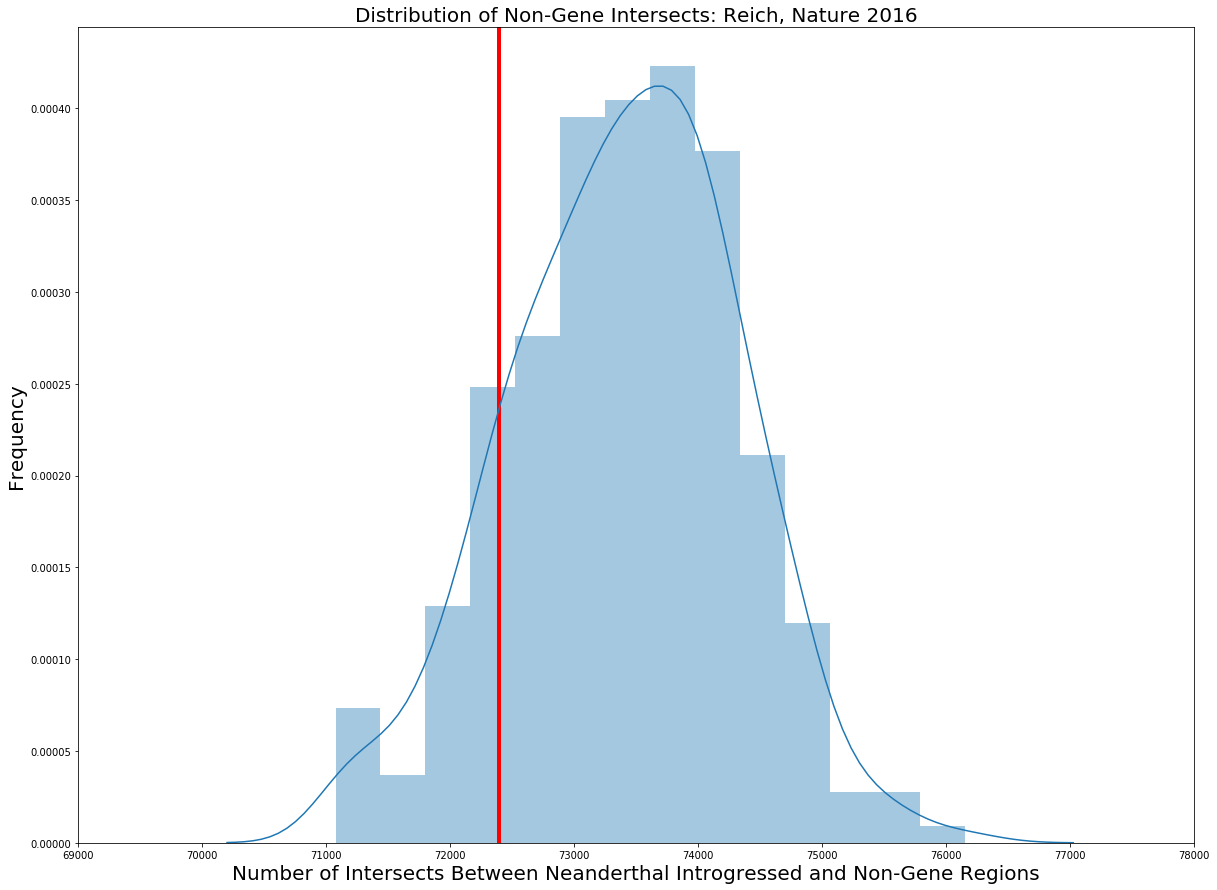

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.xlim([69000,78000])
plt.axvline(x = 72394,linewidth = 4, color = 'r')
sns.distplot(perm_n_reich)
plt.title("Distribution of Non-Gene Intersects: Reich, Nature 2016", fontsize = 20)
plt.xlabel("Number of Intersects Between Neanderthal Introgressed and Non-Gene Regions", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

We can see that Reich introgression segments do not really look to be enriched in the intergenic regions. This is strange, perhaps one could increase the confidence of Neanderthal introgression from 90% to 99%. Anyhow, we will continue for now with Akey's segments.

In [149]:
import pandas as pd
Path = '/home/nikolay/WABI/Misc/AncientDNA/NeandIntrogression/'
intr_coords = pd.read_csv(Path + 'Akey_intr_coords.bed', header = None, sep = "\t")
intr_coords.head()

0        1        2
0  chr1  2903159  2915884
1  chr1  2932446  2972497
2  chr1  2960608  2996556
3  chr1  2960608  2999518
4  chr1  2960608  3001253

In [150]:
intr_coords.shape

(83601, 3)

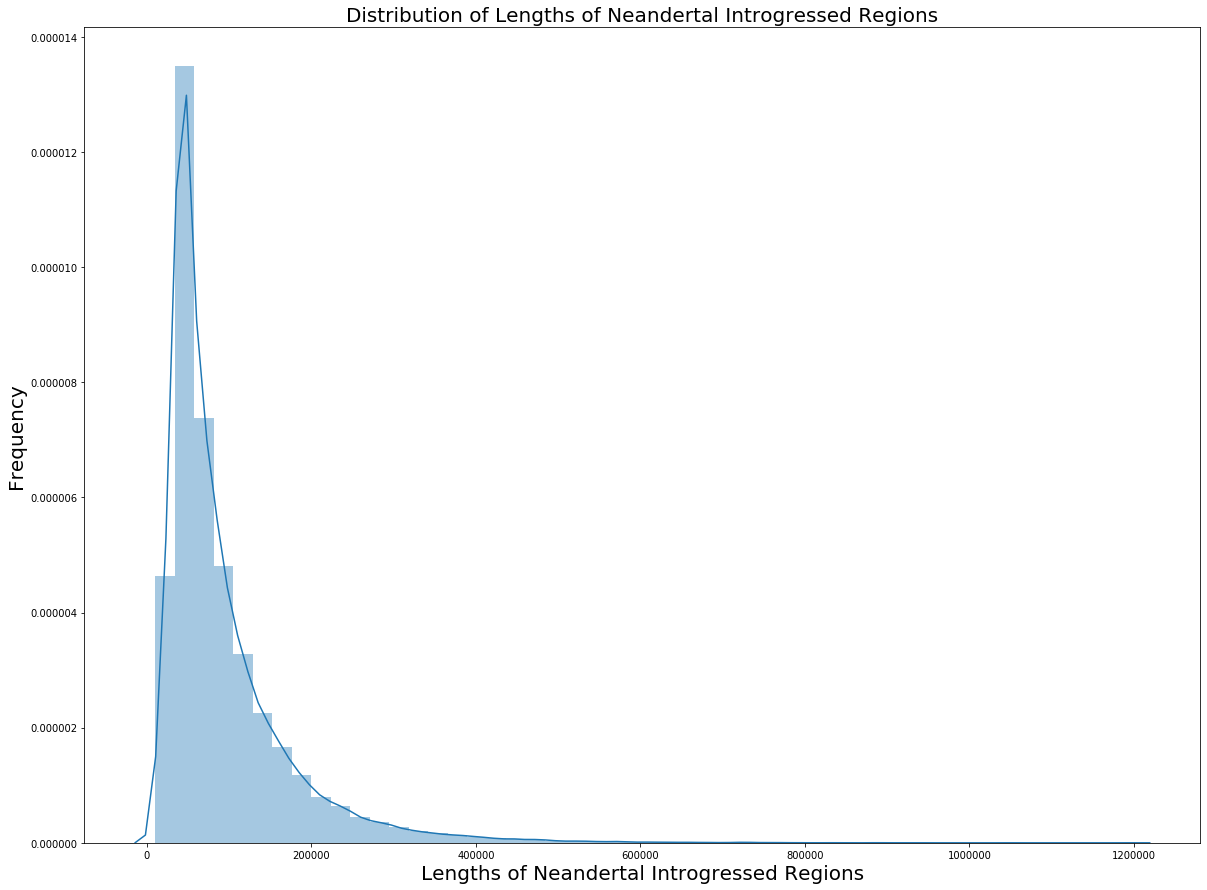

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
intr_lengths = intr_coords.iloc[:, 2]-intr_coords.iloc[:, 1]
sns.distplot(intr_lengths)
plt.title("Distribution of Lengths of Neandertal Introgressed Regions", fontsize = 20)
plt.xlabel("Lengths of Neandertal Introgressed Regions", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

In [152]:
from scipy import stats
print(stats.describe(intr_lengths))

DescribeResult(nobs=83601, minmax=(10002, 1194940), mean=92137.5803877944, variance=6139175379.516866, skewness=2.7095069302166377, kurtosis=11.38558261567325)


In [153]:
import os
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')
a = 0
with open('hg19_introgr_regions.fa', 'a') as fp:
    for i in range(intr_coords.shape[0]):
        coord = str(str(intr_coords.iloc[i, 0]) + ':' 
                    + str(intr_coords.iloc[i, 1]) + '-' + str(intr_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')

Finished 10000 Neanderthal introgressed haplotypes
Finished 20000 Neanderthal introgressed haplotypes
Finished 30000 Neanderthal introgressed haplotypes
Finished 40000 Neanderthal introgressed haplotypes
Finished 50000 Neanderthal introgressed haplotypes
Finished 60000 Neanderthal introgressed haplotypes
Finished 70000 Neanderthal introgressed haplotypes
Finished 80000 Neanderthal introgressed haplotypes


In [154]:
chr_sizes = pd.read_csv("hg19.fa.gz.fai", header=None, sep="\t")
chr_sizes.head()

0          1          2   3   4
0  chr1  249250621          6  50  51
1  chr2  243199373  254235646  50  51
2  chr3  198022430  502299013  50  51
3  chr4  191154276  704281898  50  51
4  chr5  180915260  899259266  50  51

In [155]:
chr_list = []
start_list = []
end_list = []
for i in range(intr_coords.shape[0]):
    chr_df = intr_coords[intr_coords[0] == intr_coords[0][i]]
    b1 = chr_df[1][i]
    b2 = chr_df[2][i]
    overlap = True
    while overlap == True:
        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords[0][i]].iloc[:,1]))
        reg_end = reg_start + intr_lengths[i]
        for j in range(chr_df.shape[0]):
            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2):
                overlap = True
                break
            else:
                overlap = False
    chr_list.append(intr_coords[0][i])
    start_list.append(reg_start)
    end_list.append(reg_end)
depl_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
depl_coords.head()

0          1          2
0  chr1  207924105  207936830
1  chr1  176419320  176459371
2  chr1   95219023   95254971
3  chr1  188361584  188400494
4  chr1   98447184   98487829

In [156]:
import os
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')
with open('hg19_depl_regions.fa', 'a') as fp:
    for i in range(depl_coords.shape[0]):
        coord = str(str(depl_coords.iloc[i, 0]) + ':' 
                    + str(depl_coords.iloc[i, 1]) + '-' + str(depl_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)

In [157]:
!grep -c N hg19_introgr_regions.fa

863


In [158]:
!grep -c N hg19_depl_regions.fa

8195300


In [159]:
from Bio import SeqIO
i = 0
for record in SeqIO.parse('hg19_introgr_regions.fa', 'fasta'):
    upper_record = record.seq.upper()
    if 'N' in upper_record:
        i = i + 1
print(i)

i = 0
for record in SeqIO.parse('hg19_depl_regions.fa', 'fasta'):
    upper_record = record.seq.upper()
    if 'N' in upper_record:
        i = i + 1
print(i)

54
5941


In [160]:
from Bio import SeqIO

intr_file = 'hg19_introgr_regions.fa'
depl_file = 'hg19_depl_regions.fa'
a = 0
i = 0
with open('hg19_introgr_clean.fa', 'a') as intr_out, open('hg19_depl_clean.fa', 'a') as depl_out:
    for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
        upper_intr = intr.seq.upper()
        upper_depl = depl.seq.upper()
        a = a + 1
        if a%1000 == 0:
            print('Finished ' + str(a) + ' entries')
        if 'N' not in str(upper_intr) and 'N' not in str(upper_depl):
            intr.seq = upper_intr
            SeqIO.write(intr, intr_out, 'fasta')
            depl.seq = upper_depl
            SeqIO.write(depl, depl_out, 'fasta')
            i = i + 1
        else:
            continue
print('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to two fasta-files')

Finished 1000 entries
Finished 2000 entries
Finished 3000 entries
Finished 4000 entries
Finished 5000 entries
Finished 6000 entries
Finished 7000 entries
Finished 8000 entries
Finished 9000 entries
Finished 10000 entries
Finished 11000 entries
Finished 12000 entries
Finished 13000 entries
Finished 14000 entries
Finished 15000 entries
Finished 16000 entries
Finished 17000 entries
Finished 18000 entries
Finished 19000 entries
Finished 20000 entries
Finished 21000 entries
Finished 22000 entries
Finished 23000 entries
Finished 24000 entries
Finished 25000 entries
Finished 26000 entries
Finished 27000 entries
Finished 28000 entries
Finished 29000 entries
Finished 30000 entries
Finished 31000 entries
Finished 32000 entries
Finished 33000 entries
Finished 34000 entries
Finished 35000 entries
Finished 36000 entries
Finished 37000 entries
Finished 38000 entries
Finished 39000 entries
Finished 40000 entries
Finished 41000 entries
Finished 42000 entries
Finished 43000 entries
Finished 44000 entri

In [161]:
!grep -c N hg19_introgr_clean.fa

0


In [162]:
!grep -c N hg19_depl_clean.fa

0


Now everything is ready for Neanderthal introgression vs. depleted regions classification. We will read the two clean fasta-files with the sequences of introgressed and depeleted regions, convert them to one-hot encoded representation and run a Convolutional Neural Network (CNN) classifier.

In [1]:
import os
from Bio import SeqIO

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')

intr_file = 'hg19_introgr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

a = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    #intr_seqs.append(str(intr.seq)[0:np.min(depl_lengths)])
    #depl_seqs.append(str(depl.seq)[0:np.min(depl_lengths)])
    s_intr = str(intr.seq)[0:100]
    s_depl = str(depl.seq)[0:100]
    if s_intr.count('A')>0 and s_intr.count('C')>0 and s_intr.count('G')>0 and s_intr.count('T')>0 and \
    s_depl.count('A')>0 and s_depl.count('C')>0 and s_depl.count('G')>0 and s_depl.count('T')>0:
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
    a = a + 1
    if a%10000 == 0:
        print('Finished ' + str(a) + ' entries')

Finished 10000 entries
Finished 20000 entries
Finished 30000 entries
Finished 40000 entries
Finished 50000 entries
Finished 60000 entries
Finished 70000 entries


In [2]:
sequences = intr_seqs + depl_seqs
len(sequences)

155062

In [3]:
import numpy as np
labels = list(np.ones(len(intr_seqs))) + list(np.zeros(len(depl_seqs)))
len(labels)

155062

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

# The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature, i.e. only 01 and 1 are present in the matrix
one_hot_encoder = OneHotEncoder()   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold = 40)
#print(input_features.shape)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 AATGACATTA ... GCCTCAGCTG
One hot encoding of Sequence #1:
 [[1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 1. 0.]]


In [5]:
input_features.shape

(155062, 100, 4)

In [6]:
one_hot_encoder = OneHotEncoder()
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[1. 1. 1. ... 0. 0. 0.]]
One-hot encoded labels:
 [[0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


In [7]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size = 0.2, random_state = 42)

In [8]:
train_features.shape

(124049, 100, 4)

In [9]:
train_labels.shape

(124049, 2)

In [10]:
test_features.shape

(31013, 100, 4)

In [11]:
test_labels.shape

(31013, 2)

In [13]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, Activation
from keras.models import Sequential
from keras.regularizers import l1

import warnings
warnings.filterwarnings('ignore')

model = Sequential()

model.add(Conv1D(filters = 64, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                 input_shape = (train_features.shape[1], 4)))
model.add(Activation("relu"))
model.add(Conv1D(filters = 64, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(16, kernel_initializer = 'he_uniform'))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation = 'softmax'))

epochs = 100
lrate = 0.01
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 100, 64)           1344      
_________________________________________________________________
activation_4 (Activation)    (None, 100, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 64)           20544     
_________________________________________________________________
activation_5 (Activation)    (None, 100, 64)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
__________

In [14]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(train_features, train_labels, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 128, shuffle = True)

Train on 99239 samples, validate on 24810 samples
Epoch 1/100
99239/99239 [==============================] - 32s 325us/step - loss: 0.6936 - binary_accuracy: 0.5016 - val_loss: 0.6932 - val_binary_accuracy: 0.4966
Epoch 2/100
99239/99239 [==============================] - 33s 334us/step - loss: 0.6929 - binary_accuracy: 0.5077 - val_loss: 0.6921 - val_binary_accuracy: 0.5140
Epoch 3/100
99239/99239 [==============================] - 35s 352us/step - loss: 0.6912 - binary_accuracy: 0.5217 - val_loss: 0.6881 - val_binary_accuracy: 0.5509
Epoch 4/100
99239/99239 [==============================] - 36s 366us/step - loss: 0.6845 - binary_accuracy: 0.5471 - val_loss: 0.6796 - val_binary_accuracy: 0.5737
Epoch 5/100
99239/99239 [==============================] - 36s 364us/step - loss: 0.6754 - binary_accuracy: 0.5694 - val_loss: 0.6730 - val_binary_accuracy: 0.5806
Epoch 6/100
99239/99239 [==============================] - 38s 380us/step - loss: 0.6674 - binary_accuracy: 0.5845 - val_loss: 0.6

Epoch 100/100
99239/99239 [==============================] - 33s 330us/step - loss: 0.3641 - binary_accuracy: 0.8201 - val_loss: 0.6791 - val_binary_accuracy: 0.6944


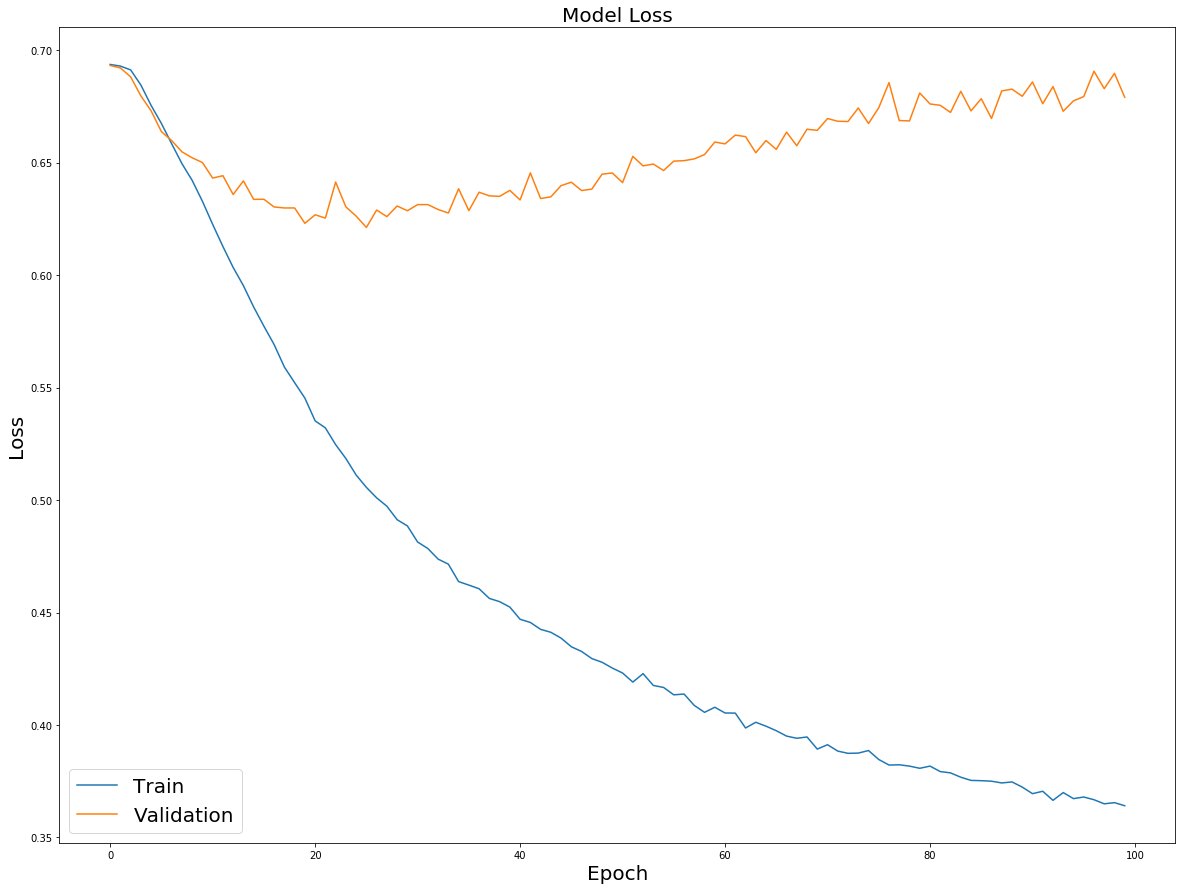

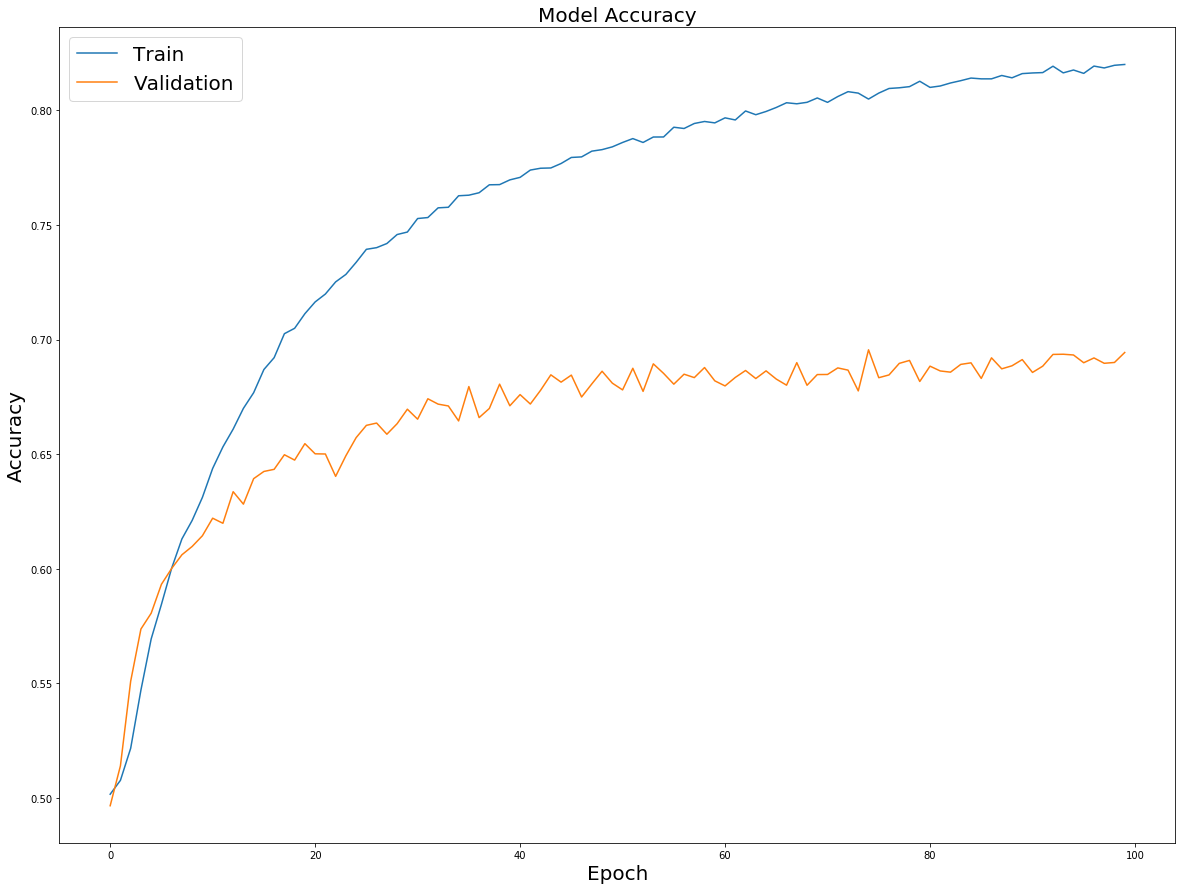

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

Confusion matrix:
 [[ 9700  5954]
 [ 3703 11656]]


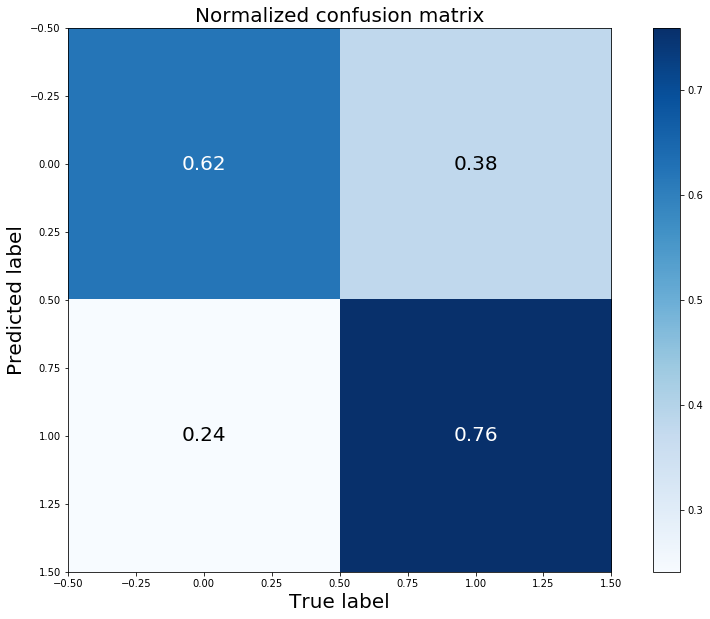

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(15,10))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
#plt.xticks([0, 1]); plt.yticks([0, 1])
#plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [18]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 68.86%


The accuracy looks better now but still not fantastic. Perhaps some tricks from the Natural Language Processing (NLP) and word embeddings might help to increase the accuracy of classification.

### Some Temp Computations  <a class="anchor" id="Some-Temp-Computations"></a>

Here we will try to include the Word Embedding layers in the Convolutional Neural Network (CNN) in order to perform dimensionality reduction, increase accuracy of classification and visualize the low-dimensional Word Embeddings.

In [113]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

docs = ['well done', 'good work', 'great effort', 'nice work', 'excellent', 'weak', 'poor effort', 
        'not good', 'poor work', 'could have done better']
labels = array([1,1,1,1,1,0,0,0,0,0])

In [114]:
sentences = [d.split(' ') for d in docs]
print(sentences)

[['well', 'done'], ['good', 'work'], ['great', 'effort'], ['nice', 'work'], ['excellent'], ['weak'], ['poor', 'effort'], ['not', 'good'], ['poor', 'work'], ['could', 'have', 'done', 'better']]


In [115]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec
model = Word2Vec(sentences, min_count = 1)
print(model)
words = list(model.wv.vocab)
print(words)
print(model['work'])

W1104 10:29:01.687931 140426307450688 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


Word2Vec(vocab=14, size=100, alpha=0.025)
['well', 'done', 'good', 'work', 'great', 'effort', 'nice', 'excellent', 'weak', 'poor', 'not', 'could', 'have', 'better']
[-0.00282436  0.00136096  0.00049871 ... -0.00405598  0.00144478
 -0.00363551]


In [118]:
my_labels = list(np.ones(8)) + list(np.zeros(6))

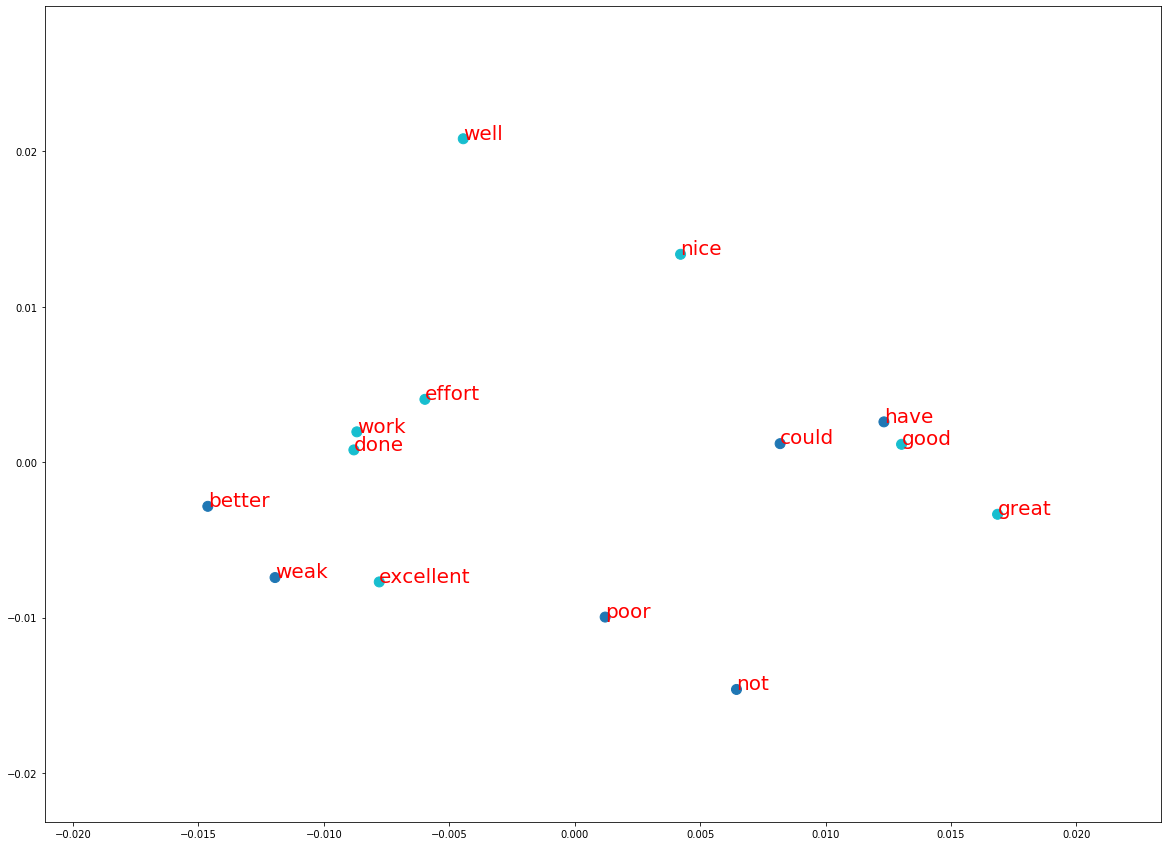

In [119]:
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.figure(figsize=(20,15))
plt.scatter(result[:, 0], result[:, 1], c = my_labels, s = 100, cmap = 'tab10')
words = list(model.wv.vocab)
for i, word in enumerate(words):
    #plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize = 20)
    plt.text(result[i, 0], result[i, 1], word, fontsize = 20, c = 'red')
plt.show()

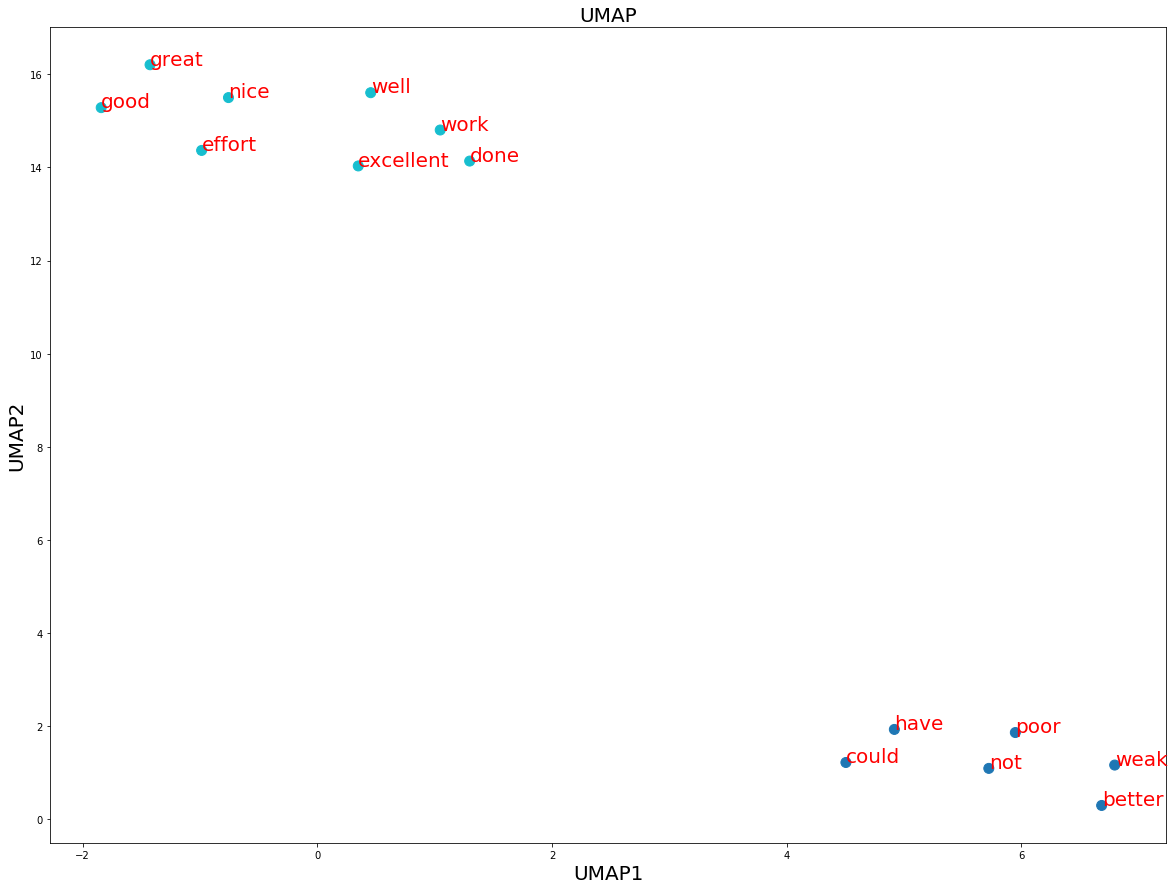

In [122]:
from umap import UMAP
import matplotlib.pyplot as plt
X = model[model.wv.vocab]
umap_model = UMAP(n_neighbors = 5, min_dist = 0.5, n_components = 2)
umap = umap_model.fit_transform(X, y = my_labels)
plt.figure(figsize=(20,15))
plt.scatter(umap[:, 0], umap[:, 1], c = my_labels, s = 100, cmap = 'tab10')
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.text(umap[i, 0], umap[i, 1], word, fontsize = 20, c = 'red')
plt.show()

In [33]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)
# summarize what was learned
print(t.word_counts)
print(t.document_count)
print(t.word_index)
print(t.word_docs)
# integer encode documents
encoded_docs = t.texts_to_matrix(docs, mode = 'count')
print(encoded_docs)
encoded_docs.shape

OrderedDict([('well', 1), ('done', 2), ('good', 2), ('work', 3), ('great', 1), ('effort', 2), ('nice', 1), ('excellent', 1), ('weak', 1), ('poor', 2), ('not', 1), ('could', 1), ('have', 1), ('better', 1)])
10
{'work': 1, 'done': 2, 'good': 3, 'effort': 4, 'poor': 5, 'well': 6, 'great': 7, 'nice': 8, 'excellent': 9, 'weak': 10, 'not': 11, 'could': 12, 'have': 13, 'better': 14}
defaultdict(<class 'int'>, {'done': 2, 'well': 1, 'work': 3, 'good': 2, 'effort': 2, 'great': 1, 'nice': 1, 'excellent': 1, 'weak': 1, 'poor': 2, 'not': 1, 'have': 1, 'better': 1, 'could': 1})
[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 1. 1.]]


(10, 15)

In [47]:
encoded_docs[9]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])

In [125]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])

In [126]:
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)

[[29, 7], [4, 4], [7, 22], [2, 4], [37], [7], [40, 22], [19, 4], [40, 4], [36, 14, 7, 1]]


In [127]:
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[29  7  0  0]
 [ 4  4  0  0]
 [ 7 22  0  0]
 [ 2  4  0  0]
 [37  0  0  0]
 [ 7  0  0  0]
 [40 22  0  0]
 [19  4  0  0]
 [40  4  0  0]
 [36 14  7  1]]


In [137]:
padded_docs = t.texts_to_matrix(docs, mode = 'count')
print(padded_docs)
print(padded_docs.shape)
max_length = padded_docs.shape[1]
vocab_size = padded_docs.shape[1]

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 1. 1.]]
(10, 15)


In [142]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 15, 8)             120       
_________________________________________________________________
flatten_8 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 121       
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________
None


In [143]:
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=2)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/50
 - 0s - loss: 0.6947 - acc: 0.5000
Epoch 2/50
 - 0s - loss: 0.6944 - acc: 0.5000
Epoch 3/50
 - 0s - loss: 0.6941 - acc: 0.5000
Epoch 4/50
 - 0s - loss: 0.6937 - acc: 0.5000
Epoch 5/50
 - 0s - loss: 0.6934 - acc: 0.5000
Epoch 6/50
 - 0s - loss: 0.6930 - acc: 0.5000
Epoch 7/50
 - 0s - loss: 0.6926 - acc: 0.5000
Epoch 8/50
 - 0s - loss: 0.6922 - acc: 0.5000
Epoch 9/50
 - 0s - loss: 0.6918 - acc: 0.6000
Epoch 10/50
 - 0s - loss: 0.6914 - acc: 0.6000
Epoch 11/50
 - 0s - loss: 0.6910 - acc: 0.6000
Epoch 12/50
 - 0s - loss: 0.6906 - acc: 0.6000
Epoch 13/50
 - 0s - loss: 0.6902 - acc: 0.6000
Epoch 14/50
 - 0s - loss: 0.6897 - acc: 0.6000
Epoch 15/50
 - 0s - loss: 0.6893 - acc: 0.6000
Epoch 16/50
 - 0s - loss: 0.6888 - acc: 0.6000
Epoch 17/50
 - 0s - loss: 0.6884 - acc: 0.6000
Epoch 18/50
 - 0s - loss: 0.6879 - acc: 0.6000
Epoch 19/50
 - 0s - loss: 0.6874 - acc: 0.6000
Epoch 20/50
 - 0s - loss: 0.6869 - acc: 0.6000
Epoch 21/50
 - 0s - loss: 0.6864 - acc: 0.6000
Epoch 22/50
 - 0s - lo

Now we will do a simple sentiment analysis using the IMDB reviews. The Movie Review Data is a collection of movie reviews retrieved from the imdb.com website in the early 2000s by Bo Pang and Lillian Lee. The reviews were collected and made available as part of their research on natural language processing. The dataset is comprised of 1,000 positive and 1,000 negative movie reviews drawn from an archive of the rec.arts.movies.reviews newsgroup hosted at imdb.com.

In [2]:
from string import punctuation
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import os
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')

from nltk.corpus import stopwords
import string
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	return tokens
 
# load the document
filename = 'txt_sentoken/pos/cv000_29590.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print(tokens[0:20])

['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'theyre', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world']


In [3]:
stop_words = list(set(stopwords.words('english')))
stop_words[0:5]

['more', 'theirs', 'because', 'how', 'her']

In [4]:
table = str.maketrans('', '', string.punctuation)
print(string.punctuation)
'book,#$'.translate(table)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


'book'

In [5]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
	# load doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# update counts
	vocab.update(tokens)
 
# load all docs in a directory
def process_docs(directory, vocab, is_trian):
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip any reviews in the test set
		if is_trian and filename.startswith('cv9'):
			continue
		if not is_trian and not filename.startswith('cv9'):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# add doc to vocab
		add_doc_to_vocab(path, vocab)
 
# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('txt_sentoken/neg', vocab, True)
process_docs('txt_sentoken/pos', vocab, True)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))

44276
[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('bad', 1248), ('could', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]


In [6]:
# keep tokens with a min occurrence
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))

25767


In [7]:
# save list to file
def save_list(lines, filename):
	# convert lines to a single blob of text
	data = '\n'.join(lines)
	# open file
	file = open(filename, 'w')
	# write text
	file.write(data)
	# close file
	file.close()
 
# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

In [8]:
from string import punctuation
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# turn a doc into clean tokens
def clean_doc(doc, vocab):
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', punctuation)
	tokens = [w.translate(table) for w in tokens]
	# filter out tokens not in vocab
	tokens = [w for w in tokens if w in vocab]
	tokens = ' '.join(tokens)
	return tokens
 
# load all docs in a directory
def process_docs(directory, vocab, is_trian):
	documents = list()
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip any reviews in the test set
		if is_trian and filename.startswith('cv9'):
			continue
		if not is_trian and not filename.startswith('cv9'):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# load the doc
		doc = load_doc(path)
		# clean doc
		tokens = clean_doc(doc, vocab)
		# add to list
		documents.append(tokens)
	return documents
 
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
 
# load all training reviews
positive_docs = process_docs('txt_sentoken/pos', vocab, True)
negative_docs = process_docs('txt_sentoken/neg', vocab, True)
train_docs = negative_docs + positive_docs

In [12]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)
 
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(train_docs)
# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define training labels
ytrain = array([0 for _ in range(900)] + [1 for _ in range(900)])

In [20]:
len(encoded_docs[0])

310

In [22]:
max_length

1317

In [24]:
Xtrain.shape

(1800, 1317)

In [25]:
# load all test reviews
positive_docs = process_docs('txt_sentoken/pos', vocab, False)
negative_docs = process_docs('txt_sentoken/neg', vocab, False)
test_docs = negative_docs + positive_docs
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define test labels
ytest = array([0 for _ in range(100)] + [1 for _ in range(100)])

In [26]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

25768

In [28]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1317, 100)         2576800   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1310, 32)          25632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 655, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20960)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                209610    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 2,812,053
Trainable params: 2,812,053
Non-trainable params: 0
_________________________________________________________________


In [30]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=1)
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Epoch 1/10
1800/1800 [==============================] - 10s 5ms/step - loss: 0.1128 - acc: 0.9728
Epoch 2/10
1800/1800 [==============================] - 10s 6ms/step - loss: 0.0124 - acc: 1.0000
Epoch 3/10
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0023 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 10s 6ms/step - loss: 7.2066e-04 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 10s 6ms/step - loss: 4.6669e-04 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 10s 6ms/step - loss: 3.4066e-04 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 11s 6ms/step - loss: 2.4853e-04 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 10s 6ms/step - loss: 1.8236e-04 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 10s 6ms/step - loss: 1.3405e-04 - acc: 1.0000
Epoch 10/10
1800/1800 [==============================] - 10s 6ms/step - loss: 1.1555e-04 - acc

### Use NLP and Word Embeddings  <a class="anchor" id="Use-NLP-and-Word-Embeddings"></a>

Here we will try to include the Word Embedding layers in the Convolutional Neural Network (CNN) in order to perform dimensionality reduction, increase accuracy of classification and visualize the low-dimensional Word Embeddings. We start with reading the sequences of Neanderthal introgressed and depleted regions and merging them together for later classification.

In [1]:
import os
from Bio import SeqIO
from Bio.Seq import Seq

#os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/')
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/genes/')

#intr_file = 'hg19_introgr_clean.fa'
#depl_file = 'hg19_depl_clean.fa'

intr_file = 'hg19_gene_clean.fa'
depl_file = 'hg19_notgene_clean.fa'


e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    cutoff = 100
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    
    intr_seqs.append(my_intr_seq)
    #my_intr_reverse_compliment_seq = str(Seq(my_intr_seq).reverse_complement())
    #intr_seqs.append(my_intr_reverse_compliment_seq)
    
    depl_seqs.append(my_depl_seq)
    #my_depl_reverse_compliment_seq = str(Seq(my_depl_seq).reverse_complement())
    #depl_seqs.append(my_depl_reverse_compliment_seq)
    
    '''
    step = 100; jump = 1500; a = 0; b = step
    for j in range(5):
        s_intr = str(intr.seq)[a:b]
        s_depl = str(depl.seq)[a:b]
        if s_intr.count('A')>0 and s_intr.count('C')>0 and s_intr.count('G')>0 and s_intr.count('T')>0 and \
        s_depl.count('A')>0 and s_depl.count('C')>0 and s_depl.count('G')>0 and s_depl.count('T')>0:
            intr_seqs.append(s_intr)
            depl_seqs.append(s_depl)
        a = a + jump
        b = a + step
    '''
    e = e + 1
    if e%10000 == 0:
        print('Finished ' + str(e) + ' entries')

Finished 10000 entries
Finished 20000 entries
Finished 30000 entries


In [2]:
sequences = intr_seqs + depl_seqs
len(sequences)

75706

In [3]:
sequences[0:10]

['AAAATGTGCTCAGTGTTAACTTTATTGATAATAACCAAAAACAAACCTAATATTTTATGATTTTAAAATTATTTTTAAGCACAAAATAGACCCATGTTGG',
 'ACCCCTCTCCGGGCTCCGCCTCCTCCGCGTCTTCGTCGCCCTGCGGCCGCTGGCGGCCCGTCGCCCTCGGACCGATCGCTAGGCCCCCTTCCCTGGCCGG',
 'AAGAATTCAGATTCTTGTTTTTTTTTTATTTATGAGGAATGTATATTGTTAAGTCACTGTTATCAAGGGACACATAAAAGCAGAATCATAAAACTGGACT',
 'GTTCCACTGTGCACGGTGGGGAAACTGAGGCTCGGAGGGGACAAGGAAGGTACTCGAGGTCACGCGGCTCCTCCGGCGGGCGGGAACGCAGGACGCGGAG',
 'ACTTTAGTTTCAGTAATCATTGTGAATGAGACTGTGAGAAACTTGGCTTGTTCAGAAGATACTGTGCATAAGACATGAGGTAAGTCATTAATTTCTTAGC',
 'AGGCTGTTGAGGCTGGGCCATCTCCTCCTCACTTCCATTCTGACTGCAGTCTGTGGTTCTGATTCCATACCAGAGGGTAAGAGCAATTCTGTGAAGTTCC',
 'TTGCTAATGATGGTCACTTCCTCTCTTAAAACAGAACCAGGACCCTGAATCATATTTTCCAACTTCTAATCCAGGGACTTTTCTCACTGTGCTCACTGCT',
 'TTTTTTTTTTTTTTTTTTTTTTTTGGAGACGGAGTCTCACTCTGTCACCCAGGCTGGAGTGTAGTGGCATGACCTCAGCTCACTGCAACCTCCACCTCCC',
 'CCCGTCCCCGGCGCGGCCCGCGCGCTCCTCCGCCGCCTCTCGCCTGCGCCATGGCCGGCCGGTCCCACCCGGGCCCGCTGCGGCCGCTGCTGCCGCTCCT',
 'CCACCCTGGCGATGGCTCCCTGGTCCTACTTTCTCTCTCAAACTGGCTTTTTC

Suppose the sequences in the list above are different texts. It is natural to consider k-mers as words of those texts. Different sequences can share the same k-mers indicating that the same words can be used in different texts. However, there are words / k-mers that are specific for certain texts / sequences, or their number can say something about the topic of the text / biology of the sequence. Here we are going to split each sequence into k-mers and construct **sentences** which represent lists of words / k-mers.

In [4]:
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

In [5]:
print('Building Neanderthal introgressed sequences')
intr_sentences = []
for i in range(len(intr_seqs)):
    intr_sentences.append(getKmers(intr_seqs[i], 5))

print('Building Neanderthal depleted sequences')
depl_sentences = []
for i in range(len(depl_seqs)):
    depl_sentences.append(getKmers(depl_seqs[i], 5))

print('Building merged Neanderthal introgressed and depleted sequences')
sentences = []
for i in range(len(sequences)):
    sentences.append(getKmers(sequences[i], 5))

Building Neanderthal introgressed sequences
Building Neanderthal depleted sequences
Building merged Neanderthal introgressed and depleted sequences


In [6]:
sentences[0][0:5]

['AAAAT', 'AAATG', 'AATGT', 'ATGTG', 'TGTGC']

The words / k-mers provide a vocabulary, we will determine its size later. We can also use the **Counter** class for an efficient counting of the words as well as displaying and making a barplot of the most common words for the merged Neanderthal introgressed and depleted regions. 

In [7]:
from collections import Counter
Counter([item for sublist in sentences for item in sublist]).most_common(10)

[('TTTTT', 43199),
 ('AAAAA', 39226),
 ('TTTAT', 27011),
 ('ATTTT', 26696),
 ('TTATT', 25863),
 ('TTTTA', 25439),
 ('AAAAT', 24500),
 ('TATTT', 24042),
 ('TAAAA', 20875),
 ('AAATA', 20449)]

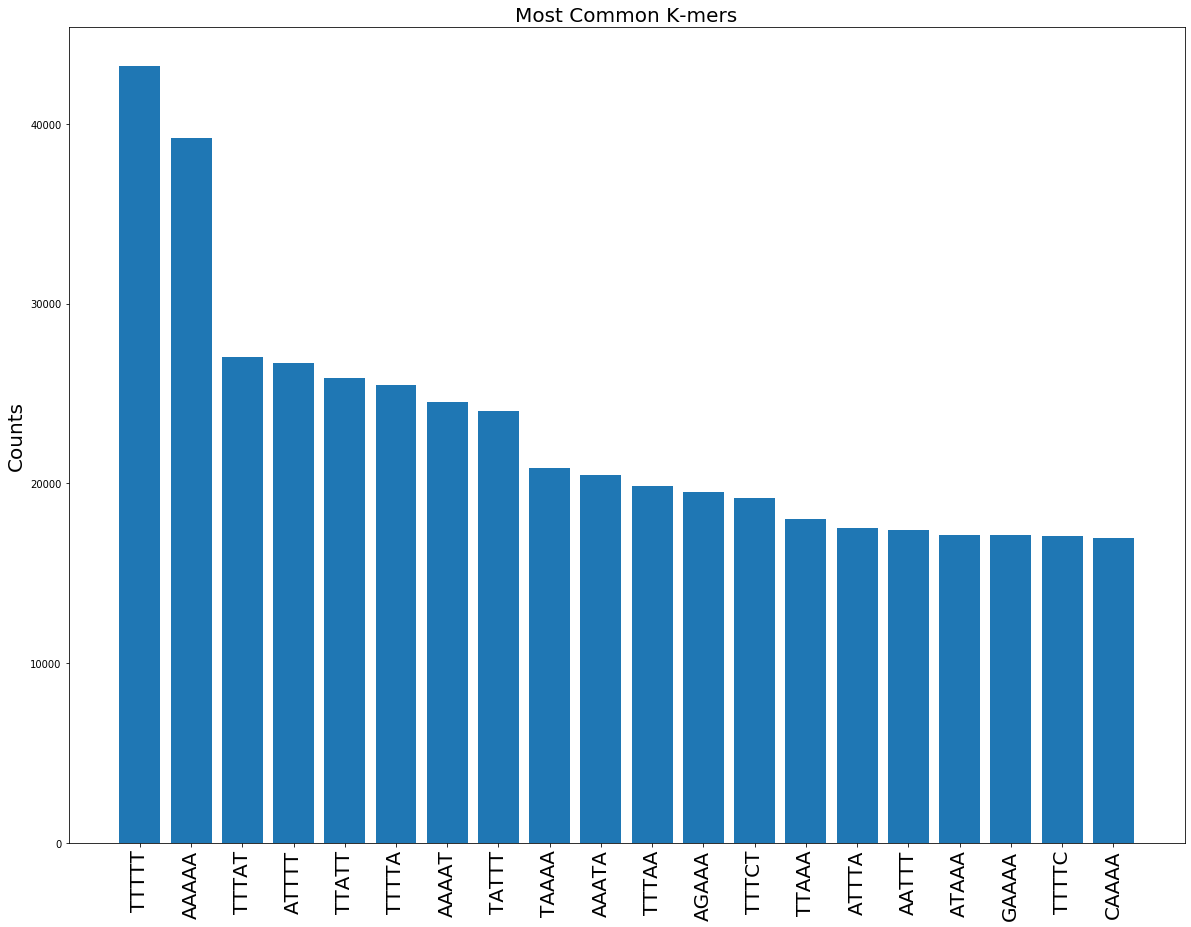

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
D = dict(Counter([item for sublist in sentences for item in sublist]).most_common(20))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.title('Most Common K-mers', fontsize = 20)
plt.ylabel("Counts", fontsize = 20)
plt.xticks(rotation = 90)
plt.xticks(range(len(D)), list(D.keys()), fontsize = 20)
plt.show()

Now let us disaply the k-mer / word / token counts for Neanderthal introgressed regions:

In [10]:
import pandas as pd
intr_counts = dict(Counter([item for sublist in intr_sentences for item in sublist]))
kmers = list(intr_counts.keys())
counts = list(intr_counts.values())
intr_df = pd.DataFrame({'Kmer': kmers, 'Count': counts})
intr_df = intr_df.sort_values(['Count'], ascending = False)
intr_df.head(10)

Kmer  Count
63   TTTTT  18026
20   TTTAT  17064
21   TTATT  16303
36   AAAAA  14876
51   TTTTA  13464
50   ATTTT  12342
49   TATTT  12326
130  GGCGG  11368
121  GCGGC  10247
57   TTTAA  10245

We can also check the GC content in the Neanderthal introgressed regions:

In [11]:
intr_long_seq = ''.join(intr_seqs)
((intr_long_seq.count('C') + intr_long_seq.count('G')) / len(intr_long_seq))*100

49.52203130907099

The GC-content for the chopped Neanderthal introgression sequences looks quite different from what we would have obtained without chopping the sequences. 

In [32]:
%%bash
cat hg19_introgr_clean.fa | grep -v ">" | awk 'BEGIN{a=0; c=0; g=0; t=0;} {a+=gsub("A",""); 
c+=gsub("C",""); g+=gsub("G",""); t+=gsub("T","");} END{print a,c,g,t}'

2131712452 1415460271 1416141395 2138472589


In [34]:
((1415460271 + 1416141395) / (2131712452 + 1415460271 + 1416141395 + 2138472589))*100

39.87167994230216

Now for comparison we will check the k-mer / word / token count for Neanderthal depeleted sequences and compute the GC-content for the chopped and full regions:

In [12]:
import pandas as pd
depl_counts = dict(Counter([item for sublist in depl_sentences for item in sublist]))
kmers = list(depl_counts.keys())
counts = list(depl_counts.values())
depl_df = pd.DataFrame({'Kmer': kmers, 'Count': counts})
depl_df = depl_df.sort_values(['Count'], ascending = False)
depl_df.head(10)

Kmer  Count
78   TTTTT  25173
311  AAAAA  24350
245  ATTTT  14354
4    AAAAT  14262
146  TTTTA  11975
3    TAAAA  11813
249  TATTT  11716
676  AAATA  11581
180  TTTCT  11412
444  AGAAA  10962

In [13]:
depl_long_seq = ''.join(depl_seqs)
((depl_long_seq.count('C') + depl_long_seq.count('G')) / len(depl_long_seq))*100

41.55551399293216

In [33]:
%%bash
cat hg19_depl_clean.fa | grep -v ">" | awk 'BEGIN{a=0; c=0; g=0; t=0;} {a+=gsub("A",""); 
c+=gsub("C",""); g+=gsub("G",""); t+=gsub("T","");} END{print a,c,g,t}'

2106254094 1442323861 1442967008 2110241744


In [35]:
((1442323861 + 1442967008) / (2106254094 + 1442323861 + 1442967008 + 2110241744))*100

40.62767565457947

In [14]:
merge_df = pd.merge(intr_df, depl_df, on = 'Kmer')
merge_df['Odds'] = merge_df['Count_y'] / merge_df['Count_x']
sorted_merge_df = merge_df.sort_values(['Odds'], ascending = False)
sorted_merge_df.head()

Kmer  Count_x  Count_y      Odds
861  CTAAT     1666     3921  2.353541
772  CTATT     2015     4397  2.182134
768  TCTAT     2050     4302  2.098537
818  GATTA     1854     3742  2.018339
907  CCTAT     1352     2606  1.927515

In [15]:
sorted_merge_df.tail()

Kmer  Count_x  Count_y      Odds
8    GCGGC    10247      597  0.058261
101  CGCGG     6145      358  0.058259
149  CCGCG     5575      311  0.055785
100  CGCCG     6155      252  0.040942
29   CGGCG     7847      283  0.036065

What we can see is that there is 0.5% for the chopped sequences and almost 0.8% difference in GC-content between the Neanderthal depleted and introgressed regions. It looks like the depleted regions have a higher GC-content indicating that they most likely belong to the gene regions.

Now we can think that the k-mers originating from the same sequence build a sentence or text or document (doc). For example let us display one sentence, we can clearly see words / k-mers separated by spaces lie in a regular text.

In [16]:
' '.join(intr_sentences[0])

'AAAAT AAATG AATGT ATGTG TGTGC GTGCT TGCTC GCTCA CTCAG TCAGT CAGTG AGTGT GTGTT TGTTA GTTAA TTAAC TAACT AACTT ACTTT CTTTA TTTAT TTATT TATTG ATTGA TTGAT TGATA GATAA ATAAT TAATA AATAA ATAAC TAACC AACCA ACCAA CCAAA CAAAA AAAAA AAAAC AAACA AACAA ACAAA CAAAC AAACC AACCT ACCTA CCTAA CTAAT TAATA AATAT ATATT TATTT ATTTT TTTTA TTTAT TTATG TATGA ATGAT TGATT GATTT ATTTT TTTTA TTTAA TTAAA TAAAA AAAAT AAATT AATTA ATTAT TTATT TATTT ATTTT TTTTT TTTTA TTTAA TTAAG TAAGC AAGCA AGCAC GCACA CACAA ACAAA CAAAA AAAAT AAATA AATAG ATAGA TAGAC AGACC GACCC ACCCA CCCAT CCATG CATGT ATGTT TGTTG GTTGG'

Now we are going to convert the sentences into word vectors, i.e. quantify the words / k-mers based on their similarity to each other. The number of unique k-mers gives us the vocabulary / dictionary of our molecular / biological texts.

In [17]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec
model = Word2Vec(sentences, min_count = 2, workers = 4)
print(model)

Word2Vec(vocab=1024, size=100, alpha=0.025)


In [18]:
X = model[model.wv.vocab]
X.shape

(1024, 100)

Now each word is one observation, this observation has 100 coordinates, i.e. the default number of latent variables for word2vec. Next we can try to use the constructed word vectors and visualize the k-mers space using PCA and UMAP.

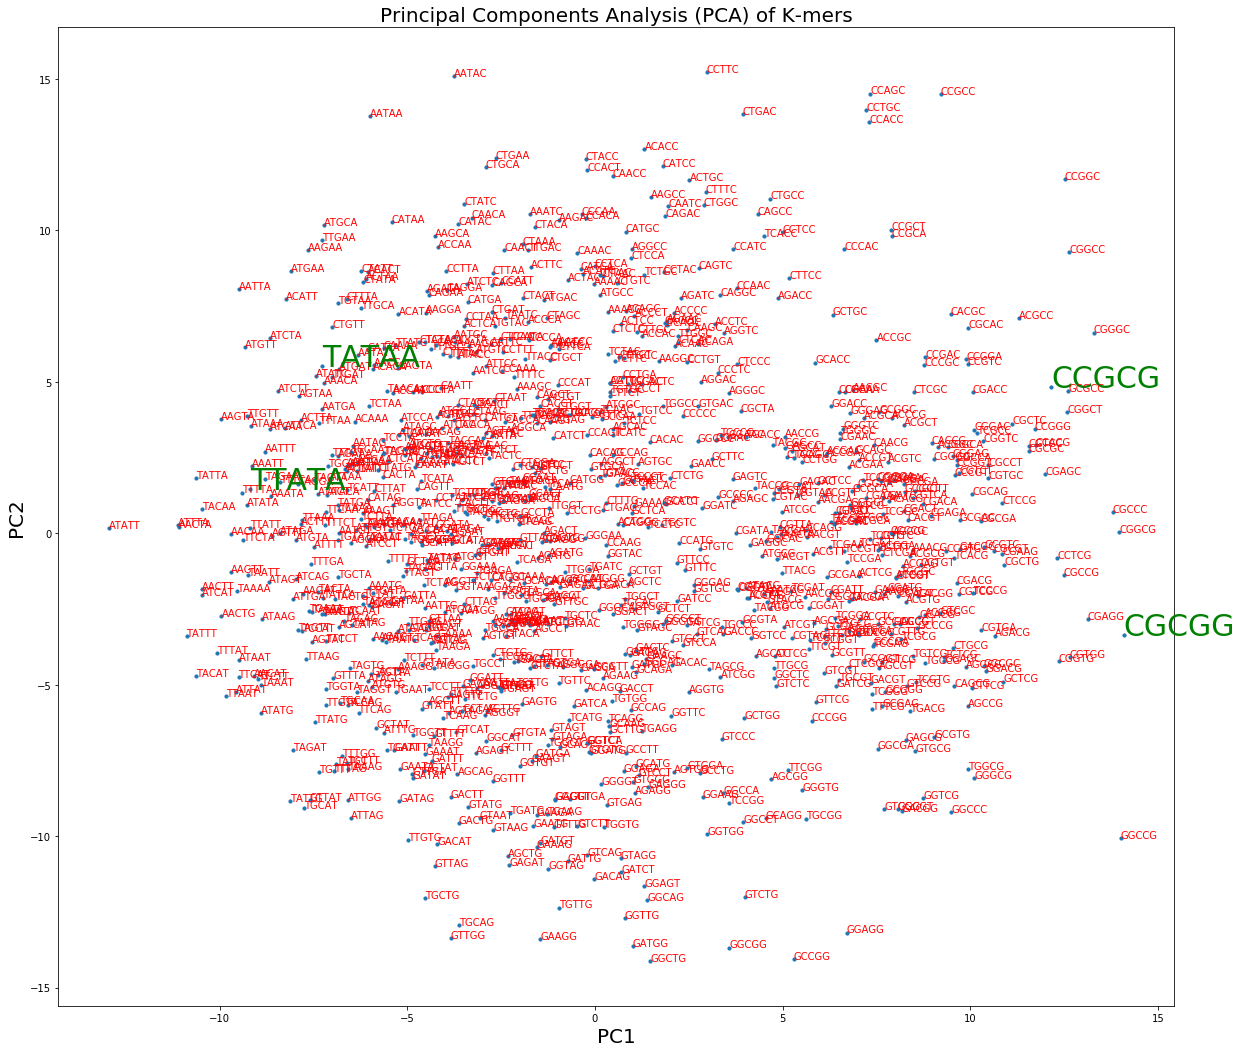

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
X = model[model.wv.vocab]
pca = PCA(n_components = 2)
result = pca.fit_transform(X)

plt.figure(figsize=(20,18))
plt.scatter(result[:, 0], result[:, 1], s = 10, cmap = 'tab10')
plt.title('Principal Components Analysis (PCA) of K-mers', fontsize = 20)
plt.xlabel("PC1", fontsize = 20)
plt.ylabel("PC2", fontsize = 20)
words = list(model.wv.vocab)
for i, word in enumerate(words):
    if word == 'CCGCG':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CGCGG':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTATA':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TATAA':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(result[i, 0], result[i, 1], word, fontsize = 10, c = 'red')
plt.show()

From the PCA plot it is clear that the left cluster of k-mers has an enrichment of GC-nucleotides while the left bigger cluster has predominantly AT-nucleotides.

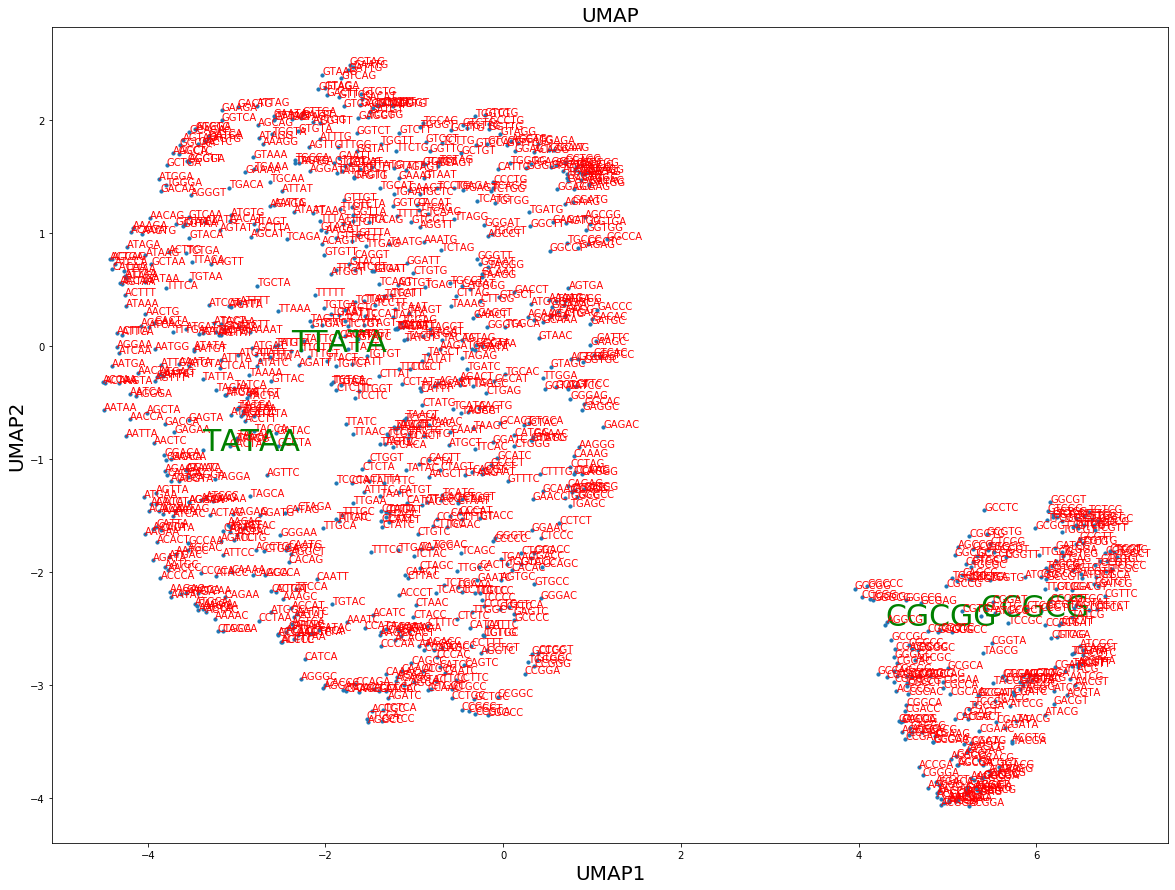

In [20]:
from umap import UMAP
import matplotlib.pyplot as plt
X = model[model.wv.vocab]
X_reduced = PCA(n_components = 5).fit_transform(X)
umap_model = UMAP(n_neighbors = 30, min_dist = 0.1, n_components = 2)
umap = umap_model.fit_transform(X_reduced)
plt.figure(figsize=(20,15))
plt.scatter(umap[:, 0], umap[:, 1], s = 10, cmap = 'tab10')
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
words = list(model.wv.vocab)
for i, word in enumerate(words):
    if word == 'CCGCG':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CGCGG':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TATAA':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTATA':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 10, c = 'red')
plt.show()

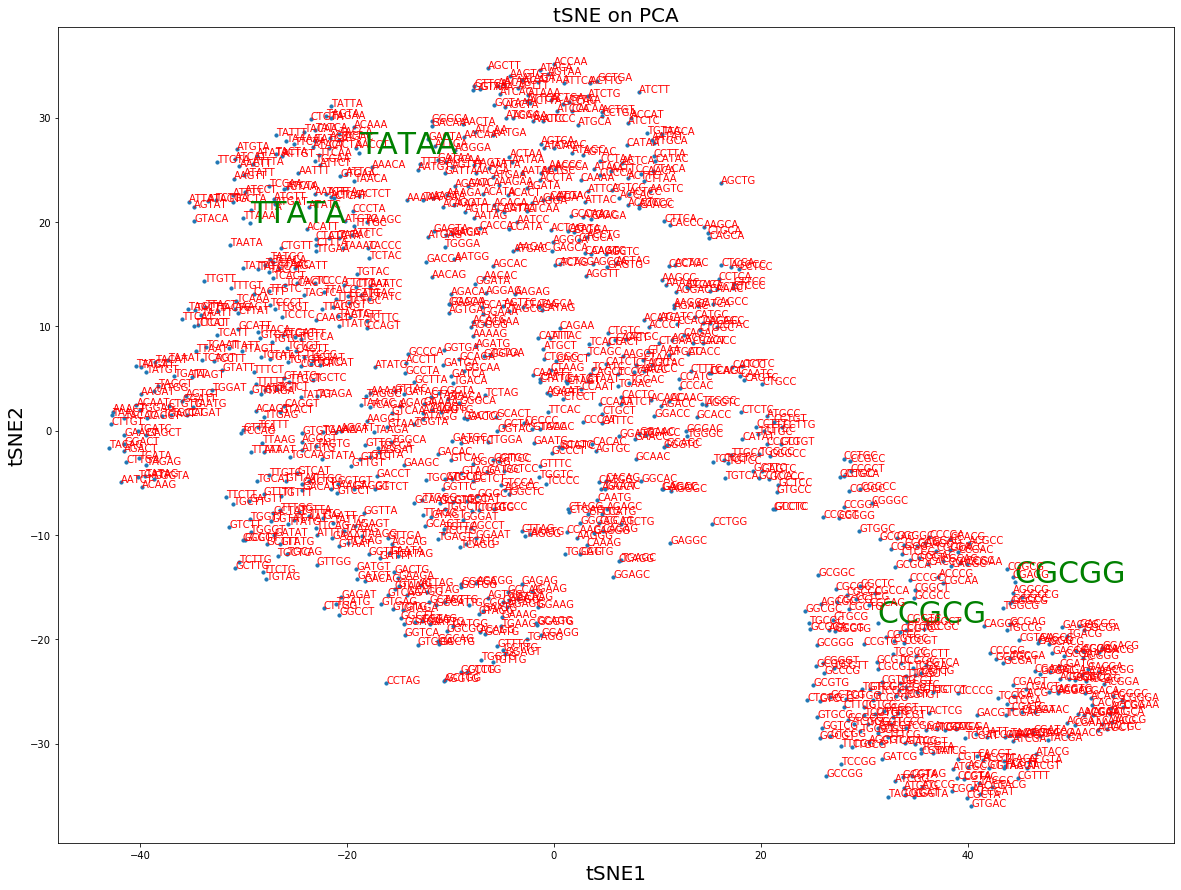

In [21]:
from sklearn.manifold import TSNE

plt.figure(figsize=(20, 15))
X_reduced = PCA(n_components = 5).fit_transform(X)
tsne_model = TSNE(learning_rate = 500, n_components = 2, random_state = 123, perplexity = 30)
tsne = tsne_model.fit_transform(X_reduced)
plt.scatter(tsne[:, 0], tsne[:, 1], cmap = 'tab10', s = 10)
plt.title('tSNE on PCA', fontsize = 20)
plt.xlabel("tSNE1", fontsize = 20)
plt.ylabel("tSNE2", fontsize = 20)
words = list(model.wv.vocab)
for i, word in enumerate(words):
    if word == 'CCGCG':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CGCGG':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TATAA':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTATA':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 10, c = 'red')
plt.show()

From both UMAP and tSNE plots we again clearly see that the left cluster of k-mers has an enrichment of GC-nucleotides while the left bigger cluster has predominantly AT-nucleotides.

Now let us define an important variable **max_length** which will be used in the keras Embedding layer. This variable indicates how many k-mers we have in each text / sequence. Next we will concatenate the k-mers from each sequence into a "sentence", these sentences will build documents (docs):

In [22]:
max_length = len(sentences[0])
print(max_length)

96


In [23]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

docs = [' '.join(i) for i in sentences]
print(docs[0],'\n')
print('We have ' + str(len(docs)) + ' texts / sequences')
print('Each text / sequence has ' + str(len(docs[0].split(' '))) + ' words / k-mers')

Using TensorFlow backend.


AAAAT AAATG AATGT ATGTG TGTGC GTGCT TGCTC GCTCA CTCAG TCAGT CAGTG AGTGT GTGTT TGTTA GTTAA TTAAC TAACT AACTT ACTTT CTTTA TTTAT TTATT TATTG ATTGA TTGAT TGATA GATAA ATAAT TAATA AATAA ATAAC TAACC AACCA ACCAA CCAAA CAAAA AAAAA AAAAC AAACA AACAA ACAAA CAAAC AAACC AACCT ACCTA CCTAA CTAAT TAATA AATAT ATATT TATTT ATTTT TTTTA TTTAT TTATG TATGA ATGAT TGATT GATTT ATTTT TTTTA TTTAA TTAAA TAAAA AAAAT AAATT AATTA ATTAT TTATT TATTT ATTTT TTTTT TTTTA TTTAA TTAAG TAAGC AAGCA AGCAC GCACA CACAA ACAAA CAAAA AAAAT AAATA AATAG ATAGA TAGAC AGACC GACCC ACCCA CCCAT CCATG CATGT ATGTT TGTTG GTTGG 

We have 75706 texts / sequences
Each text / sequence has 96 words / k-mers


In [24]:
from string import punctuation
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(docs)

In [25]:
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(docs)
# pad sequences
max_length = max([len(s.split()) for s in docs])
print(max_length)
#Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

96


In [26]:
print(encoded_docs[0])
print(len(encoded_docs[0]))
print(len(encoded_docs))

[7, 38, 194, 339, 509, 482, 432, 322, 86, 342, 169, 502, 497, 488, 653, 613, 628, 250, 74, 87, 3, 5, 282, 405, 472, 608, 650, 153, 192, 31, 702, 829, 382, 484, 189, 20, 2, 44, 24, 61, 29, 371, 357, 527, 801, 753, 658, 192, 55, 56, 8, 4, 6, 3, 529, 575, 399, 296, 234, 4, 6, 11, 14, 9, 7, 23, 92, 120, 5, 8, 4, 1, 6, 11, 438, 774, 193, 513, 445, 258, 29, 20, 7, 10, 478, 515, 828, 630, 712, 406, 590, 359, 362, 208, 328, 624]
96
75706


In [27]:
import numpy as np
my_labels = list(np.ones(len(intr_seqs))) + list(np.zeros(len(depl_seqs)))
len(my_labels)

75706

In [28]:
# integer encode the documents
#vocab_size = 1500
#encoded_docs = [one_hot(d, vocab_size) for d in docs]
#print(encoded_docs[0:10])

In [29]:
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[  7  38 194 ... 208 328 624]
 [596 331 216 ... 275 452 396]
 [ 25 150 313 ... 137 720 652]
 ...
 [282 353 368 ... 599 272 111]
 [171 449 209 ... 873 927 782]
 [228 115 204 ...  42  64 461]]


In [30]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

1025


In [31]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    padded_docs, my_labels, test_size = 0.2, random_state = 42)

In [32]:
train_features.shape

(60564, 96)

In [33]:
len(train_labels)

60564

In [34]:
test_features.shape

(15142, 96)

In [35]:
len(test_labels)

15142

In [39]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, Activation
from keras.models import Sequential
from keras.regularizers import l1

import warnings
warnings.filterwarnings('ignore')

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = max_length))
model.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(Activation("relu"))
model.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.5))

#model.add(Conv1D(filters = 64, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform'))
#model.add(Activation("relu"))
#model.add(Conv1D(filters = 64, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform'))
#model.add(Activation("relu"))
#model.add(MaxPooling1D(pool_size = 2))
#model.add(Dropout(0.1))

#model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform'))
#model.add(Activation("relu"))
#model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform'))
#model.add(Activation("relu"))
#model.add(MaxPooling1D(pool_size = 2))
#model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(16, kernel_initializer = 'he_uniform'))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 200
lrate = 0.01
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 96, 100)           102500    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
activation_7 (Activation)    (None, 96, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 96, 128)           82048     
_________________________________________________________________
activation_8 (Activation)    (None, 96, 128)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 48, 128)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 128)           0         
__________

In [40]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(train_features, train_labels, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 128, shuffle = True)

Train on 48451 samples, validate on 12113 samples
Epoch 1/200
48451/48451 [==============================] - 84s 2ms/step - loss: 0.6932 - binary_accuracy: 0.5042 - val_loss: 0.6921 - val_binary_accuracy: 0.5223
Epoch 2/200
48451/48451 [==============================] - 84s 2ms/step - loss: 0.6892 - binary_accuracy: 0.5363 - val_loss: 0.6697 - val_binary_accuracy: 0.6182
Epoch 3/200
48451/48451 [==============================] - 85s 2ms/step - loss: 0.5541 - binary_accuracy: 0.7258 - val_loss: 0.4653 - val_binary_accuracy: 0.7884
Epoch 4/200
48451/48451 [==============================] - 85s 2ms/step - loss: 0.4732 - binary_accuracy: 0.7934 - val_loss: 0.4563 - val_binary_accuracy: 0.7932
Epoch 5/200
48451/48451 [==============================] - 84s 2ms/step - loss: 0.4550 - binary_accuracy: 0.8019 - val_loss: 0.4238 - val_binary_accuracy: 0.8122
Epoch 6/200
48451/48451 [==============================] - 84s 2ms/step - loss: 0.4404 - binary_accuracy: 0.8086 - val_loss: 0.4200 - val_bi

48451/48451 [==============================] - 84s 2ms/step - loss: 0.0574 - binary_accuracy: 0.9813 - val_loss: 0.6780 - val_binary_accuracy: 0.8579
Epoch 52/200
48451/48451 [==============================] - 84s 2ms/step - loss: 0.0570 - binary_accuracy: 0.9814 - val_loss: 0.6641 - val_binary_accuracy: 0.8513
Epoch 53/200
48451/48451 [==============================] - 83s 2ms/step - loss: 0.0549 - binary_accuracy: 0.9819 - val_loss: 0.6540 - val_binary_accuracy: 0.8493
Epoch 54/200
48451/48451 [==============================] - 84s 2ms/step - loss: 0.0546 - binary_accuracy: 0.9819 - val_loss: 0.6747 - val_binary_accuracy: 0.8464
Epoch 55/200
48451/48451 [==============================] - 83s 2ms/step - loss: 0.0537 - binary_accuracy: 0.9823 - val_loss: 0.7186 - val_binary_accuracy: 0.8423
Epoch 56/200
48451/48451 [==============================] - 83s 2ms/step - loss: 0.0536 - binary_accuracy: 0.9825 - val_loss: 0.6726 - val_binary_accuracy: 0.8504
Epoch 57/200
48451/48451 [=========

48451/48451 [==============================] - 84s 2ms/step - loss: 0.0136 - binary_accuracy: 0.9962 - val_loss: 0.9965 - val_binary_accuracy: 0.8517
Epoch 152/200
48451/48451 [==============================] - 84s 2ms/step - loss: 0.0143 - binary_accuracy: 0.9961 - val_loss: 0.9632 - val_binary_accuracy: 0.8622
Epoch 153/200
48451/48451 [==============================] - 84s 2ms/step - loss: 0.0125 - binary_accuracy: 0.9965 - val_loss: 1.0184 - val_binary_accuracy: 0.8522
Epoch 154/200
48451/48451 [==============================] - 84s 2ms/step - loss: 0.0140 - binary_accuracy: 0.9962 - val_loss: 0.9877 - val_binary_accuracy: 0.8585
Epoch 155/200
48451/48451 [==============================] - 84s 2ms/step - loss: 0.0130 - binary_accuracy: 0.9962 - val_loss: 1.0269 - val_binary_accuracy: 0.8513
Epoch 156/200
48451/48451 [==============================] - 84s 2ms/step - loss: 0.0141 - binary_accuracy: 0.9960 - val_loss: 0.9880 - val_binary_accuracy: 0.8597
Epoch 157/200
48451/48451 [===

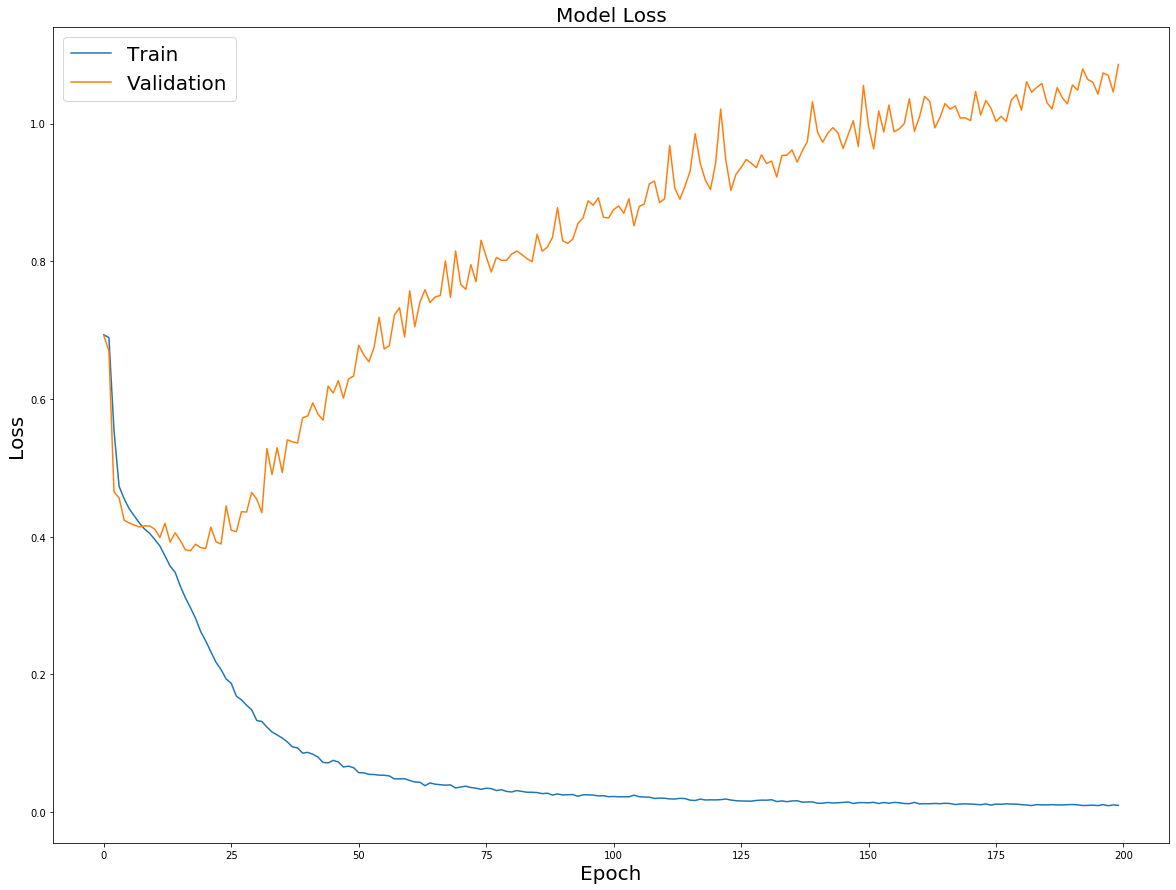

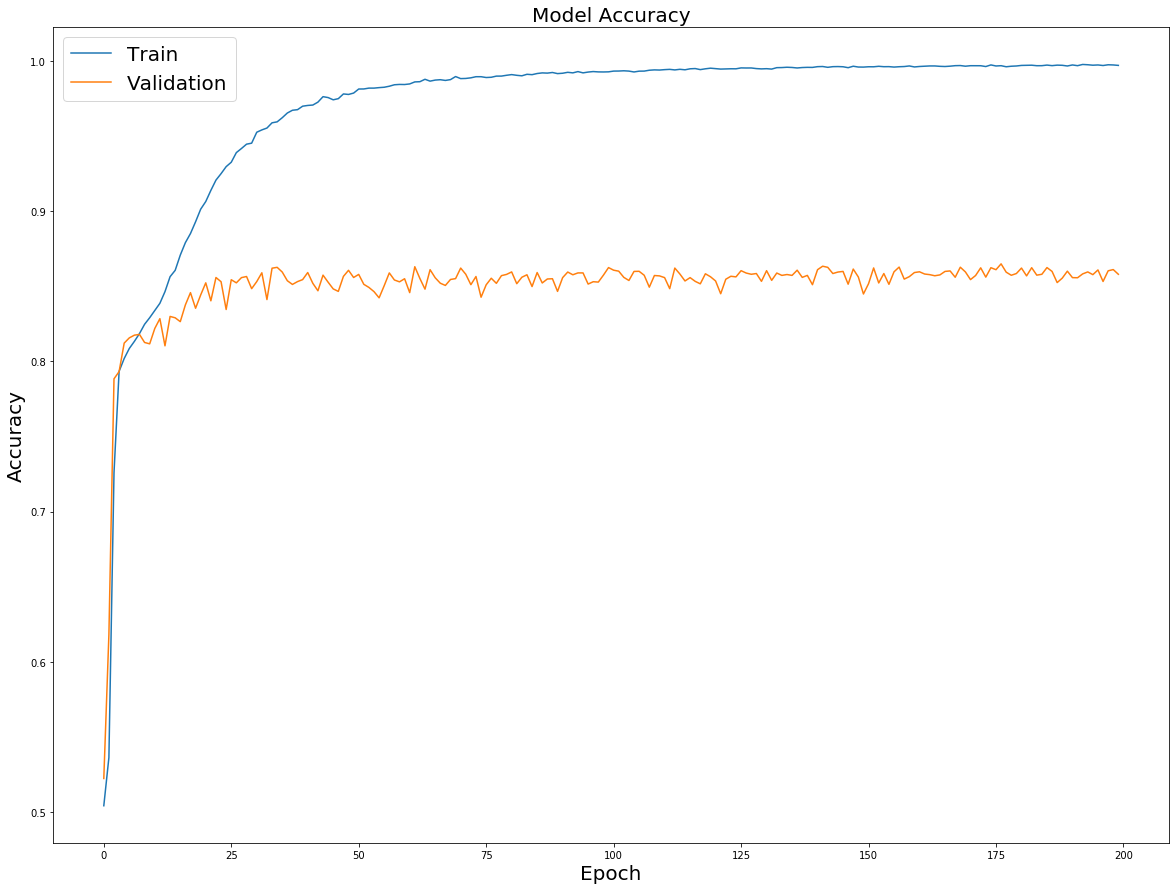

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

Confusion matrix:
 [[6416 1107]
 [1078 6541]]


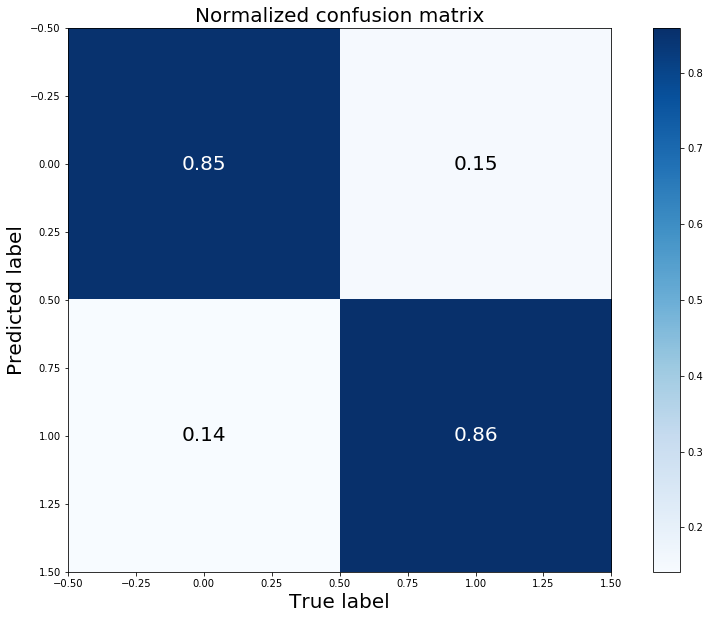

In [42]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(15,10))

predicted_labels = model.predict(test_features)
cm = confusion_matrix(test_labels, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
#plt.xticks([0, 1]); plt.yticks([0, 1])
#plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [43]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.57%


In [120]:
import keras.backend as K

def get_layer_output_grad(model, inputs, outputs, layer=-1):
    """ Gets gradient a layer output for given inputs and outputs"""
    grads = model.optimizer.get_gradients(model.total_loss, model.layers[layer].output)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    return output_grad

In [230]:
import numpy as np
import keras
from keras import backend as K

#model = keras.Sequential()
#model.add(keras.layers.Dense(20, input_shape = (10, )))
#model.add(keras.layers.Dense(5))
#model.compile('adam', 'mse')

dummy_in = np.ones((4, train_features.shape[1]))
#dummy_in = train_features[0].reshape(1,-1)
dummy_out = np.ones((4, 1))
#dummy_out = np.ones((1, 1))

#dummy_in = np.ones((4, 10))
#dummy_out = np.ones((4, 5))
dummy_loss = model.train_on_batch(dummy_in, dummy_out)

output_grad = get_layer_output_grad(model, dummy_in, dummy_out)
print(dummy_in)
print(dummy_out)
print(output_grad)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [231]:
dummy_in.shape

(4, 96)

In [232]:
dummy_out.shape

(4, 1)

In [233]:
np.array(output_grad).shape

(1, 4, 1)

### Word Embeddings + Multichannel Convolutional Neural Network (CNN)  <a class="anchor" id="Word-Embeddings-+-Multichannel-Convolutional-Neural-Network-(CNN)"></a>

Here we will build a Multichannel Convolutional Neural Network (CNN) where each channel will be learning a specific k-mer structure via its own convolutional filter size. In this way we can address different k-mer sizes and possibly achieve a better classification via combining information from different k-mer sizes, i.e. capuring better both global and local structure.

In [44]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

In [45]:
train_features.shape

(60564, 96)

In [46]:
len(train_labels)

60564

In [47]:
vocab_size

1025

In [52]:
# channel 1
inputs1 = Input(shape = (train_features.shape[1], ))
embedding1 = Embedding(vocab_size, 100)(inputs1)
conv1 = Conv1D(filters = 16, kernel_size = 5, activation = 'relu')(embedding1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size = 2)(drop1)
flat1 = Flatten()(pool1)

# channel 2
inputs2 = Input(shape = (train_features.shape[1],))
embedding2 = Embedding(vocab_size, 100)(inputs2)
conv2 = Conv1D(filters = 16, kernel_size = 10, activation = 'relu')(embedding2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size = 2)(drop2)
flat2 = Flatten()(pool2)

# channel 3
inputs3 = Input(shape = (train_features.shape[1],))
embedding3 = Embedding(vocab_size, 100)(inputs3)
conv3 = Conv1D(filters = 16, kernel_size = 15, activation = 'relu')(embedding3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size = 2)(drop3)
flat3 = Flatten()(pool3)

# merge
merged = concatenate([flat1, flat2, flat3])

# interpretation
dense1 = Dense(8, activation = 'relu')(merged)
drop4 = Dropout(0.5)(dense1)
outputs = Dense(1, activation = 'sigmoid')(drop4)
model = Model(inputs = [inputs1, inputs2, inputs3], outputs = outputs)

# compile
epochs = 50
#lrate = 0.01
#decay = lrate / epochs
#sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
#model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# summarize
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 96)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 96)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 96)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 96, 100)      102500      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_

In [49]:
plot_model(model, show_shapes = False, to_file = 'multichannel.svg', show_layer_names = False)

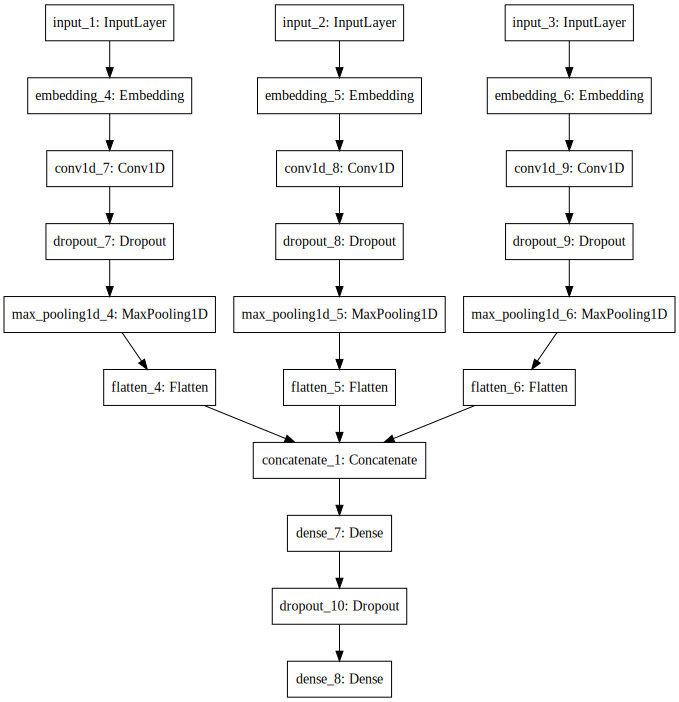

In [50]:
import pydot_ng as pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes = False).create(prog = 'dot', format = 'svg'))

In [53]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit([train_features, train_features, train_features], train_labels, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 128, shuffle = True)

Train on 48451 samples, validate on 12113 samples
Epoch 1/50
48451/48451 [==============================] - 44s 906us/step - loss: 0.5405 - acc: 0.6956 - val_loss: 0.4287 - val_acc: 0.8140
Epoch 2/50
48451/48451 [==============================] - 46s 954us/step - loss: 0.4514 - acc: 0.7798 - val_loss: 0.4084 - val_acc: 0.8218
Epoch 3/50
48451/48451 [==============================] - 46s 952us/step - loss: 0.4070 - acc: 0.8048 - val_loss: 0.3836 - val_acc: 0.8374
Epoch 4/50
48451/48451 [==============================] - 48s 997us/step - loss: 0.3669 - acc: 0.8227 - val_loss: 0.3730 - val_acc: 0.8427
Epoch 5/50
48451/48451 [==============================] - 48s 986us/step - loss: 0.3361 - acc: 0.8377 - val_loss: 0.3700 - val_acc: 0.8501
Epoch 6/50
48451/48451 [==============================] - 49s 1ms/step - loss: 0.3028 - acc: 0.8496 - val_loss: 0.3727 - val_acc: 0.8503
Epoch 7/50
48451/48451 [==============================] - 47s 975us/step - loss: 0.2803 - acc: 0.8604 - val_loss: 0.37

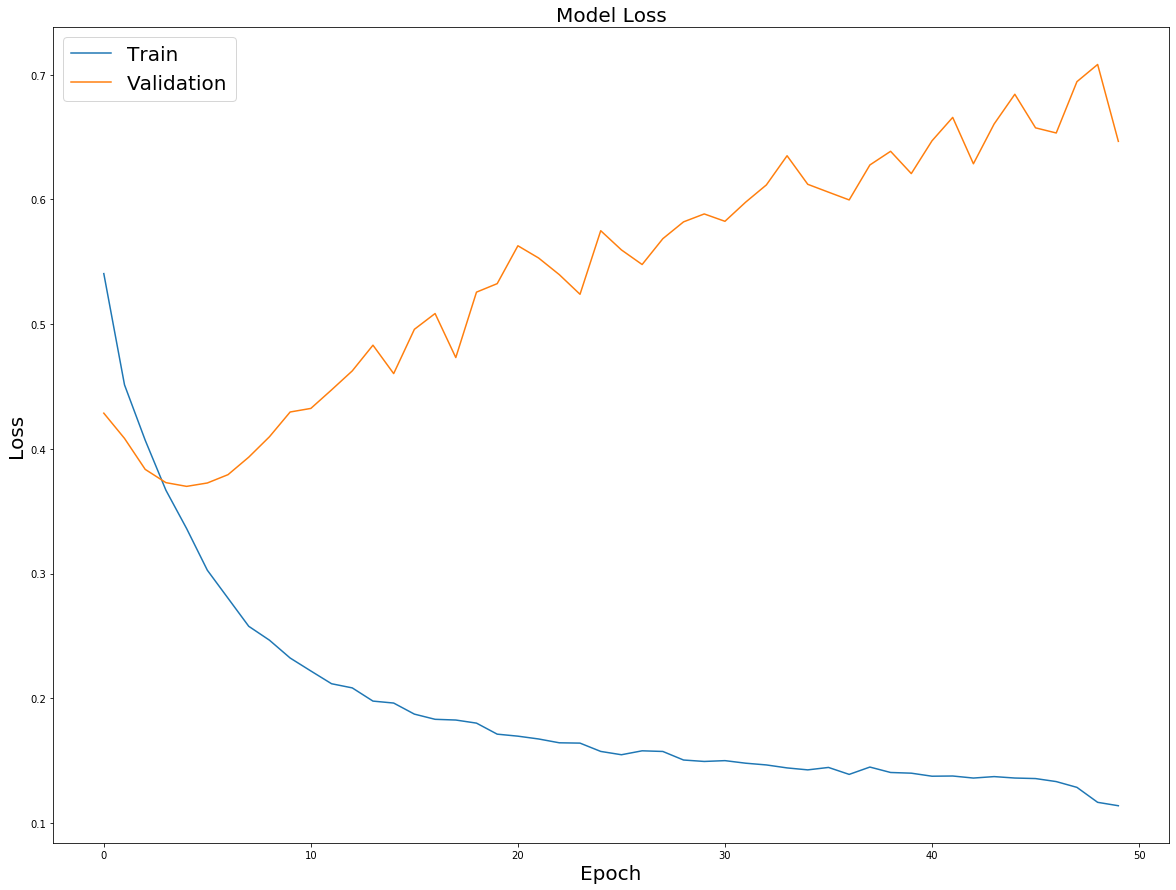

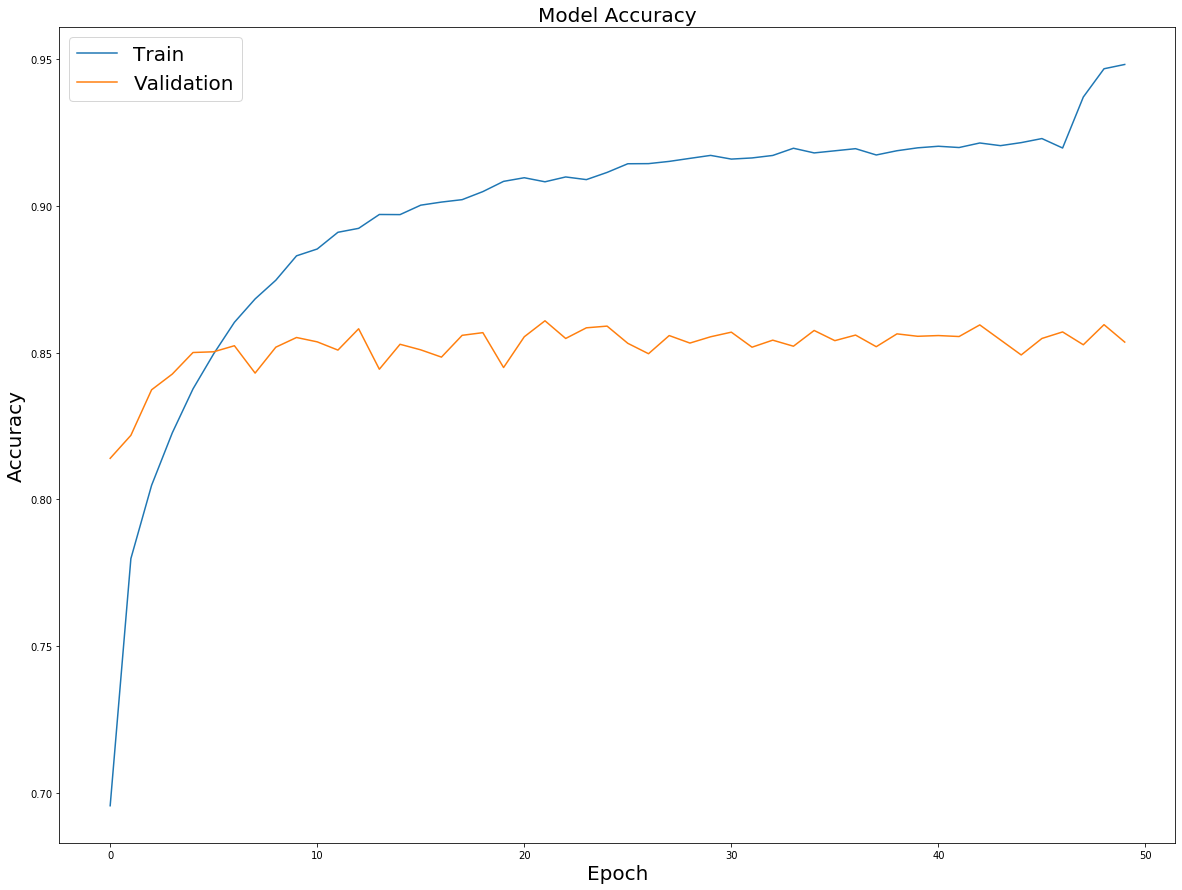

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

In [55]:
predicted_labels = model.predict([test_features, test_features, test_features])
predicted_labels[0:10]

array([[5.8978796e-05],
       [9.9998343e-01],
       [0.0000000e+00],
       [1.8179417e-06],
       [9.9999833e-01],
       [8.3506107e-05],
       [9.9959558e-01],
       [3.4824908e-03],
       [2.7171725e-01],
       [1.1920929e-06]], dtype=float32)

In [56]:
[np.round(i[0]) for i in predicted_labels][0:10]

[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]

In [57]:
test_labels[0:10]

[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]

In [58]:
test_features[0:10]

array([[ 916,  879,  876,  582,   79,  284,   83,  410,  755,  583,  783,
         646,  100,  351,  172,  276,  558,  296,  656,  518,  142,  259,
         201,  257,  665,  563,  840,  574,  758,  431,  670,  384,  698,
         230,  768,  824,  739,  800,  300,  269,  601,  427,  495,  701,
         770,  742,  658,   78,   16,    4,    1,   32,   46,  364,  154,
         497,   36,   47,    1,    6,   11,   60,  192,  478,  515,  571,
          51,  403,  468,  825,  515,  571,  404,  500,   89,   47,   32,
         297,  557,  335,  538,  359,  362,  208,  328,  624,  498,  275,
         291,  188,   42,   76,  149,   41,  117,  129],
       [ 613,  370,  200,  201,   64,   50,  522,  499,   31,  153,  638,
         544,  474,  366,  189,   20,   28,  105,  231,   89,   47,    6,
          11,   60,  454,  316,  520,  414,  307,   47,    6,   11,   60,
         192,   31,  588,  591,  231,  584,  653,   60,   78,   16,   15,
         312,  594,  836,  450,  674,  562,  441,   17,

Confusion matrix:
 [[6440 1083]
 [1071 6548]]


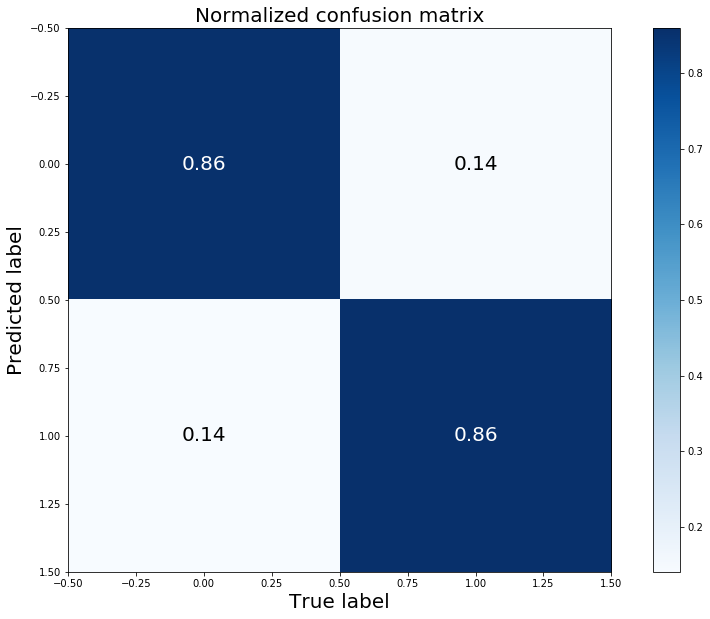

In [59]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(15,10))

predicted_labels = model.predict([test_features, test_features, test_features])
cm = confusion_matrix(test_labels, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
#plt.xticks([0, 1]); plt.yticks([0, 1])
#plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [60]:
scores = model.evaluate([test_features, test_features, test_features], test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.77%
